In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils
from utils.training_utils import train_model, test_model
from models.dense_convtranspose1d import DenseConvTranspose1D
import Simple_RCWA

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
pi = np.pi

# ================= Unit Define
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ================= Constant Define
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Visualize Target Spectra

In [4]:
# path_true_R = './Simple_RCWA/data/R_absorber.txt'
# R_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_R)
# freq_true = R_file[:, 0] * 1e12
# R_true = R_file[:, 1]
# R_true = R_true**2
# print('freq_true.shape', freq_true.shape)
# # print(R_true)

# path_true_T = './Simple_RCWA/data/T_absorber.txt'
# T_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_T)
# T_true = T_file[:, 1]
# T_true = T_true**2

# # truncate freq
# freq_truncate = 1.7  # in THz
# N_freq_stop = np.argmax(R_file[:,0]>freq_truncate)
# freq_true = freq_true[:N_freq_stop]
# R_true = R_true[:N_freq_stop]
# T_true = T_true[:N_freq_stop]
# freq_step = 4
# freq_true, R_true, T_true = freq_true[::freq_step], R_true[::freq_step], T_true[::freq_step]
# print('R_true.shape', R_true.shape)

# plt.figure(1)
# plt.plot(freq_true, R_true, label='true')
# plt.title('freq-Reflection')
# plt.legend()

# plt.figure(2)
# plt.plot(freq_true, T_true, label='true')
# plt.title('freq-Transmission')
# plt.legend()
# plt.show()

# # ================= Material Property Define
# path_absorber = './Simple_RCWA/material_property/permittivity_absorber.txt'
# eps_absorber_file = Simple_RCWA.utils.data_utils.load_property_txt(path_absorber)
# print(eps_absorber_file.shape[0])
# # truncate freq over 1.7THz
# # freq_truncate = 1.7  # in THz
# # freq_step = 4
# if freq_truncate != 'none' and freq_truncate>eps_absorber_file[0,0] and freq_truncate<eps_absorber_file[-1,0]:
#     N_freq_stop = np.argmax(eps_absorber_file[:,0]>freq_truncate)
#     eps_absorber_file = eps_absorber_file[:N_freq_stop]
# eps_absorber_file = eps_absorber_file[::freq_step]  # solve rcwa with a step size
# eps_absorber = eps_absorber_file[:,1] + eps_absorber_file[:,2]*1j

# freq = eps_absorber_file[:,0]*1e12
# print(freq.shape)


# # ================== Get Target Spectra Value
# # print(freq_true)
# idx_freq_tg1 = np.min(np.argwhere(freq_true>=1.4*1e12))
# print('idx_freq_tg1 ORIG:', idx_freq_tg1)
# R_tg1 = R_true[idx_freq_tg1]
# T_tg1 = T_true[idx_freq_tg1]
# T_tg2 = T_true[0]

# idx_freq_tg1 = idx_freq_tg1/201*222
# print('idx_freq_tg1:', idx_freq_tg1)
# print('R_tg1:', R_tg1)
# print('T_tg1:', T_tg1)
# print('T_tg2:', T_tg2)


# print('--------')
# idx_freq_tg2 = np.min(np.argwhere(freq_true>=1.2*1e12))
# print('idx_freq_tg2 ORIG:', idx_freq_tg2)
# R_tg2 = R_true[idx_freq_tg2]

# idx_freq_tg2 = idx_freq_tg2/201*222
# print('idx_freq_tg2:', idx_freq_tg2)
# print('R_tg2:', R_tg2)

(222,)
Calculation Progress: 100%
freq.shape: (222,)
R_total.shape: (222,)
T_total.shape: (222,)


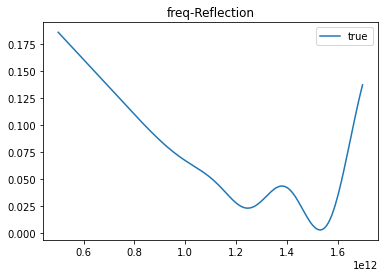

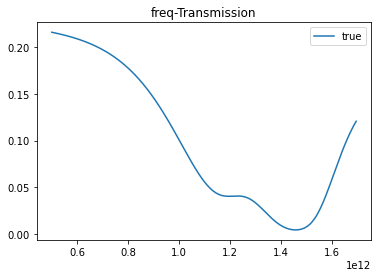

In [5]:
#******************************************************************
'''
Ellipse hole absorber.
'''
# ================= Material Property Define
path_absorber = './Simple_RCWA/material_property/permittivity_absorber.txt'
eps_absorber_file = Simple_RCWA.utils.data_utils.load_property_txt(path_absorber)
# truncate freq over 1.7THz
freq_truncate = 1.7  # in THz
freq_step = 4
if freq_truncate != 'none' and freq_truncate>eps_absorber_file[0,0] and freq_truncate<eps_absorber_file[-1,0]:
    N_freq_stop = np.argmax(eps_absorber_file[:,0]>freq_truncate)
    eps_absorber_file = eps_absorber_file[:N_freq_stop]
eps_absorber_file = eps_absorber_file[::freq_step]  # solve rcwa with a step size
eps_absorber = eps_absorber_file[:,1] + eps_absorber_file[:,2]*1j

freq = eps_absorber_file[:,0]*1e12
print(freq.shape)

# ================= Material Structure Define
a = 160.
t = 75.

Lx = a * micrometres  # period along x
Ly = a * micrometres  # period along y
d1 = t * micrometres  # thickness of layer 1

D1 = 150. * micrometres  # two axes of the ellipse hole
D2 = 130. * micrometres

params_eps = [eps_absorber]
params_geometry = [Lx, Ly, [d1]]
params_mesh = [512,512]
order = 7
PQ_order = [order,order]
list_layer_funcs = [Simple_RCWA.utils.rcwa_utils.layerfunc_absorber_ellipse_hole]
list_layer_params = [[D1, D2]]
ginc = [0,0,1]  # orig [0,0,1], incident source
EP = [0,1,0]  # orig [0,1,0]
source = [ginc, EP]
device_rcwa = 'gpu'

# ================= RCWA Solver
Si_square_hole = Simple_RCWA.utils.rcwa_utils.Material(freq, params_eps, params_geometry, params_mesh, PQ_order,
                                     list_layer_funcs, list_layer_params, source, device_rcwa)
R_total, T_total = Si_square_hole.rcwa_solve()

print('freq.shape:', freq.shape)
print('R_total.shape:', R_total.shape)
print('T_total.shape:', T_total.shape)
R_target = R_total
T_target = T_total

plt.figure(1)
plt.plot(freq, R_target, label='true')
plt.title('freq-Reflection')
plt.legend()

plt.figure(2)
plt.plot(freq, T_target, label='true')
plt.title('freq-Transmission')
plt.legend()
plt.show()

# Looping to generate data and training

In [6]:
def visualize_trained_net(dataloader_test, size_fig=(21,12)):
    for idx, data in enumerate(dataloader_test):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        y_pred = net_dense(X)  # [N_eg,2,N_freq]

        y_np = y.cpu().detach().numpy()
        y_pred_np = y_pred.cpu().detach().numpy()
        if idx==0:
            y_test_np = y_np
            y_test_pred_np = y_pred_np
        else:
            y_test_np = np.concatenate((y_test_np,y_np), axis=0)
            y_test_pred_np = np.concatenate((y_test_pred_np,y_pred_np), axis=0)
            
        if y_test_pred_np.shape[0]>=4:
            break
    print('y_test_np.shape:', y_test_np.shape)
    print('y_test_pred_np.shape:', y_test_pred_np.shape)

    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Training result on test set: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Training result on test set: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))
    plt.show()
    
    
def visualize_spectra_search(params_pick, R_pick, T_pick, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra search result: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra search result: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()
    
    
def visualize_learned_and_rcwa(param_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra of learned network and RCWA: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(R_simu.shape[1]), R_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra of learned network and RCWA: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(T_simu.shape[1]), T_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()

**************************** ROUND 1 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 200
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [140.  93.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [72. 64.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [91. 59.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 76. 146.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [79. 62.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [104.  63.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [94. 81.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [144. 144.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [ 77. 115.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [117. 130.]
Calculation Progress: 100%
-------

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [75. 77.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [131. 133.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [121. 119.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [110. 110.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [59. 74.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [ 85. 120.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [139. 114.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [113.  80.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [ 67. 132.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [128. 120.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [72. 60.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [102.  92.]
Calculation Progress: 100%
-------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.0013504134703180171
### TEST LOSS  0.0006406830701356133
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.0008987541026544932
### TEST LOSS  0.0003050604136660695
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 0.00044983629458329234
### TEST LOSS  0.00022033017497354498
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 0.0005457198326348589
### TEST LOSS  0.00047505879774689674
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 0.00025127814526967993
### TEST LOSS  0.00033838898525573313
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 0.00037015726702520623
### TEST LOSS  0.00014598420239053667
---------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 7.421781612265477e-05
### TEST LOSS  1.1727838834000673e-05
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.7098493291598515e-05
### TEST LOSS  9.258106577666089e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.3291235575820792e-05
### TEST LOSS  1.231390767012878e-05
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 9.166733390770786e-06
### TEST LOSS  1.1229154551983811e-05
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 7.654035317727904e-06
### TEST LOSS  8.385457476833835e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 0.00012432580168479036
### TEST LOSS  2.012235078533801e-05
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.5295032340247872e-05
### TEST LOSS  5.062438503955491e-05
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 3.537749412373614e-05
### TEST LOSS  1.0252279935230035e-05
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.5228530472199964e-05
### TEST LOSS  5.339326283622843e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 2.0896844878564026e-05
### TEST LOSS  1.218429558017912e-05
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 2.1059341290197153e-05
### TEST LOSS  8.408391446816191e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.2272603610767874e-05
### TEST LOSS  4.422859395466124e-05
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 1.5685881059823715e-06
### TEST LOSS  7.142948182566519e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 1.7715973547893782e-06
### TEST LOSS  4.096442732285747e-06
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 2.4522162676987592e-06
### TEST LOSS  9.93273829408281e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 1.828267233037195e-06
### TEST LOSS  5.175835819197043e-06
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.7581591421134134e-06
### TEST LOSS  8.370424401012618e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 1.6195846109212652e-06
### TEST LOSS  6.253832983323567e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 8.018407329046795e-07
### TEST LOSS  5.059064373350944e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 9.436962728059939e-07
### TEST LOSS  3.7727931119964825e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 7.589498616766832e-07
### TEST LOSS  4.297496332128503e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.084690414098759e-07
### TEST LOSS  6.959726306376979e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.61594369585805e-07
### TEST LOSS  7.212030747420309e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 7.452989518696995e-07
### TEST LOSS  5.509193670150125e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 6.174558497562544e-07
### TEST LOSS  4.838485002286083e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 6.558124215061411e-07
### TEST LOSS  4.6136666279987065e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.46788819733024e-07
### TEST LOSS  3.35077345425816e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.253602706289939e-07
### TEST LOSS  2.130398267278603e-06
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 6.370447118442258e-07
### TEST LOSS  4.6446488492316956e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.904054889820486e-07
### TEST LOSS  3.848653022942017e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 7.583277407618993e-07
### TEST LOSS  4.2184572635051154e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.949362722683759e-07
### TEST LOSS  2.701868595522683e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.790858174530399e-07
### TEST LOSS  4.486843749873515e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.079411819191137e-07
### TEST LOSS  2.0921843220852074e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.353066718680964e-07
### TEST LOSS  2.861973721716519e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.1238327515458194e-07
### TEST LOSS  2.480564139280735e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.089881846880417e-07
### TEST LOSS  4.2671968003560323e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.248737387335666e-07
### TEST LOSS  3.8380499252828787e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.3953668621578003e-07
### TEST LOSS  2.569635076573225e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.045544607793715e-07
### TEST LOSS  2.003144885520669e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.4334965967275364e-07
### TEST LOSS  3.919608388969209e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.6192349742947274e-07
### TEST LOSS  3.2521087215779215e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.3300457491568523e-07
### TEST LOSS  2.0964352150561658e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 2.994977434411794e-07
### TEST LOSS  2.225779761981054e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 2.8330873339754705e-07
### TEST LOSS  4.6747914931681106e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 2.67626177450353e-07
### TEST LOSS  1.6070036679138866e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 2.3385701210187902e-07
### TEST LOSS  2.5491221814869885e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 2.827036007246875e-07
### TEST LOSS  1.8533901406196188e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.186314206793384e-07
### TEST LOSS  2.8405972329892393e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.876385607666123e-07
### TEST LOSS  3.538260481642889e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.6725989410513194e-07
### TEST LOSS  2.66172378360352e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.428073907763007e-07
### TEST LOSS  1.4212379066217787e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.5142319310565994e-07
### TEST LOSS  2.5661646911127417e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 2.701110608249735e-07
### TEST LOSS  1.6456378659768234e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 1.0941374179296304e-06
### TEST LOSS  1.1869335215427175e-06
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 1.6286366169282473e-06
### TEST LOSS  6.60571364126857e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 2.378562073062085e-06
### TEST LOSS  1.0267344805470202e-06
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 1.511557897089233e-06
### TEST LOSS  8.240190065104495e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 8.095612040648348e-07
### TEST LOSS  4.249469138054944e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 1.1590555201124174e-06
### TEST LOSS  1.6059191617993445e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.7847096324483686e-07
### TEST LOSS  2.7055707126540557e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 5.05884611712304e-07
### TEST LOSS  3.8861449525029457e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.89801978464277e-07
### TEST LOSS  2.3190338064675112e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.0966016861810886e-07
### TEST LOSS  2.3225557299610955e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.3832880097127714e-07
### TEST LOSS  4.465939487848421e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.1239668135517605e-07
### TEST LOSS  1.6807007341412827e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 1.7519700569934571e-06
### TEST LOSS  1.9414199717478673e-06
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 2.2795608269632337e-06
### TEST LOSS  1.9890208401799705e-06
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 1.9677531515327473e-06
### TEST LOSS  1.5324007639113308e-06
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 8.120894837659876e-07
### TEST LOSS  2.7375879957010816e-06
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 7.112411206477987e-07
### TEST LOSS  4.5183648467173043e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.79867579912252e-07
### TEST LOSS  2.7092510398081987e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.4332366741551825e-07
### TEST LOSS  1.6683194322316316e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.464104307582261e-07
### TEST LOSS  2.562541112638428e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 2.2429728353756671e-07
### TEST LOSS  3.475689709375729e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 2.637942958205741e-07
### TEST LOSS  2.606566482654671e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 1.043498355119965e-06
### TEST LOSS  1.3788474764927134e-06
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 6.604753951933162e-07
### TEST LOSS  2.1881339762330754e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 2.672627978128617e-07
### TEST LOSS  1.5287507437733439e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 1.692398091357461e-07
### TEST LOSS  1.0436399122681905e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.718707425408695e-07
### TEST LOSS  2.7147539564490825e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 2.5717653892698425e-07
### TEST LOSS  2.793004133157713e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 2.754327497100917e-07
### TEST LOSS  1.7829298334011887e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.4733673937404887e-07
### TEST LOSS  1.8729036336632512e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.4706235672921083e-07
### TEST LOSS  4.131178457100759e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.497839919219814e-07
### TEST LOSS  6.216981015919979e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.704703789037978e-07
### TEST LOSS  2.051420059009009e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.24928491473031e-07
### TEST LOSS  4.3759356079438777e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.149655633727377e-07
### TEST LOSS  3.3398585704465705e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.35265345903224e-07
### TEST LOSS  4.42535233939149e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 1.7469322981078504e-07
### TEST LOSS  1.4214361717298138e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 1.6522024218090792e-07
### TEST LOSS  1.5706302273580755e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.0711437294096412e-07
### TEST LOSS  1.4492193637731057e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 2.666044962928993e-07
### TEST LOSS  1.2567196705504102e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.6339766186443966e-07
### TEST LOSS  2.1942066534090068e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.6154374806353074e-07
### TEST LOSS  1.307718093812582e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.4819710872314713e-07
### TEST LOSS  2.8036749692243273e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.3161609416177953e-07
### TEST LOSS  1.1772087778657199e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 1.7491191224294765e-07
### TEST LOSS  2.0043134441039e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 1.420886357994533e-07
### TEST LOSS  4.367503549929097e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.1447165215349174e-07
### TEST LOSS  1.1571383614257987e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 1.527855078364837e-07
### TEST LOSS  1.0534862582289861e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 1.8960219563268766e-07
### TEST LOSS  1.9739714218758309e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 1.3822529062679223e-07
### TEST LOSS  9.596222838581525e-08
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 1.2829582149542773e-07
### TEST LOSS  1.1399041947394532e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.045763657942956e-07
### TEST LOSS  1.3272957725500115e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 1.9997439137497964e-07
### TEST LOSS  1.7966371027947994e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.3625078773292785e-07
### TEST LOSS  2.566426691904174e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 1.3118282028212746e-07
### TEST LOSS  9.738680262216803e-08
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 1.248788490748609e-07
### TEST LOSS  6.83735912332395e-08
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 1.9557992430474514e-07
### TEST LOSS  8.344328724281998e-08
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 1.3897037815624457e-07
### TEST LOSS  1.3093391023251874e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.2720214307270226e-07
### TEST LOSS  2.075383160142034e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 1.7921298134382369e-07
### TEST LOSS  1.0343509870835987e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 1.866109887282974e-07
### TEST LOSS  9.193195182888303e-08
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 1.745799637919987e-07
### TEST LOSS  1.705291102401437e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 1.2780335806539256e-07
### TEST LOSS  6.97173850502016e-08
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 1.2766065982994234e-07
### TEST LOSS  7.541421590910129e-08
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 1.5275102218659243e-07
### TEST LOSS  7.341238728031385e-08
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.9220549564001885e-07
### TEST LOSS  1.2326473116293832e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.986425891204902e-07
### TEST LOSS  4.7626320072898426e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.548633952770274e-07
### TEST LOSS  1.855610586668869e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.679314411313527e-07
### TEST LOSS  2.2676592929353015e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.1939280742344635e-07
### TEST LOSS  1.5633356061546996e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.5606585234427827e-07
### TEST LOSS  1.4395457744361315e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.649325977621686e-07
### TEST LOSS  4.2917183880793647e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.3901429445037936e-07
### TEST LOSS  2.498177157879885e-06
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 5.857703149381166e-07
### TEST LOSS  2.5691798555271816e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.13604130863132e-07
### TEST LOSS  1.5200453162833583e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 1.5028887432322335e-07
### TEST LOSS  9.389489008526652e-08
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.1996908594168474e-07
### TEST LOSS  2.9409789211361687e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.0582143127612086e-07
### TEST LOSS  1.0864808075439214e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 1.2412343810552784e-07
### TEST LOSS  9.274399085749489e-08
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 9.604481947533827e-08
### TEST LOSS  1.1857064663445271e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 9.942797159823157e-08
### TEST LOSS  8.445912177042676e-08
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 9.514588660053391e-08
### TEST LOSS  7.752129249638529e-08
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 1.2194388024688862e-07
### TEST LOSS  1.2513904342389046e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 1.1506179727227561e-07
### TEST LOSS  1.6003392033780983e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 1.3101980122165458e-07
### TEST LOSS  1.7655160415112428e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 1.4622854838108879e-07
### TEST LOSS  7.518445717854168e-08
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 1.8187278000958428e-07
### TEST LOSS  8.135471081989938e-08
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 1.5044751972226322e-07
### TEST LOSS  7.199392844844017e-08
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 1.569092964004426e-07
### TEST LOSS  1.2331914926259438e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 1.3005418906253396e-07
### TEST LOSS  8.722195824854377e-08
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 1.3708543765034164e-07
### TEST LOSS  9.94216406979831e-08
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.3164132895381328e-07
### TEST LOSS  1.318292722392774e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 1.2382963278767535e-07
### TEST LOSS  1.0074270780554191e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 1.1501354505227823e-07
### TEST LOSS  8.709716562786222e-08
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.0463006063842216e-07
### TEST LOSS  9.433933456648447e-08
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 1.544950183074434e-07
### TEST LOSS  7.93027155054915e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.424486850305385e-07
### TEST LOSS  1.9459456268577924e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 1.5656434967148415e-07
### TEST LOSS  7.044665295552477e-08
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 1.2503891334780802e-07
### TEST LOSS  2.1970018811619715e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 1.3584929475563001e-07
### TEST LOSS  9.970445328614612e-08
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 1.1046130678593613e-07
### TEST LOSS  1.063354678384106e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 1.635142633027442e-07
### TEST LOSS  6.787568433234507e-08
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 1.072905051557882e-07
### TEST LOSS  6.979228809692965e-08
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 1.0691934430262507e-07
### TEST LOSS  8.654120383274251e-08
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 1.2511292725392308e-07
### TEST LOSS  1.275838622897633e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 9.329574768734971e-08
### TEST LOSS  1.3038908974749575e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 1.0089597638263114e-07
### TEST LOSS  7.504450157587901e-08
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 1.6181584221008903e-07
### TEST LOSS  8.209444028276873e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 9.367201531329527e-08
### TEST LOSS  1.0677949073093866e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 8.183574178977083e-08
### TEST LOSS  5.426855646343635e-08
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 9.941565357163284e-08
### TEST LOSS  1.3642439474400211e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.9784600232396484e-07
### TEST LOSS  1.4082727754309113e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.2514674219209496e-07
### TEST LOSS  1.2434979860624176e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.088649611309279e-07
### TEST LOSS  6.744153087841671e-08
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.3814402885680153e-07
### TEST LOSS  2.144568848431542e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 1.109089438156019e-07
### TEST LOSS  8.598764840902125e-08
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 1.3043470210583051e-07
### TEST LOSS  1.2025687586477338e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 1.0999609025397205e-07
### TEST LOSS  6.908024848447288e-08
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 1.1260268471868784e-07
### TEST LOSS  7.64085612559029e-08
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 1.5678795628915054e-07
### TEST LOSS  9.702268736570356e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 8.723306450519886e-08
### TEST LOSS  6.233295953469072e-08
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 7.852480748971047e-08
### TEST LOSS  1.0960622394880677e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 1.1845125761134056e-07
### TEST LOSS  6.936850856694339e-08
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 9.45213292569136e-08
### TEST LOSS  6.911515981755656e-08
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 1.0239905527953397e-07
### TEST LOSS  7.653054249582662e-08
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 1.340026505669556e-07
### TEST LOSS  7.577734824811462e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 9.532562270209155e-08
### TEST LOSS  9.276206943316841e-08
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 1.529767222674394e-07
### TEST LOSS  2.7701835847437906e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 1.3637619462159022e-07
### TEST LOSS  6.575247368800774e-08
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 9.234963306070654e-08
### TEST LOSS  1.1461651657403611e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 8.317566034143909e-08
### TEST LOSS  6.143287952416661e-08
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 1.2162604366761089e-07
### TEST LOSS  9.929520435510615e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 1.1536751713059346e-07
### TEST LOSS  4.972142638356066e-08
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.212608898506275e-07
### TEST LOSS  1.472016085320623e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 1.4147617112492127e-07
### TEST LOSS  6.335131885748524e-08
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 1.5795722596578798e-07
### TEST LOSS  6.457803536363826e-08
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 1.043767733754919e-07
### TEST LOSS  1.0897829838540929e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 9.225911797638985e-08
### TEST LOSS  6.920101588055634e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 9.53097655198576e-08
### TEST LOSS  4.564244685904365e-08
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 1.0556520694926519e-07
### TEST LOSS  1.2418468505378163e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 7.413699003144814e-08
### TEST LOSS  4.4968829845023116e-08
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 1.128672132733044e-07
### TEST LOSS  5.991444377665782e-08
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 8.460491022432848e-08
### TEST LOSS  7.359581625602611e-08
----------------------------------------------------------------------
*** EPOCH 1743 || AVG LOSS 7.392383944981873e-08
### TEST LOSS  4.8037075354538196e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 1.166953769438095e-07
### TEST LOSS  7.794907475044965e-08
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 9.341521094441418e-08
### TEST LOSS  4.896098223146813e-08
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 7.876965165465321e-08
### TEST LOSS  8.481833191353871e-08
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 8.507865642215507e-08
### TEST LOSS  1.3788705643946741e-07
----------------------------------------------------------------------
*** EPOCH 1795 || AVG LOSS 1.245390172455174e-07
### TEST LOSS  4.0975274136674976e-08
----------------------------------------------------------------------
*** EPOCH 1796 || AVG LOSS 8.603696756370738e-08
### TEST LOSS  2.0205272240521785e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 1.1715503540621342e-07
### TEST LOSS  1.218411019484241e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 1.139253503978921e-07
### TEST LOSS  8.465080962120435e-08
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 1.7690100746037273e-07
### TEST LOSS  1.2359970943028506e-07
----------------------------------------------------------------------
*** EPOCH 1847 || AVG LOSS 9.088638211363076e-08
### TEST LOSS  6.147284281610155e-08
----------------------------------------------------------------------
*** EPOCH 1848 || AVG LOSS 1.496288408953106e-07
### TEST LOSS  9.652628563117105e-08
----------------------------------------------------------------------
*** EPOCH 1849 || AVG LOSS 1.433346725621121e-07
### TEST LOSS  1.006817598181442e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 1.0993187211205679e-07
### TEST LOSS  8.627037573205598e-08
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 1.275510429099569e-07
### TEST LOSS  1.562539987768711e-07
----------------------------------------------------------------------
*** EPOCH 1899 || AVG LOSS 9.638883057938586e-08
### TEST LOSS  7.728093957363551e-08
----------------------------------------------------------------------
*** EPOCH 1900 || AVG LOSS 7.868424134471752e-08
### TEST LOSS  7.994864859028894e-08
----------------------------------------------------------------------
*** EPOCH 1901 || AVG LOSS 8.995150994728363e-08
### TEST LOSS  4.97573833987038e-08
----------------------------------------------------------------------
*** EPOCH 1902 || AVG LOSS 9.822702777828596e-08
### TEST LOSS  2.9719505315976374e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 5.8709736676654245e-08
### TEST LOSS  5.1499569053703453e-08
----------------------------------------------------------------------
*** EPOCH 1951 || AVG LOSS 8.085004295388387e-08
### TEST LOSS  7.494248184987858e-08
----------------------------------------------------------------------
*** EPOCH 1952 || AVG LOSS 8.371930190875787e-08
### TEST LOSS  4.050168792938772e-08
----------------------------------------------------------------------
*** EPOCH 1953 || AVG LOSS 9.745624604429182e-08
### TEST LOSS  6.747733275839589e-08
----------------------------------------------------------------------
*** EPOCH 1954 || AVG LOSS 1.26572951781867e-07
### TEST LOSS  8.751709164774486e-08
----------------------------------------------------------------------
*** EPOCH 1955 || AVG LOSS 1.5900813938429791e-07
### TEST LOSS  9.802482262936489e-08
--------------------------------------------------------

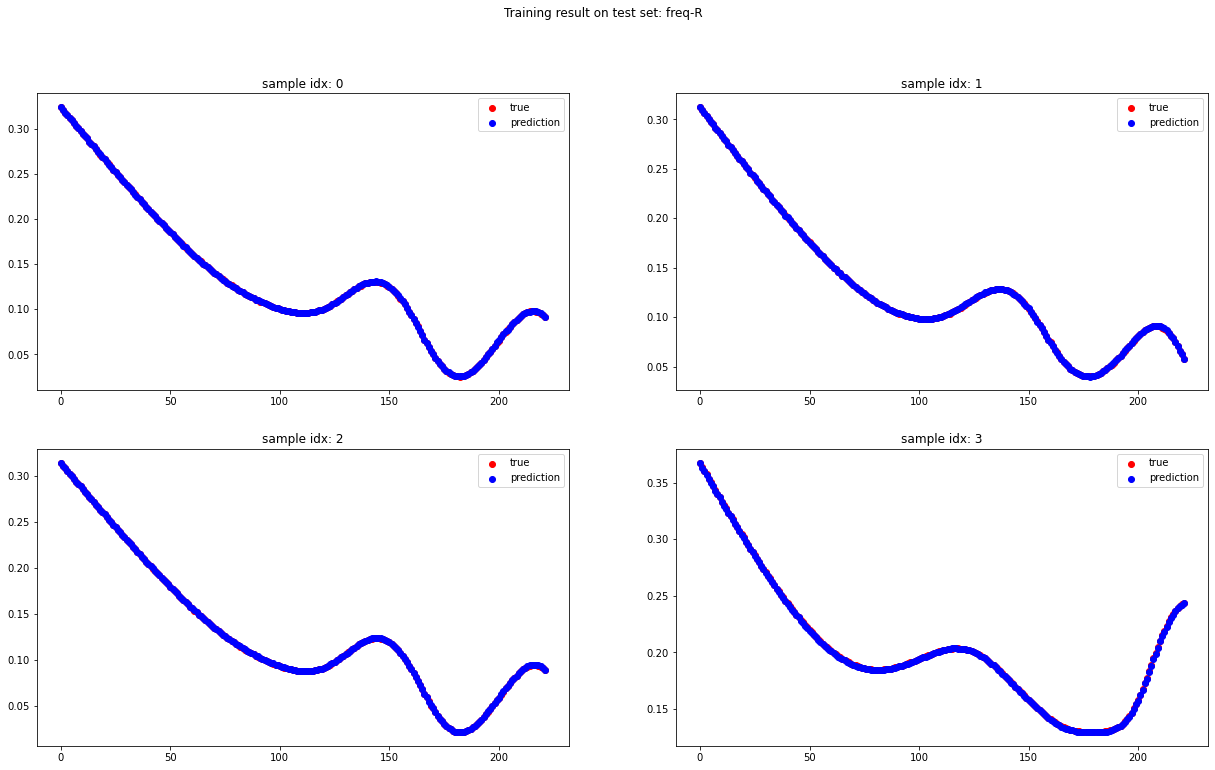

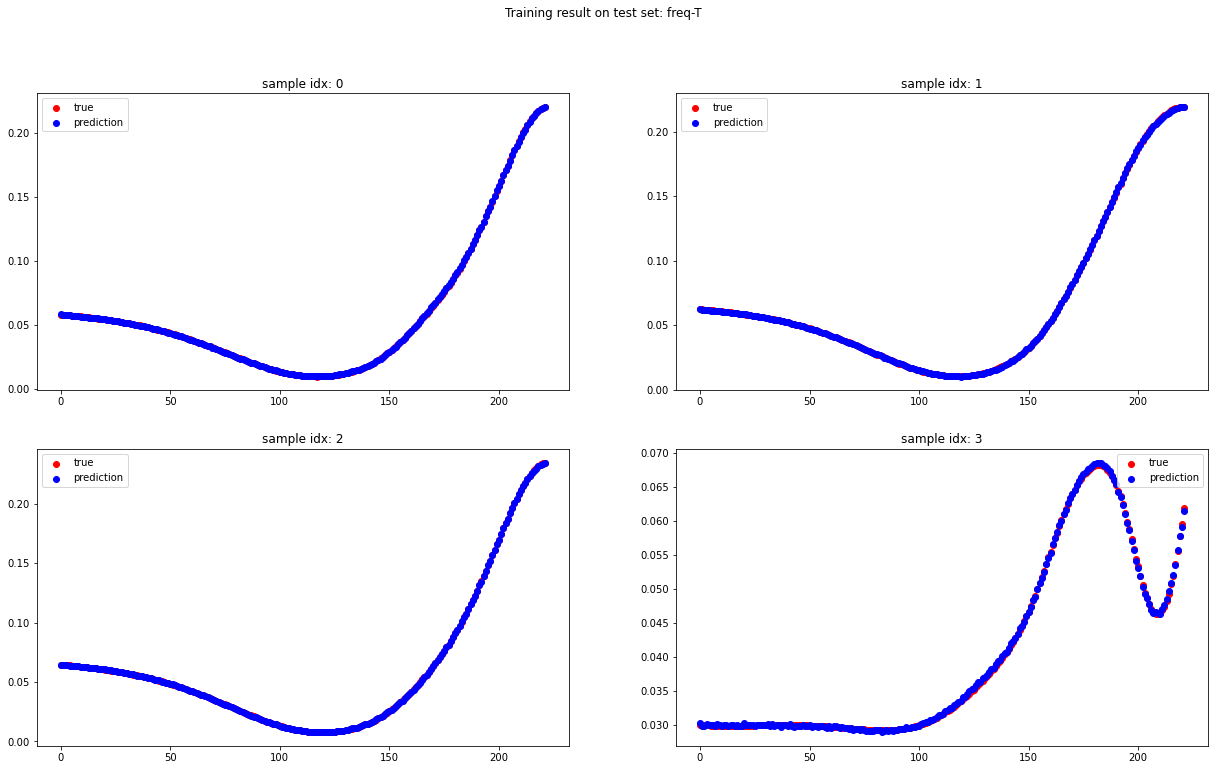

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

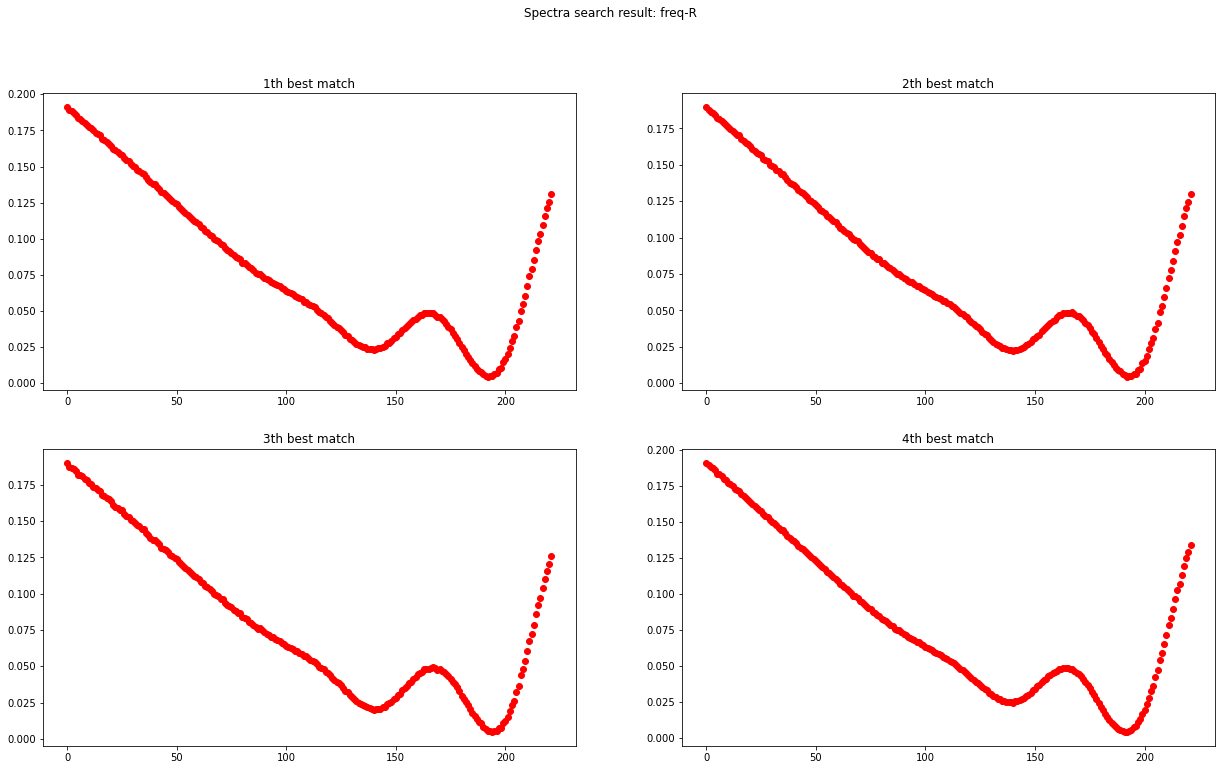

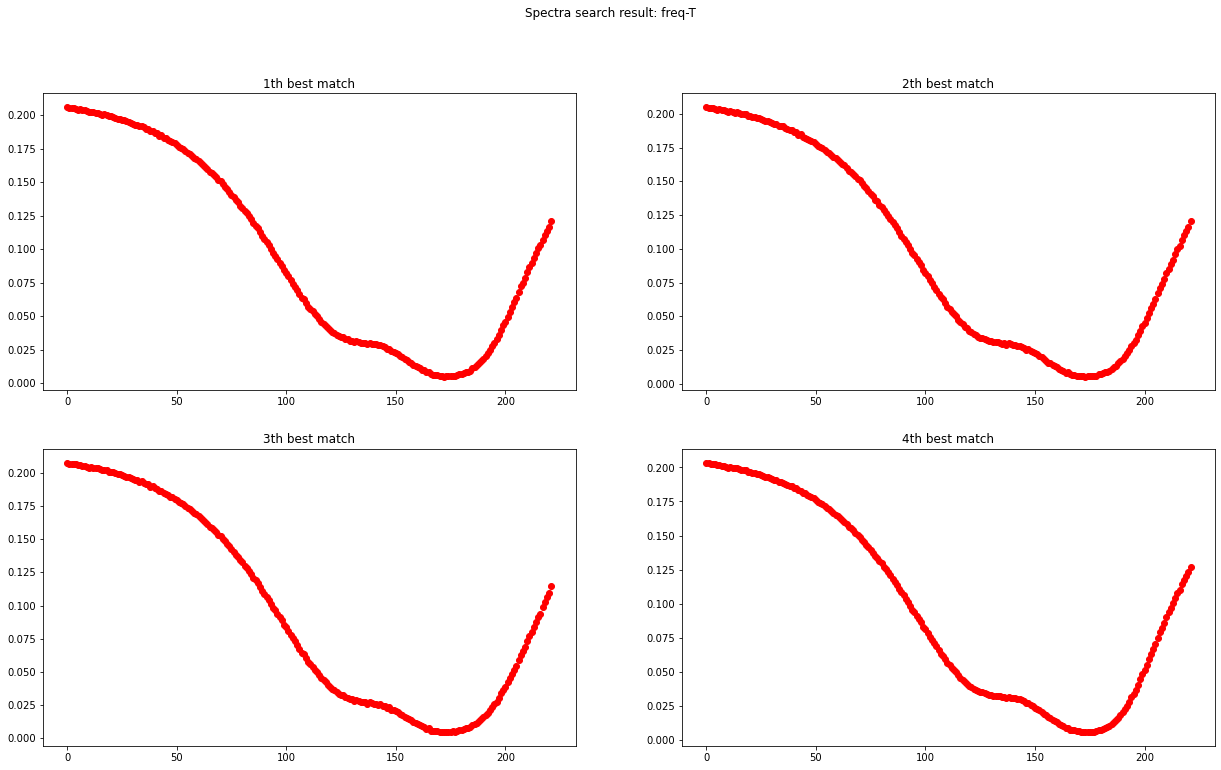

params_pick_visual.shape: (10, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (200, 4)
R_dict.shape: (200, 222)
T_dict.shape: (200, 222)
--------------------
1 th match
Not in the dict, calling RCWA...
# params_pick: [149. 132. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
2 th match
Not in the dict, calling RCWA...
# params_pick: [150. 132. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [149. 133. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Not in the dict, calling RCWA...
# params_pick: [150. 131. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
5 th match
Not in the dict, calling RCWA...
# params_pick: [150. 133. 160.  75.]
Freq truncate.
freq

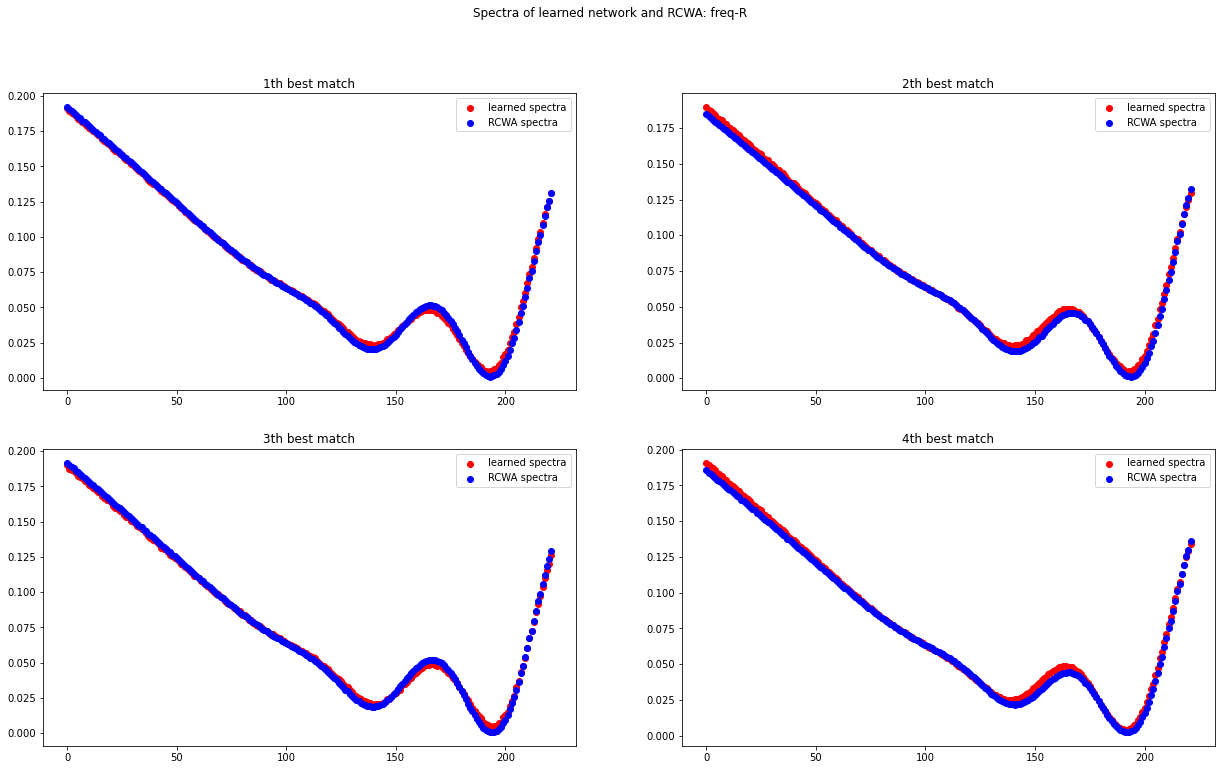

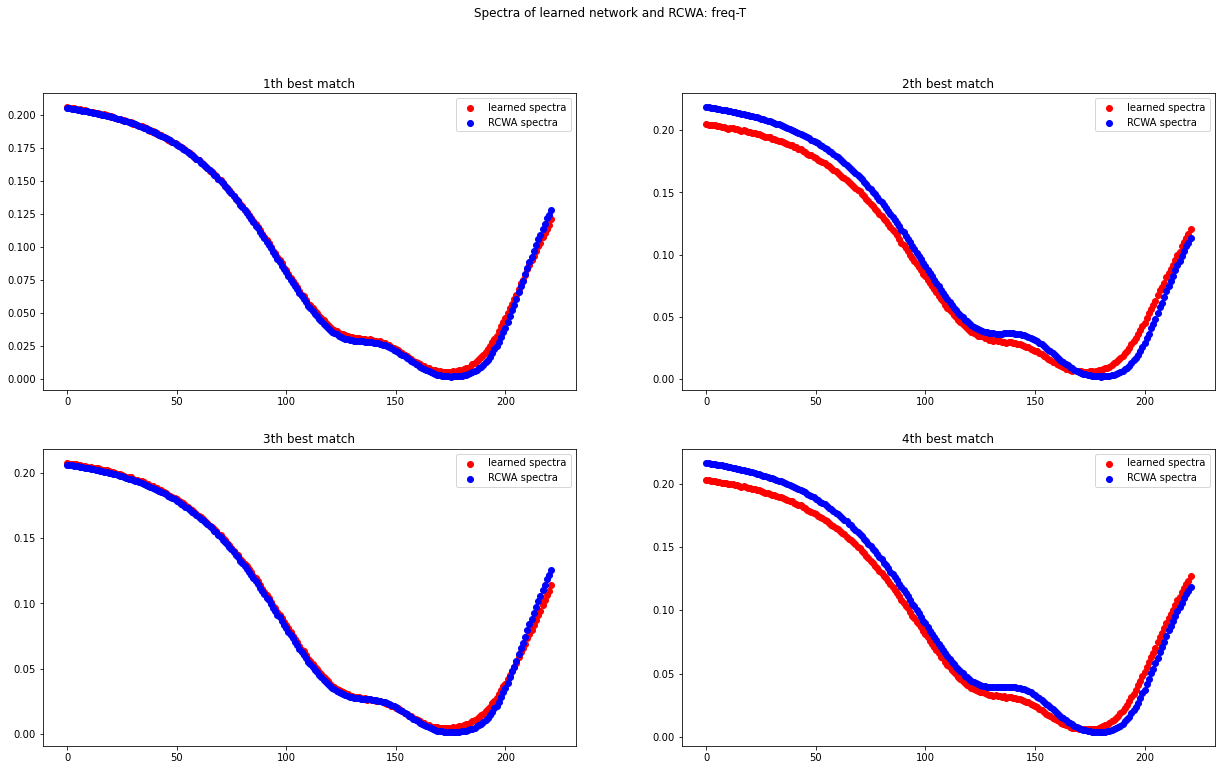

** Model saved.
**************************** ROUND 2 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 400
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [104. 106.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [111.  78.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [117.  75.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [67. 66.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [81. 86.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [146. 105.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [85. 93.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 93. 135.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [ 66. 114.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [140.  83.]
Calculation Prog

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [105. 120.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [113. 119.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [129. 122.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [115. 149.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [117. 129.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [106.  66.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [150. 122.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [87. 96.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [131. 102.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [56. 51.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 67. 135.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 51. 119.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00030464000484698773
### TEST LOSS  0.0006337638478726149
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.00015532329467760064
### TEST LOSS  5.514052099897526e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 4.8412288609824824e-05
### TEST LOSS  0.00010060964268632233
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 5.6564266944860716e-05
### TEST LOSS  3.106807586542951e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 0.00012986332824084458
### TEST LOSS  8.249053401717295e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 7.179941398050005e-05
### TEST LOSS  3.2694767469365615e-05
---------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.8846740803581953e-05
### TEST LOSS  6.971137205861548e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 6.741684978806007e-06
### TEST LOSS  4.170163341162454e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 8.967479544708112e-06
### TEST LOSS  5.896746415601228e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 6.284629689474741e-06
### TEST LOSS  1.0035934792540502e-05
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 5.026045089664421e-06
### TEST LOSS  5.082164155586118e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 4.434199552605378e-06
### TEST LOSS  3.1572263499886808e-06
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 2.0033264197749646e-06
### TEST LOSS  1.1971932849519362e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.2992542032108644e-06
### TEST LOSS  9.487682746112114e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.8209742794894624e-06
### TEST LOSS  1.062199061152569e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.5182236211686019e-06
### TEST LOSS  7.659743630483717e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.0168187184333987e-06
### TEST LOSS  1.3359086210584792e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.0015426279608164e-06
### TEST LOSS  7.966244197632477e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 7.660735330716761e-07
### TEST LOSS  6.491174815437262e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 1.1823485083439778e-06
### TEST LOSS  5.468733850951443e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.68608760139955e-07
### TEST LOSS  5.418613113761239e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 6.895617351077022e-07
### TEST LOSS  5.240980035144579e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.919054886189712e-07
### TEST LOSS  6.66635022146996e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.018962425320297e-07
### TEST LOSS  5.263015244357424e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 6.300202544728962e-07
### TEST LOSS  7.086238251001001e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 6.000114540150036e-07
### TEST LOSS  5.480636957599927e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.160692867140938e-07
### TEST LOSS  5.268061471497276e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.542584511137761e-07
### TEST LOSS  4.431836894506584e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.630402141676427e-07
### TEST LOSS  4.843495275963505e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.458522678480904e-07
### TEST LOSS  8.247060065968981e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.522075597674814e-07
### TEST LOSS  1.0874182597338706e-06
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.508479001292699e-07
### TEST LOSS  5.219364614580021e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.911132571727705e-07
### TEST LOSS  3.8912919819722447e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.3510778777289263e-07
### TEST LOSS  4.1985713039593975e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.5367493714643106e-07
### TEST LOSS  3.7794544975137495e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.1958988612478264e-07
### TEST LOSS  3.826569212606046e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 5.226361224330844e-07
### TEST LOSS  3.5494052970837703e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.030485047985423e-07
### TEST LOSS  6.425983466821587e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 5.927672350658497e-07
### TEST LOSS  4.28732211806467e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.8845575726753624e-07
### TEST LOSS  2.927756336627378e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.9902855638374033e-07
### TEST LOSS  5.401056644889953e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.890971743025773e-07
### TEST LOSS  2.689056515237098e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 6.133671264141327e-07
### TEST LOSS  3.404485748130052e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.023187951940343e-07
### TEST LOSS  4.5077946235020744e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.205299324728685e-07
### TEST LOSS  4.0170759518787236e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 6.225640352752749e-07
### TEST LOSS  9.835490004661551e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 7.24195906229852e-07
### TEST LOSS  6.183156529004918e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.329936504632315e-07
### TEST LOSS  2.5650015326543024e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.594903796333426e-07
### TEST LOSS  5.226516227215446e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.2388575323061274e-07
### TEST LOSS  2.062351427412068e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.0314910656414893e-07
### TEST LOSS  1.4175007171009686e-06
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 4.4885009262252143e-07
### TEST LOSS  2.817129072241187e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.245471805752743e-07
### TEST LOSS  3.340832156103109e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.485204019249011e-07
### TEST LOSS  3.459727745773004e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.500467228079174e-07
### TEST LOSS  3.632649310247871e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.3763152311294677e-07
### TEST LOSS  3.7954040503033565e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.326966723271596e-07
### TEST LOSS  3.0343903745233547e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 2.9511444823882013e-07
### TEST LOSS  2.3794833007665753e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.1341062160628043e-07
### TEST LOSS  2.394677072932912e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.6495722220308837e-07
### TEST LOSS  5.294580679067925e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 2.9351654016629427e-07
### TEST LOSS  3.3595553361465136e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.372479654650817e-07
### TEST LOSS  2.322425961172788e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.0924409233357153e-07
### TEST LOSS  3.351733586972235e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.035994993361157e-07
### TEST LOSS  4.105041995217107e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.1185929386445823e-07
### TEST LOSS  2.3824976835840062e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.167058693342994e-07
### TEST LOSS  3.145984711257673e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.457237149235738e-07
### TEST LOSS  3.273856918895035e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 2.76731377200079e-07
### TEST LOSS  2.154763549810923e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.914086651686134e-07
### TEST LOSS  5.254507205639433e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.806486436985779e-07
### TEST LOSS  2.0907555864368987e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 2.6615895783344e-07
### TEST LOSS  3.2693249825873255e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.9449314907180623e-07
### TEST LOSS  3.1519130535192136e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.0983305448373245e-07
### TEST LOSS  3.551067256542713e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 2.6345172456032627e-07
### TEST LOSS  2.4138527265904486e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 2.9633449922350507e-07
### TEST LOSS  2.2283088677947185e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 2.660498981477133e-07
### TEST LOSS  1.988124769998952e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.838779336489239e-07
### TEST LOSS  2.1317415151618965e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.7434195859044053e-07
### TEST LOSS  2.843765306200415e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 2.709431471181745e-07
### TEST LOSS  4.351545233779082e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.299362608899514e-07
### TEST LOSS  2.3523201283145076e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 2.430703226163899e-07
### TEST LOSS  4.5096128549933684e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 2.853183931783576e-07
### TEST LOSS  1.8820875880010135e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.746450985746662e-07
### TEST LOSS  2.3539090439802143e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 2.2477044649527046e-07
### TEST LOSS  2.2173735203523393e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 2.918575374177834e-07
### TEST LOSS  2.318847170575585e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.627456061838785e-07
### TEST LOSS  2.3923655826744533e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.613887872244703e-07
### TEST LOSS  2.279111489163673e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.029537343124389e-07
### TEST LOSS  1.6702597112801718e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 2.698139159207358e-07
### TEST LOSS  2.622720955969271e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.2934247449590827e-07
### TEST LOSS  1.805339688113842e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 2.31805841153232e-07
### TEST LOSS  1.5019369688692072e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 2.192497483832767e-07
### TEST LOSS  1.9351293190084107e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 2.1842600066435126e-07
### TEST LOSS  1.7000860926449e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.0543631877932854e-07
### TEST LOSS  3.7363203375662124e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 2.6736571599350613e-07
### TEST LOSS  1.9222398606189017e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 2.7742724248547293e-07
### TEST LOSS  1.7788236306159888e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.359942490759437e-07
### TEST LOSS  2.467063022019526e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 2.8442925104954496e-07
### TEST LOSS  2.494576728887902e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.2010013488227288e-07
### TEST LOSS  1.6190481962515454e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.137579316714323e-07
### TEST LOSS  1.739118242009378e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.878164551756157e-07
### TEST LOSS  3.702764104218659e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.2779480751022874e-07
### TEST LOSS  1.481346174614373e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.2143326276591323e-07
### TEST LOSS  2.1018705117133626e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.4713500383910515e-07
### TEST LOSS  1.6519245823095238e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.1131797991458257e-07
### TEST LOSS  2.3506706980924719e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 1.9704929663966197e-07
### TEST LOSS  1.7344828743640997e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.810973898537128e-07
### TEST LOSS  2.253034902347887e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.7086411812149437e-07
### TEST LOSS  1.7869736505341885e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.654392433942832e-07
### TEST LOSS  1.8727485932383084e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.309268467965865e-07
### TEST LOSS  1.542730506306119e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.3890994545805453e-07
### TEST LOSS  3.1005314345596463e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.161689635160613e-07
### TEST LOSS  2.618307301342308e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.676622303443565e-07
### TEST LOSS  1.8392574456053504e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.770420941899943e-07
### TEST LOSS  1.8428233280095205e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.40249723635344e-07
### TEST LOSS  1.790581691807347e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.016825457840099e-07
### TEST LOSS  2.61595774967797e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.361869979106146e-07
### TEST LOSS  2.5707257359878594e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.396637838719684e-07
### TEST LOSS  3.7049859713533806e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.7337396681481605e-07
### TEST LOSS  1.888780995310905e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.220686244225334e-07
### TEST LOSS  3.626633381751769e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.2162867083785897e-07
### TEST LOSS  2.1093332473280194e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 1.9274645546740743e-07
### TEST LOSS  3.4710907215185216e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.4873433538630254e-07
### TEST LOSS  3.0455220212388667e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 1.9890793330645807e-07
### TEST LOSS  1.226554798468745e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.343830866458063e-07
### TEST LOSS  2.571026650836454e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.5216805727978907e-07
### TEST LOSS  1.8453575023613666e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.4436446873998816e-07
### TEST LOSS  2.041130168587794e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.5552937141792855e-07
### TEST LOSS  1.5649033239621227e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.1955836857046051e-07
### TEST LOSS  1.9040877674569856e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 1.8715366535637655e-07
### TEST LOSS  1.6462136187556098e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.016154666906189e-07
### TEST LOSS  7.43650862962871e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.386974649626339e-07
### TEST LOSS  2.1742860667472996e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 1.6319281018084553e-07
### TEST LOSS  1.2616742850468654e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.1332528117756767e-07
### TEST LOSS  1.8779911670208094e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 1.9986741309097056e-07
### TEST LOSS  4.953183747602452e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.324678406528946e-07
### TEST LOSS  1.6018831890581472e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 1.9863839483491575e-07
### TEST LOSS  1.7152842464914406e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.188955322601771e-07
### TEST LOSS  1.2735115006989872e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 1.9134786215957434e-07
### TEST LOSS  1.2875736861891104e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 1.9519160666447987e-07
### TEST LOSS  3.1202900174776005e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.1101806120693568e-07
### TEST LOSS  1.4793362860624862e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 1.9179604625829683e-07
### TEST LOSS  1.2675947047569025e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.1214601311658754e-07
### TEST LOSS  1.8340784180281844e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 1.9604129346095788e-07
### TEST LOSS  1.0853267558748787e-07
----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 1.744498041356124e-07
### TEST LOSS  1.3053770449763155e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 1.9093071186304654e-07
### TEST LOSS  2.7026278341206006e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.0404804488727279e-07
### TEST LOSS  1.2778780463425696e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 1.67910352106837e-07
### TEST LOSS  1.8373610307283647e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 1.8940396512512336e-07
### TEST LOSS  2.331326361589466e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 1.511402120080163e-07
### TEST LOSS  1.9413155645982746e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 1.728565325898046e-07
### TEST LOSS  2.65848309292475e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 1.727279779784041e-07
### TEST LOSS  1.729222181741837e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 1.9409940269721203e-07
### TEST LOSS  1.2652911962618418e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 1.8578691441728522e-07
### TEST LOSS  1.420862953220118e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.4749036258153724e-07
### TEST LOSS  1.9335006603190172e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.0794998286888245e-07
### TEST LOSS  1.865691672264802e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 1.8986477379412392e-07
### TEST LOSS  1.1859193686329188e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 1.6964156052790002e-07
### TEST LOSS  1.9184325357931206e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 1.50970822780927e-07
### TEST LOSS  1.519329586585627e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.0488019657705082e-07
### TEST LOSS  1.3864851785190999e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 1.6021893539885923e-07
### TEST LOSS  1.5709330961991933e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 1.6620023710167686e-07
### TEST LOSS  1.473357258419128e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.0850291423180068e-07
### TEST LOSS  1.5199155948645662e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.206344603017385e-07
### TEST LOSS  2.3401826609870113e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 1.5380575361323422e-07
### TEST LOSS  2.5123905563380805e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 1.976467340458754e-07
### TEST LOSS  2.004547733728638e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.0858972554549382e-07
### TEST LOSS  2.524152454460212e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.2659750345432883e-07
### TEST LOSS  1.408314200072406e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.366014927623894e-07
### TEST LOSS  1.3593500132932e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.5608828459589004e-07
### TEST LOSS  1.0631640634528594e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.157191547613735e-07
### TEST LOSS  1.7082247912488432e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 1.6980612597805588e-07
### TEST LOSS  1.4243386440663622e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 1.9583359135655341e-07
### TEST LOSS  1.332192714661081e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 1.6906507294134343e-07
### TEST LOSS  1.230189046926474e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.0272063598891777e-07
### TEST LOSS  2.45920065348552e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.420358181609572e-07
### TEST LOSS  1.890523719794146e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.0596904785286085e-07
### TEST LOSS  1.7268636772390286e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 1.539488468793593e-07
### TEST LOSS  1.336975046228872e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 1.6390001421839885e-07
### TEST LOSS  1.388196319377736e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.253723228218263e-07
### TEST LOSS  1.7349452955765324e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 1.44045520813485e-07
### TEST LOSS  2.28034911250082e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 1.714259187668432e-07
### TEST LOSS  1.0546728764400844e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 1.611549396995926e-07
### TEST LOSS  1.0392594636717452e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 1.7903521229101216e-07
### TEST LOSS  1.1275645661612543e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 1.8358182200861607e-07
### TEST LOSS  1.3463453285567084e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 1.9494614031057012e-07
### TEST LOSS  2.3414078024567667e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 1.471960617838164e-07
### TEST LOSS  1.7175233087603678e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 1.6684154318102885e-07
### TEST LOSS  3.4613513832937315e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.123979214196936e-07
### TEST LOSS  3.5057321431016436e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.0557189503556117e-07
### TEST LOSS  4.205060264439453e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 1.7266598565601753e-07
### TEST LOSS  2.2617105344124866e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.6541345379337285e-07
### TEST LOSS  2.855145927090537e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 1.9017312251179418e-07
### TEST LOSS  1.3448758788096407e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 1.4434572262356227e-07
### TEST LOSS  1.184144942101284e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.2538618154044344e-07
### TEST LOSS  2.540077754057772e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.1557386653103805e-07
### TEST LOSS  1.364756260594883e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 1.7388698929643455e-07
### TEST LOSS  1.629240055459983e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 1.573779735730696e-07
### TEST LOSS  1.909545280417054e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.0769883044557957e-07
### TEST LOSS  1.6428425908543431e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 1.658962339901038e-07
### TEST LOSS  1.374537520841083e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 1.630832876031718e-07
### TEST LOSS  1.3242475086864639e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 1.6070066594764398e-07
### TEST LOSS  1.3263986649765988e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 1.992119893401423e-07
### TEST LOSS  1.8767065768088287e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.0197181971326472e-07
### TEST LOSS  1.0861682990063552e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 1.7964357179600654e-07
### TEST LOSS  2.2945692042715868e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 1.742064661103271e-07
### TEST LOSS  1.3286549223797314e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 1.807205799231326e-07
### TEST LOSS  1.4455264126430242e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 1.3785098681662334e-07
### TEST LOSS  1.232512261140073e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 1.8074729483785744e-07
### TEST LOSS  1.0225411391691826e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 1.474534501721969e-07
### TEST LOSS  1.4626300763135683e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 1.6114873392147898e-07
### TEST LOSS  1.33159577586639e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 1.7155602483942544e-07
### TEST LOSS  3.029657117773847e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.782019440023987e-07
### TEST LOSS  2.4036932207612455e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 1.6228252714967083e-07
### TEST LOSS  1.808448075735214e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 1.6451224408964292e-07
### TEST LOSS  2.446100329696795e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.0665468527525377e-07
### TEST LOSS  3.417667784333389e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 1.3651668978376108e-07
### TEST LOSS  1.0435465114255749e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 1.776411784515375e-07
### TEST LOSS  1.3162578227365884e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 1.571284339751955e-07
### TEST LOSS  1.0307275625602112e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 1.993488540241728e-07
### TEST LOSS  9.817547308443864e-08
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 1.5942801805834961e-07
### TEST LOSS  1.32582614516726e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 1.549394074995547e-07
### TEST LOSS  1.1800574502747925e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 1.8290274722776445e-07
### TEST LOSS  1.0152519299329772e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.0608599089033674e-07
### TEST LOSS  1.6839460907173512e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 1.5715325490939236e-07
### TEST LOSS  1.1505492854742745e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 1.7125371689630243e-07
### TEST LOSS  2.3637006307808406e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 1.8845221203989126e-07
### TEST LOSS  1.3910053553445323e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 1.896056950956293e-07
### TEST LOSS  1.3773778325306316e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 1.7725240620602988e-07
### TEST LOSS  1.545966862674201e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 1.2740310083358965e-07
### TEST LOSS  1.0386317820613537e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 1.345870889934986e-07
### TEST LOSS  2.7599230634223204e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 1.6211131664611855e-07
### TEST LOSS  1.5383683778698773e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 1.2456930548410128e-07
### TEST LOSS  1.0110376417552895e-07
** loss_train 1.2456930548410128e-07
** loss_test 1.0110376417552895e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


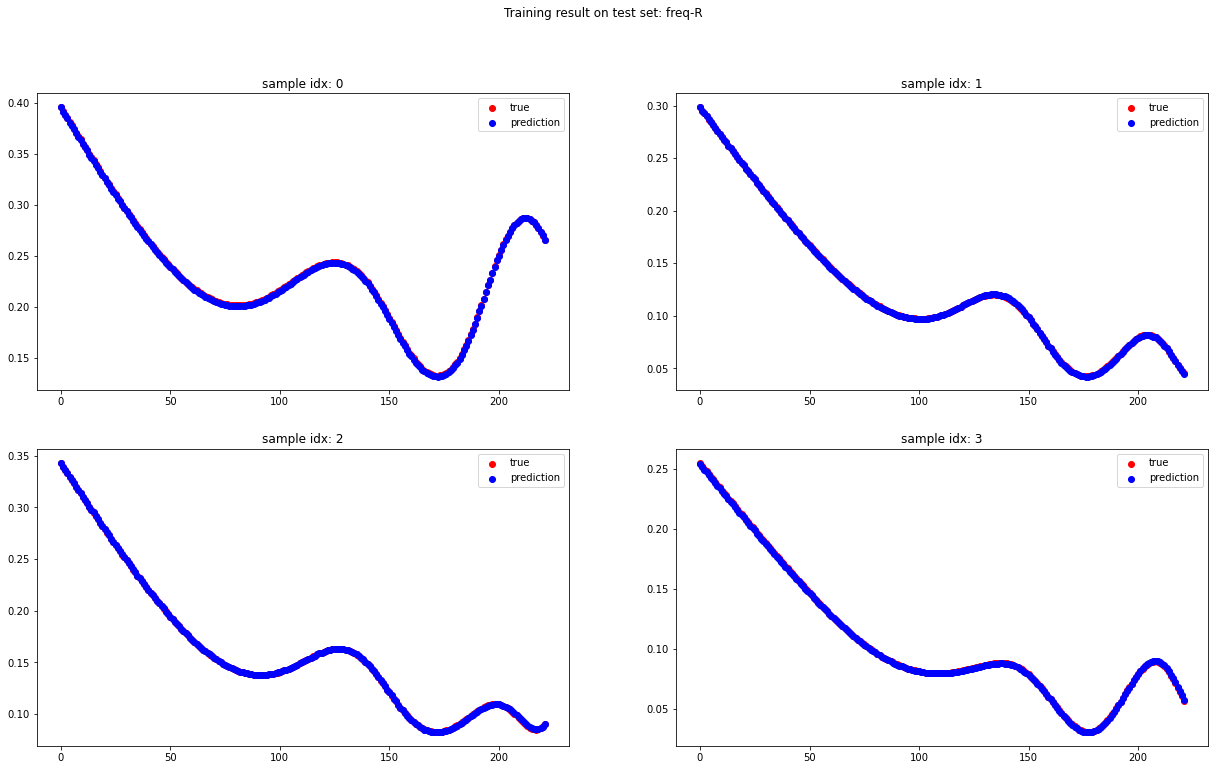

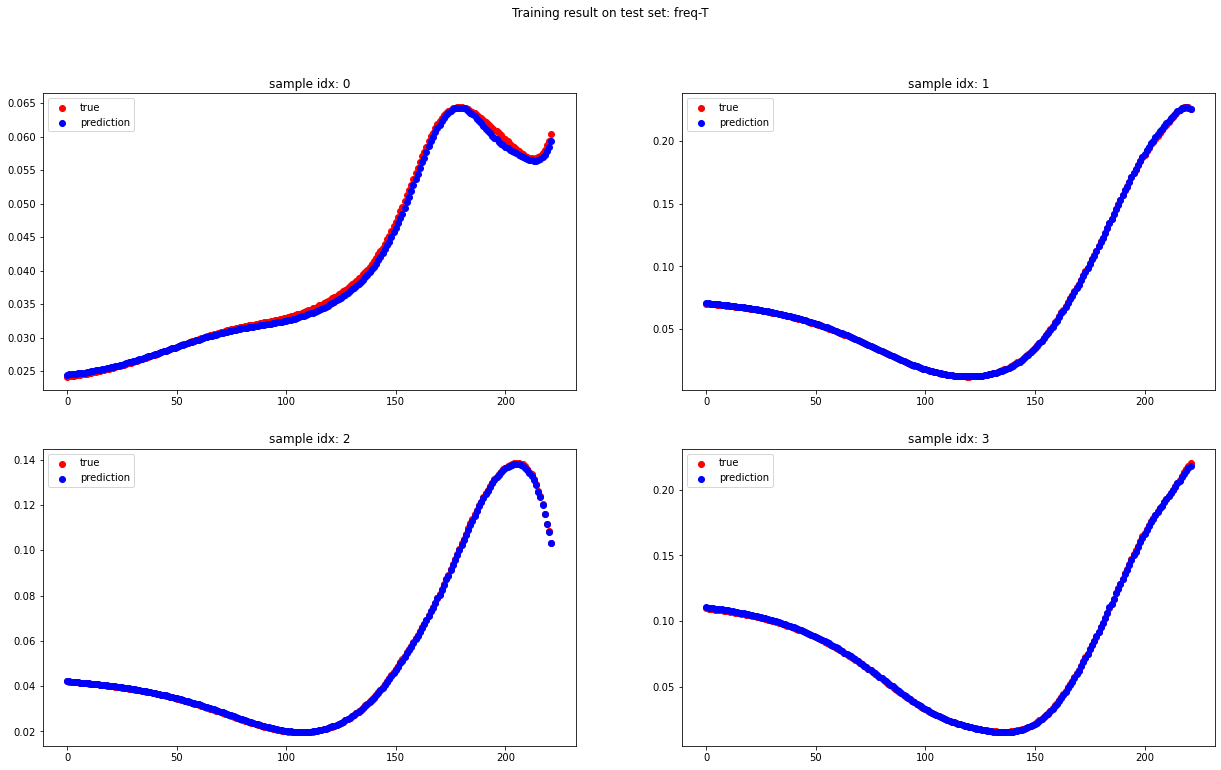

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

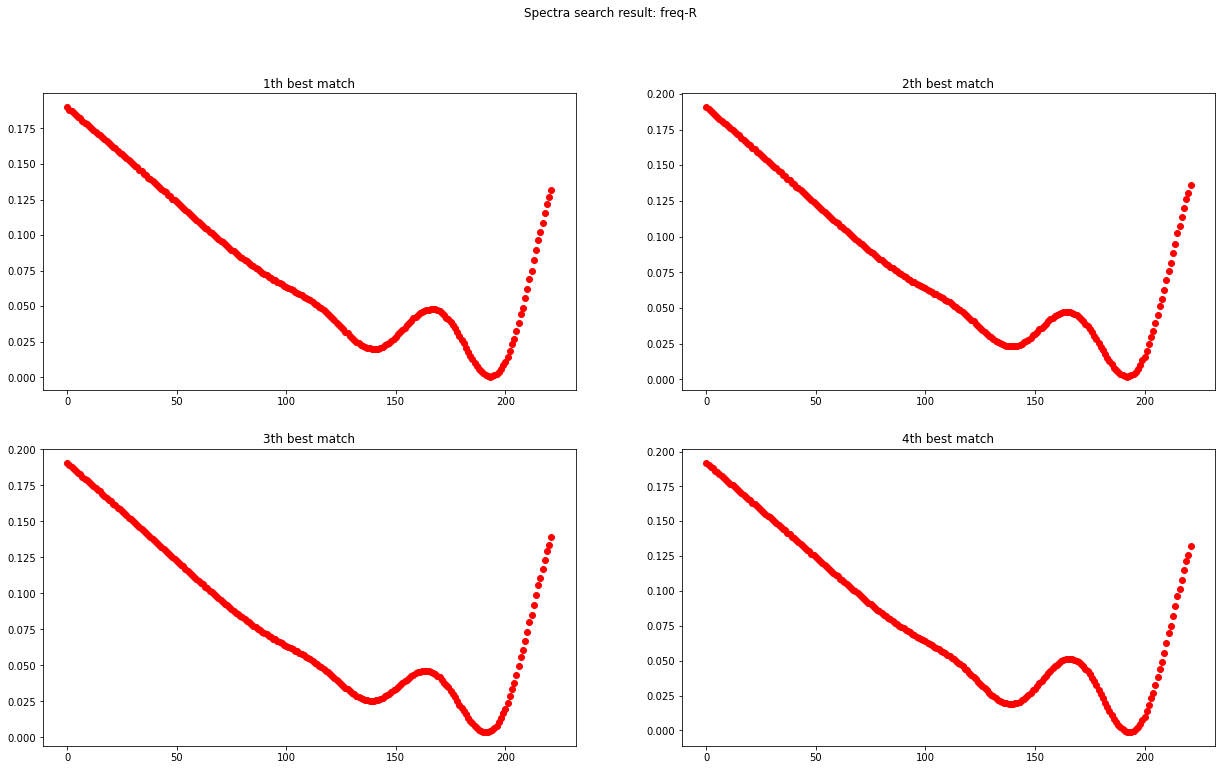

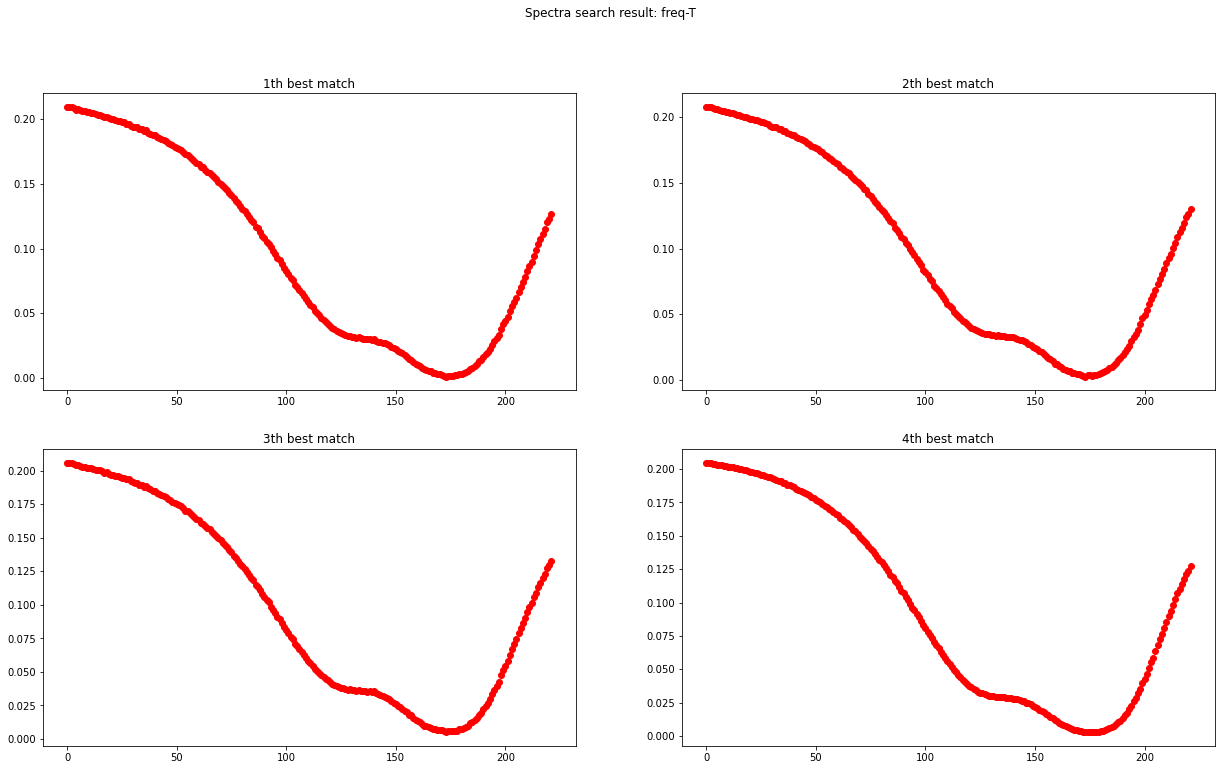

params_pick_visual.shape: (20, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (410, 4)
R_dict.shape: (410, 222)
T_dict.shape: (410, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [150. 132. 160.  75.] params_pick: [150. 132. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [150. 131. 160.  75.] params_pick: [150. 131. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [150. 130. 160.  75.] params_pick: [150. 130. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [149. 132. 160.  75.] params_pick: [149. 132. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [150. 133. 160.  75.] params_pick: [150. 133. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [149. 131. 160.  75.] params_pick: [149. 131. 160.  75.]
--------------------
7 th match
Not in the dict, calling RCWA..

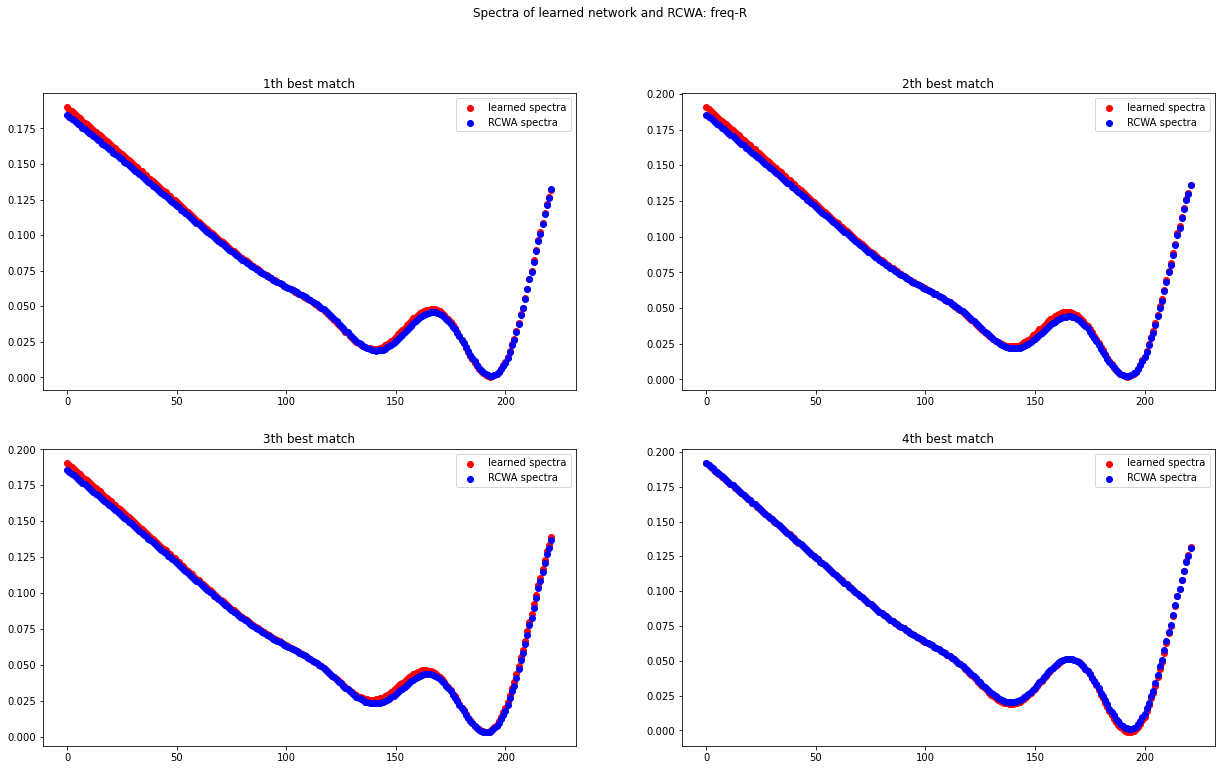

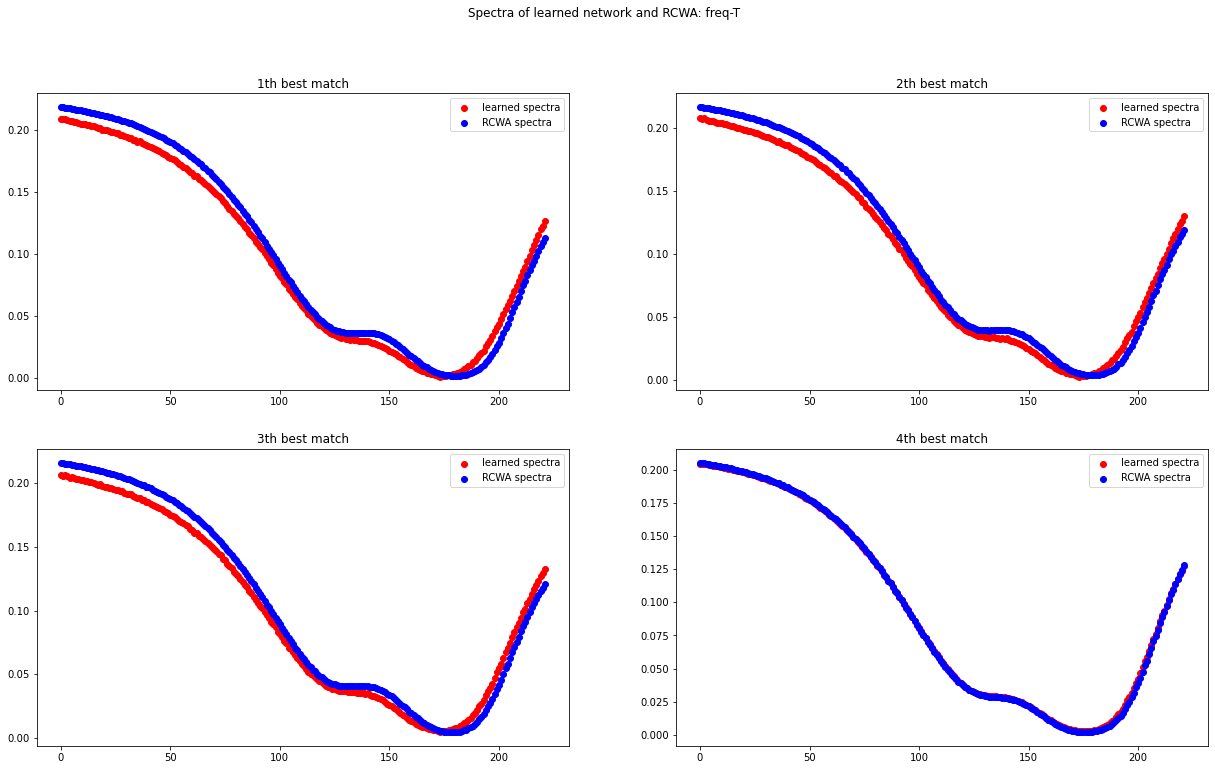

** Model saved.
**************************** ROUND 3 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 600
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [95. 66.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 79. 100.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [105.  55.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 69. 141.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 81. 103.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [125. 144.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [143. 124.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [92. 61.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [112. 131.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [70. 58.]
Calculation Prog

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 91. 124.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [128.  70.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [65. 92.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [120. 114.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [143. 137.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [96. 91.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [126. 133.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 61. 103.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [55. 67.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [51. 56.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 54. 129.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [120. 123.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00015577811172155028
### TEST LOSS  0.00021222571700087024
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 6.640777369909756e-05
### TEST LOSS  1.812327344749873e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 1.9080079182837533e-05
### TEST LOSS  1.6676208259822386e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 3.95308045811286e-05
### TEST LOSS  2.0921840182887132e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.5207953124208872e-05
### TEST LOSS  1.5067363064089375e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 2.2289779001501604e-05
### TEST LOSS  1.801887730026566e-05
---------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 4.7165713543980326e-06
### TEST LOSS  2.2236534328435987e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 3.0280339382926513e-06
### TEST LOSS  3.978305850675194e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.3693378386723983e-05
### TEST LOSS  4.718343411190694e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 3.6476672533799124e-06
### TEST LOSS  1.8795764920772247e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.4176757828323994e-06
### TEST LOSS  3.8635671949628486e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 3.174108153724357e-06
### TEST LOSS  4.774330616581008e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 8.590331522147683e-07
### TEST LOSS  8.691478051837798e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 8.482682846514914e-07
### TEST LOSS  6.040100023104363e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.1230044534826788e-06
### TEST LOSS  1.457845889439745e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.7640804245881252e-06
### TEST LOSS  7.711962616162459e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.1290199623085566e-06
### TEST LOSS  2.0321545864337368e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 9.767550354548386e-07
### TEST LOSS  6.196166471757655e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 8.977139188992566e-07
### TEST LOSS  7.581571266099571e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 8.060619181667524e-07
### TEST LOSS  5.244128828962857e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 8.522765900901656e-07
### TEST LOSS  7.904769429640307e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 7.809861543961461e-07
### TEST LOSS  1.2446085217258467e-06
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 7.178364256314277e-07
### TEST LOSS  6.627942197054734e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 6.468007745160283e-07
### TEST LOSS  6.493363255483725e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 6.32373537274115e-07
### TEST LOSS  5.374820691233456e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.726920783584906e-07
### TEST LOSS  5.219170525884288e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 1.0392961734595475e-06
### TEST LOSS  7.295644005959426e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.282808075989503e-07
### TEST LOSS  8.535135912603032e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 7.621618955866438e-07
### TEST LOSS  7.228616141219391e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.669654581907934e-07
### TEST LOSS  4.485473476102521e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.374668028797676e-07
### TEST LOSS  5.146315579117477e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.972013741640543e-07
### TEST LOSS  4.534663307569847e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.2082049181620583e-07
### TEST LOSS  4.016931585384656e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.121642896455114e-07
### TEST LOSS  3.6920765940825123e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.054854435745862e-07
### TEST LOSS  3.338876916182522e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.779281210749331e-07
### TEST LOSS  5.134258679441296e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 6.03764122792209e-07
### TEST LOSS  4.951955456059901e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.892655435661235e-07
### TEST LOSS  4.2996696455096145e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 5.124973140742857e-07
### TEST LOSS  6.337283543366034e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 5.699671359593594e-07
### TEST LOSS  6.672596113175031e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.822594896284708e-07
### TEST LOSS  4.3731871654826034e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.473391510610251e-07
### TEST LOSS  4.270384768763809e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.5389673801447355e-07
### TEST LOSS  4.249702859245493e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.8243412040728233e-07
### TEST LOSS  7.938007860906914e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.0621347449013946e-07
### TEST LOSS  3.0789719731829894e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 4.3307712353168883e-07
### TEST LOSS  3.732741807501346e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.8293364612584924e-07
### TEST LOSS  3.689687307289407e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.566619407952999e-07
### TEST LOSS  3.126522503609724e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.933447604275424e-07
### TEST LOSS  3.456908485885732e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.491621040000818e-07
### TEST LOSS  2.2919966606120093e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.461246386770294e-07
### TEST LOSS  3.0531991354918216e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 4.584472365820602e-07
### TEST LOSS  2.999720247013708e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.0376601749159137e-07
### TEST LOSS  4.5952104857052393e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.7868820829937514e-07
### TEST LOSS  3.8713507895712e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.6810828811203087e-07
### TEST LOSS  2.6285535960192243e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.6022671994354976e-07
### TEST LOSS  2.5004227508260453e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.031709055517789e-07
### TEST LOSS  7.393910992606026e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.0004415816715287e-07
### TEST LOSS  3.140964237344532e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.296494710447462e-07
### TEST LOSS  3.985078680873105e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.5064971607426214e-07
### TEST LOSS  2.282300704968697e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.3776992326058537e-07
### TEST LOSS  2.407339347125041e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.380767279518674e-07
### TEST LOSS  2.844368083287918e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.851660323454335e-07
### TEST LOSS  5.151980467922435e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.3386169895261636e-07
### TEST LOSS  3.507740681622333e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.870010899298393e-07
### TEST LOSS  3.6147143115764874e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.118935496559099e-07
### TEST LOSS  4.304331090073295e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.4090094843008954e-07
### TEST LOSS  2.4498218604346926e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.446109393253257e-07
### TEST LOSS  2.6534739245360265e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.172005201671861e-07
### TEST LOSS  2.5881435148120443e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.985411771246523e-07
### TEST LOSS  2.2935309118565783e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 2.7939065597948345e-07
### TEST LOSS  1.8901605219273026e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.240478048264587e-07
### TEST LOSS  4.222865028522291e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 5.209785858776664e-07
### TEST LOSS  4.151126612820614e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.196359218667529e-07
### TEST LOSS  2.3797591887210325e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.391524337933068e-07
### TEST LOSS  3.436096941792736e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.168822168161019e-07
### TEST LOSS  2.2398794720225447e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.233374424619721e-07
### TEST LOSS  2.0681989888594722e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.6863510091578175e-07
### TEST LOSS  2.5962929820858943e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.434491367118672e-07
### TEST LOSS  2.2252176910973907e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.304847263911152e-07
### TEST LOSS  4.662223950112497e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.004852405178819e-07
### TEST LOSS  2.7583549903435295e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.1109093750814054e-07
### TEST LOSS  2.5323115930101875e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.4459054402719765e-07
### TEST LOSS  4.0106615668062455e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.4150640048006647e-07
### TEST LOSS  2.5881692522489175e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.4105413321938726e-07
### TEST LOSS  3.830209765156825e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 2.804899365275541e-07
### TEST LOSS  2.4668606594483816e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.7826383128963056e-07
### TEST LOSS  6.218465892339332e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.1679616863418876e-07
### TEST LOSS  2.243565546677928e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.487153934322862e-07
### TEST LOSS  2.4058610708582114e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.0038397261122893e-07
### TEST LOSS  2.928098612958113e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.1369539740329816e-07
### TEST LOSS  2.194194605762176e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.151868224193777e-07
### TEST LOSS  5.084682123247653e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.145271474735978e-07
### TEST LOSS  3.93373641019126e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.467401492033654e-07
### TEST LOSS  2.2529084415307605e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.2080815022557846e-07
### TEST LOSS  2.5937754502239034e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 2.7466350819812155e-07
### TEST LOSS  1.9360741671587473e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.794129097537772e-07
### TEST LOSS  2.2004295866887938e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 2.419280581023031e-07
### TEST LOSS  2.1969282373548697e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.6479057596849884e-07
### TEST LOSS  3.526868839445443e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 2.5929728297846566e-07
### TEST LOSS  4.019297692694737e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.4470188728642486e-07
### TEST LOSS  2.0614441117080182e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.801144424701401e-07
### TEST LOSS  4.4013414897866215e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.745329644445367e-07
### TEST LOSS  8.117072525237745e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.885056803177595e-07
### TEST LOSS  2.3479626065636694e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.464026070262785e-07
### TEST LOSS  1.5858355892659245e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 2.558905395548076e-07
### TEST LOSS  2.6928574135985804e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.220386297127694e-07
### TEST LOSS  3.038084596735441e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.549448424045882e-07
### TEST LOSS  3.3043082857552184e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.0977959948330635e-07
### TEST LOSS  1.7890919994872294e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.1772157615961305e-07
### TEST LOSS  2.7411753775494515e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.550488551970413e-07
### TEST LOSS  2.000795389120766e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.3146246367270843e-07
### TEST LOSS  1.9368409375096638e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.71260135216167e-07
### TEST LOSS  3.089556280934226e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.3541761617451585e-07
### TEST LOSS  2.964822556350555e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.6207139071606395e-07
### TEST LOSS  2.2318886452568324e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.917113142449542e-07
### TEST LOSS  2.187984856997597e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.553475840135396e-07
### TEST LOSS  1.4000950364510976e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.5073677223967175e-07
### TEST LOSS  2.123690276473806e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.9974160737171e-07
### TEST LOSS  2.1990516232664152e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.8597287520544987e-07
### TEST LOSS  2.9912045502240085e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.517038776428393e-07
### TEST LOSS  2.2836849369569893e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.4858799391698956e-07
### TEST LOSS  3.12232044860947e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.755165070844612e-07
### TEST LOSS  3.307528402274329e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.5016665748426686e-07
### TEST LOSS  4.581684909984081e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.6215107511144236e-07
### TEST LOSS  1.7952682343194385e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.4105500282895683e-07
### TEST LOSS  2.2893644945219825e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.992886739505707e-07
### TEST LOSS  3.4043803035880654e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.896993870770397e-07
### TEST LOSS  2.6037514544441365e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.0863225793709146e-07
### TEST LOSS  3.2040666218967493e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.1553361677853314e-07
### TEST LOSS  3.8221069884356336e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.875988260164775e-07
### TEST LOSS  2.541127707268566e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.6697198276674307e-07
### TEST LOSS  8.193986155270572e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.3712117555400407e-07
### TEST LOSS  1.558217882625791e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.3726599491856745e-07
### TEST LOSS  1.9817014005083263e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.5334236171422237e-07
### TEST LOSS  2.1692725245732922e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.433264518231226e-07
### TEST LOSS  1.92964506595672e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.18419037913975e-07
### TEST LOSS  1.649510987059936e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.068215714838099e-07
### TEST LOSS  1.5231564197569645e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.3233518269864344e-07
### TEST LOSS  2.533742073435658e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.042183798681227e-07
### TEST LOSS  3.705416860258184e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.2396953219446422e-07
### TEST LOSS  1.9188473901168538e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.6840981920628337e-07
### TEST LOSS  1.4949181566710953e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.7483128669736343e-07
### TEST LOSS  2.3383222785216478e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.238787959247702e-07
### TEST LOSS  1.996614366185491e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.0855977777974507e-07
### TEST LOSS  2.3649359566964753e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.1380001769202674e-07
### TEST LOSS  5.127217800943779e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.5500794133511323e-07
### TEST LOSS  3.5430251601711563e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.819708044121683e-07
### TEST LOSS  2.9102704483345104e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.484535361713114e-07
### TEST LOSS  1.7197039407316575e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.093744393712645e-07
### TEST LOSS  1.4816815981551676e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.3021888496307004e-07
### TEST LOSS  2.785648942133573e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.1594943053611833e-07
### TEST LOSS  1.9987345625496448e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.213891281825179e-07
### TEST LOSS  3.9411611712441504e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.3054284102504614e-07
### TEST LOSS  2.0266673554184914e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.3997689342950914e-07
### TEST LOSS  2.2953577330200562e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.528602942578137e-07
### TEST LOSS  2.3968734631630974e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.1254623437420386e-07
### TEST LOSS  2.3205823790956654e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.0776733469887553e-07
### TEST LOSS  1.9506213770152195e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.5816723289532696e-07
### TEST LOSS  2.105743988067843e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.53833438372079e-07
### TEST LOSS  8.948328008450012e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.533188077042837e-07
### TEST LOSS  2.459278726342341e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.6430904282411423e-07
### TEST LOSS  1.8125096169620116e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.447871726118933e-07
### TEST LOSS  1.7214768711760877e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.4654030147175375e-07
### TEST LOSS  1.858647998965858e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.1524726317778686e-07
### TEST LOSS  1.553184903160501e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.3454206947567022e-07
### TEST LOSS  2.3384793242560894e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.3738912387531268e-07
### TEST LOSS  1.9384476009539261e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.6094467371192327e-07
### TEST LOSS  2.0063504280187772e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.2819560032990201e-07
### TEST LOSS  1.8195823593537676e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.1505557556089628e-07
### TEST LOSS  1.6381796620458368e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.59212183362223e-07
### TEST LOSS  1.6331523748173518e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.3518385649919556e-07
### TEST LOSS  1.4008380194102048e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 1.9976029072369765e-07
### TEST LOSS  1.3245469274478535e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.0770041324169596e-07
### TEST LOSS  2.353322704114665e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.496620093624576e-07
### TEST LOSS  2.255602330099767e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.4481359549651435e-07
### TEST LOSS  2.0142969484974552e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 1.8478022604758355e-07
### TEST LOSS  1.5719561948420355e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 1.879130696943084e-07
### TEST LOSS  1.284857707635941e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 1.9933045138328018e-07
### TEST LOSS  4.4471809701462917e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.8351939699670464e-07
### TEST LOSS  3.372396343416363e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.1360330813161946e-07
### TEST LOSS  3.6386761811021035e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.398156192710369e-07
### TEST LOSS  2.5576115092462715e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.1387708789492403e-07
### TEST LOSS  3.330455342620553e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.812746528639091e-07
### TEST LOSS  2.7448519467220143e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.144600853348777e-07
### TEST LOSS  3.11279347581856e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.0034177042660417e-07
### TEST LOSS  1.411479265319334e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.8278372801911665e-07
### TEST LOSS  1.9822551027775464e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.590553095949133e-07
### TEST LOSS  1.7569714335271178e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.7054109211258987e-07
### TEST LOSS  1.5433875056992798e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.228114483286229e-07
### TEST LOSS  1.85133990113526e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.0450917128952047e-07
### TEST LOSS  2.040144045799429e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.2940546275644163e-07
### TEST LOSS  2.8489357677901557e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.2649488660005564e-07
### TEST LOSS  1.8818199186575333e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.2652547190323466e-07
### TEST LOSS  4.414062478493482e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.326955964271349e-07
### TEST LOSS  1.4578302101300426e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 1.8609247597704364e-07
### TEST LOSS  1.3831494843290986e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.087105899336213e-07
### TEST LOSS  2.594333526278408e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.0213393482571006e-07
### TEST LOSS  1.4182309687132349e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.1561093622501914e-07
### TEST LOSS  2.7373635368298386e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 1.8940354986026384e-07
### TEST LOSS  2.479285809739748e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 1.9868453920028155e-07
### TEST LOSS  3.3090476689620925e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.008408986231558e-07
### TEST LOSS  2.2312814154348518e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.2500035303352207e-07
### TEST LOSS  1.4372242497352596e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 1.9980399430963304e-07
### TEST LOSS  1.5898234866856203e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.0883635634127984e-07
### TEST LOSS  3.7986658046267826e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.4360925322615874e-07
### TEST LOSS  2.437625410165209e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.0447773933026288e-07
### TEST LOSS  2.2873443267851852e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.3687939737430478e-07
### TEST LOSS  6.312545224318455e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 3.635290649247243e-07
### TEST LOSS  1.720792871158968e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.171792629734881e-07
### TEST LOSS  1.623428621163233e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.1976606326153577e-07
### TEST LOSS  1.609928861828141e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.159564150912748e-07
### TEST LOSS  1.247093640207216e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.1754278874593544e-07
### TEST LOSS  1.8102288063598988e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.295458655095691e-07
### TEST LOSS  1.3305911434397584e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.5938945319066894e-07
### TEST LOSS  2.0492190028815256e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 1.7946280135738847e-07
### TEST LOSS  2.0518320790567182e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.4441425856854455e-07
### TEST LOSS  1.918399479766069e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.2270765750675992e-07
### TEST LOSS  1.786330917260178e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.5387510703467343e-07
### TEST LOSS  5.243609027477053e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.792414800515767e-07
### TEST LOSS  2.1577582900691698e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.0983581700662057e-07
### TEST LOSS  2.241843506883217e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.392575286513932e-07
### TEST LOSS  1.2537684549821884e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 1.7458843912206608e-07
### TEST LOSS  1.696657076561476e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 1.956358625380498e-07
### TEST LOSS  2.337435647506128e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 3.9971411924651553e-07
### TEST LOSS  3.4761648414082123e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.7092385079067565e-07
### TEST LOSS  3.3567578346567945e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.410463233785502e-07
### TEST LOSS  3.428975629857531e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.3274788349070264e-07
### TEST LOSS  1.302538766228483e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 1.6966550193231455e-07
### TEST LOSS  3.3192445256544386e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.0619233681943664e-07
### TEST LOSS  2.0994491004936813e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 1.813095229241668e-07
### TEST LOSS  2.2773610908188857e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.3825299874028853e-07
### TEST LOSS  5.742665065453265e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.1560929789702735e-07
### TEST LOSS  1.3291933795598095e-07
** loss_train 2.1560929789702735e-07
** loss_test 1.3291933795598095e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


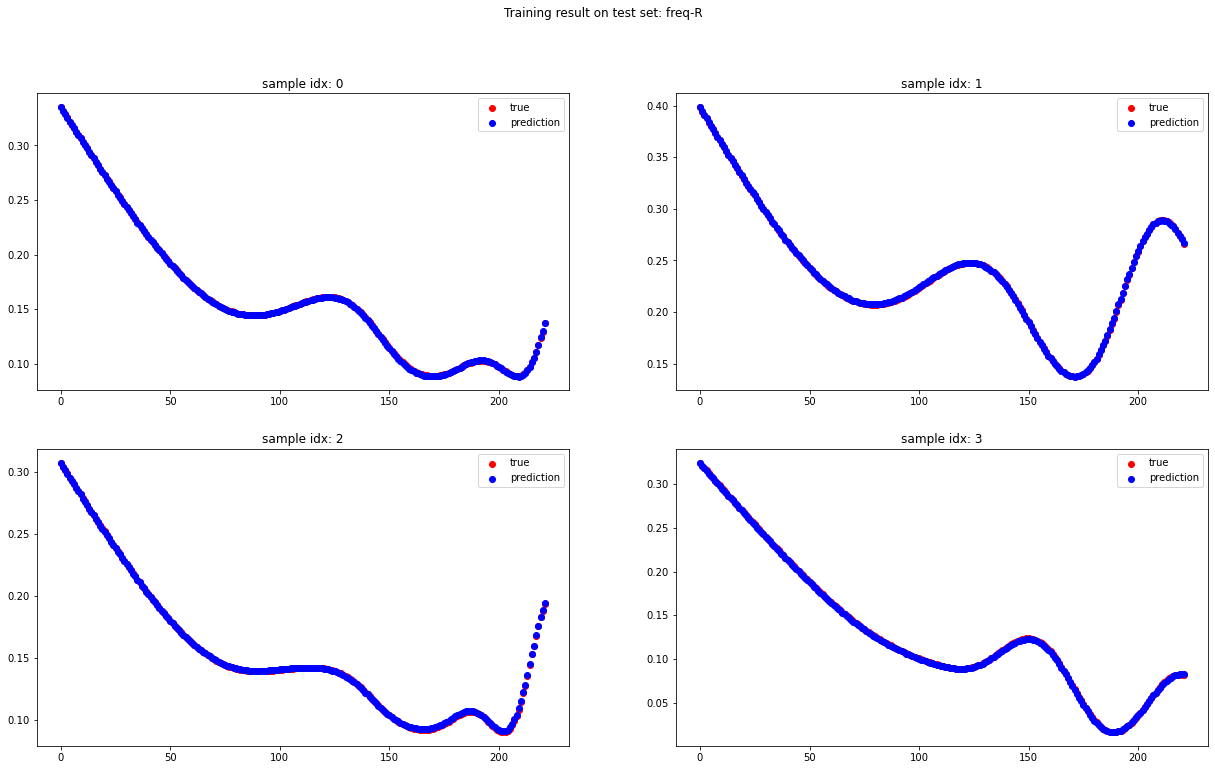

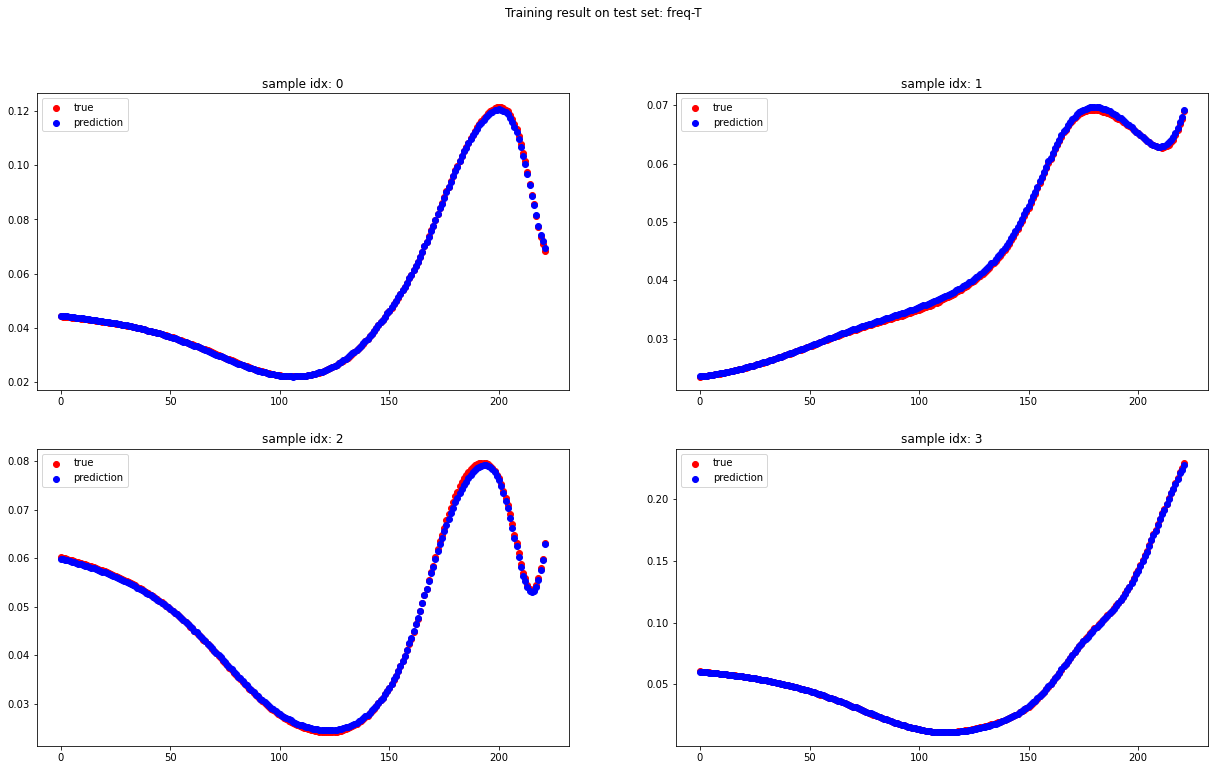

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

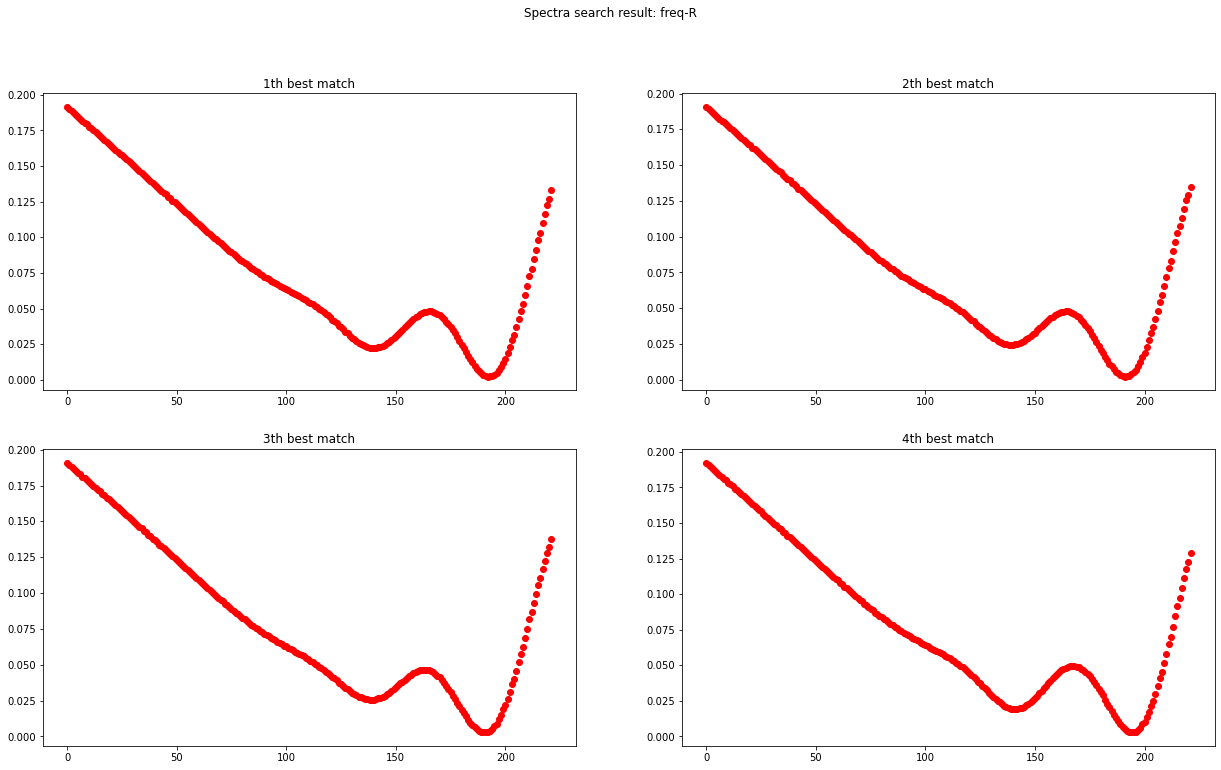

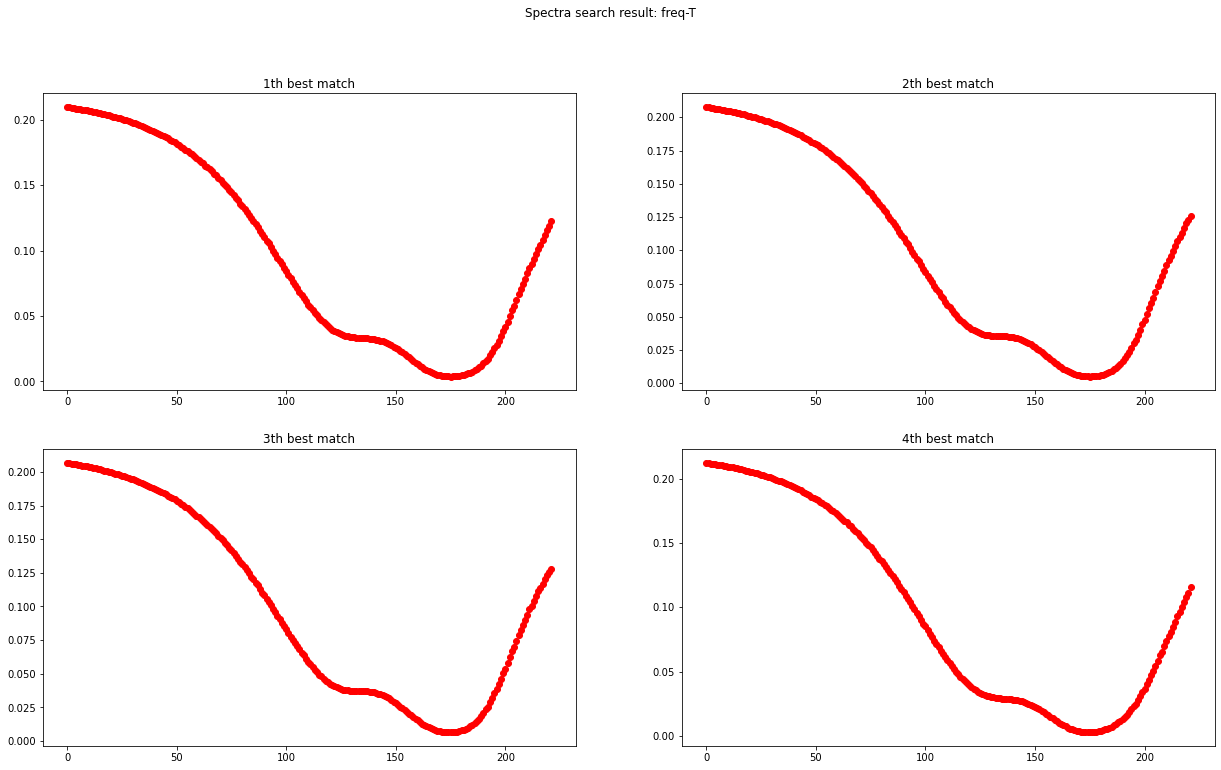

params_pick_visual.shape: (30, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (613, 4)
R_dict.shape: (613, 222)
T_dict.shape: (613, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [150. 132. 160.  75.] params_pick: [150. 132. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [150. 131. 160.  75.] params_pick: [150. 131. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [150. 130. 160.  75.] params_pick: [150. 130. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [150. 133. 160.  75.] params_pick: [150. 133. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [149. 132. 160.  75.] params_pick: [149. 132. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [150. 129. 160.  75.] params_pick: [150. 129. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_d

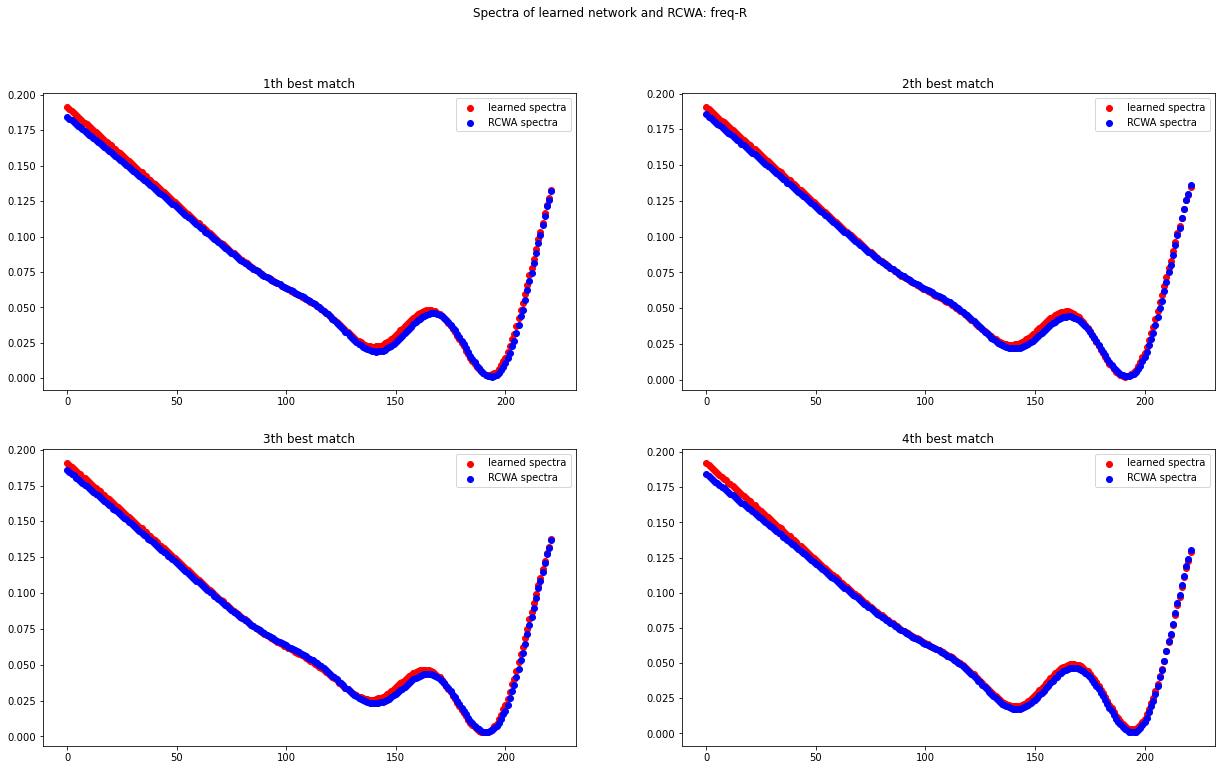

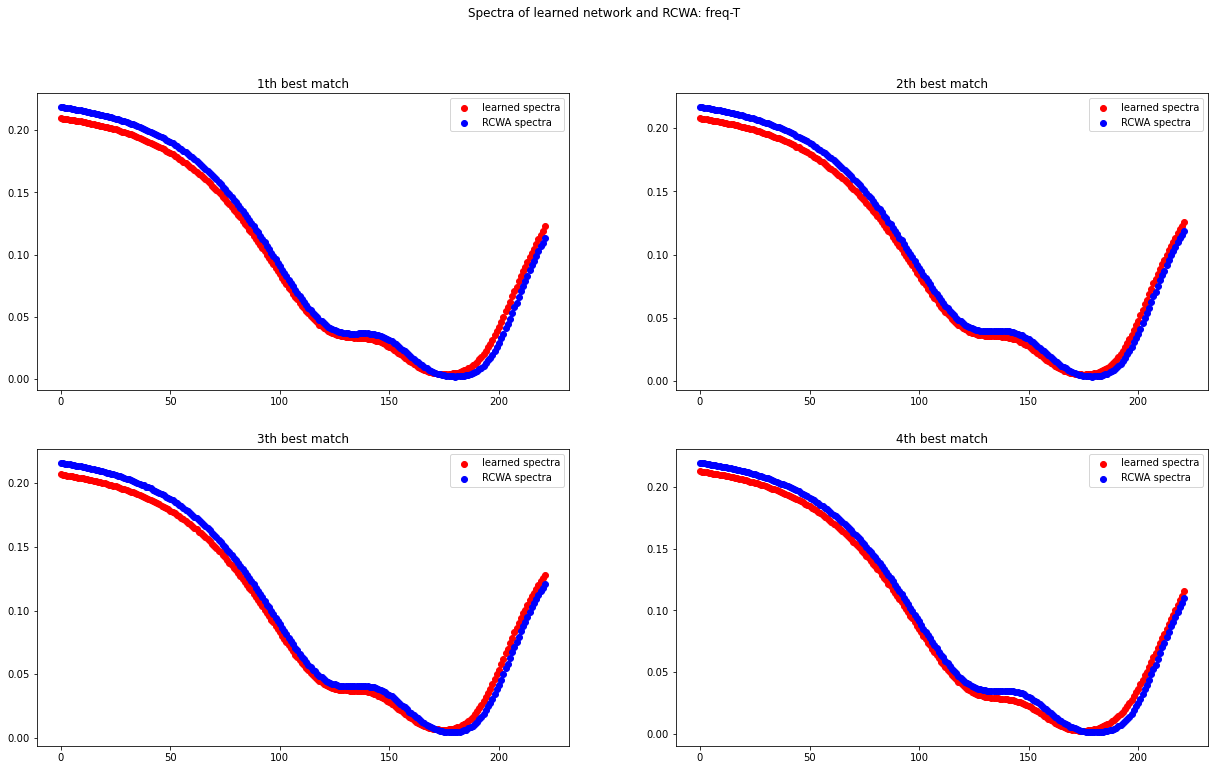

** Model saved.
**************************** ROUND 4 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 800
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [145.  75.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [131.  92.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [109.  94.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [104. 105.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [114. 119.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [67. 71.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [99. 98.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [106.  53.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [124.  83.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [124. 132.]
Calculation Pr

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [87. 66.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [108.  81.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 59. 112.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [112.  82.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 52. 106.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [148.  53.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [123.  74.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [107. 147.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [121. 113.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [116. 132.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [117.  65.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [50. 53.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 9.111371871782125e-05
### TEST LOSS  0.00010374688220811852
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 4.062966477988539e-05
### TEST LOSS  2.304094732608064e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 1.6415507481610802e-05
### TEST LOSS  1.0363355613662861e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.8469576339583682e-05
### TEST LOSS  5.334362231224077e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.7772595652848508e-05
### TEST LOSS  1.2129846671390018e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 1.0039019029548513e-05
### TEST LOSS  5.300209807046485e-06
---------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.9489829154206716e-06
### TEST LOSS  1.4213875090263173e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.4213132122442573e-06
### TEST LOSS  3.702118893518976e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 2.6439319661353266e-06
### TEST LOSS  1.725849709070341e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.3983776859838316e-06
### TEST LOSS  1.2148299030438163e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.4459396359711719e-06
### TEST LOSS  5.89149541004493e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.6155685300134338e-06
### TEST LOSS  2.1520320008979374e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.6003098926642422e-06
### TEST LOSS  1.8638232290868473e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.0111035503612698e-06
### TEST LOSS  1.0731378428848377e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 2.051734323584853e-06
### TEST LOSS  2.2232764867643104e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.53195439700049e-06
### TEST LOSS  4.134898953604231e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.8342391104120281e-06
### TEST LOSS  1.020396870406633e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.1771952110306571e-06
### TEST LOSS  2.5186620481084296e-06
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 7.018074713638356e-07
### TEST LOSS  6.911957086686016e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 5.657597777730672e-07
### TEST LOSS  7.425559852928624e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 5.946986447780134e-07
### TEST LOSS  7.544531683834066e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.444387039332809e-07
### TEST LOSS  3.9922680864871535e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.694949974050957e-07
### TEST LOSS  4.773512477148264e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 6.061915310517918e-07
### TEST LOSS  4.325021478734925e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 6.970035143316622e-07
### TEST LOSS  5.497957621021973e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 1.0478404091696091e-06
### TEST LOSS  4.781302583486043e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 7.152617916039716e-07
### TEST LOSS  3.6825640137294613e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.268065168679727e-07
### TEST LOSS  7.832973191549778e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 4.583317334816428e-07
### TEST LOSS  4.3636424370182186e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 6.581691623308572e-07
### TEST LOSS  3.6729267804958e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.5566913282168996e-07
### TEST LOSS  3.296215306628862e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.48515361904478e-07
### TEST LOSS  6.859207104525922e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 1.489280752293709e-06
### TEST LOSS  1.5990125064035965e-06
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 9.187946364086485e-07
### TEST LOSS  1.2488904985730187e-06
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 1.0169233119050603e-06
### TEST LOSS  5.900945888962875e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 6.557915071248032e-07
### TEST LOSS  3.035379473696291e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.459211288931897e-07
### TEST LOSS  3.6791464452790024e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.6589293239751584e-07
### TEST LOSS  4.320084509383075e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 8.554571347518803e-07
### TEST LOSS  1.146953602907767e-06
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 6.713041706252198e-07
### TEST LOSS  4.0328517295999217e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 6.211037225334337e-07
### TEST LOSS  2.3903463007475998e-06
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.850607771800242e-07
### TEST LOSS  3.416064492019662e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.499798587564996e-07
### TEST LOSS  1.17341170380314e-06
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.112491069381164e-07
### TEST LOSS  3.733411422975526e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.641473642630345e-07
### TEST LOSS  3.50558330808326e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.6517676240688244e-07
### TEST LOSS  3.208124349877532e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.239683933926486e-07
### TEST LOSS  2.563285181148937e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.427840607539423e-07
### TEST LOSS  3.3072041579392436e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.2974434299347664e-07
### TEST LOSS  3.7207329484090224e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.821865501540955e-07
### TEST LOSS  3.513854830809275e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.4750215597512126e-07
### TEST LOSS  4.4737895876778566e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.9671720924783216e-07
### TEST LOSS  6.866020972514283e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.0782751741241797e-07
### TEST LOSS  5.292067205194447e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.9340179863067704e-07
### TEST LOSS  3.7644155762942927e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 8.71421007313522e-07
### TEST LOSS  5.309809788892986e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 5.603450813884691e-07
### TEST LOSS  4.071887668525657e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.024720942481409e-07
### TEST LOSS  8.077533569424608e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.5834557293122914e-07
### TEST LOSS  8.538927147583308e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.0055472477984466e-07
### TEST LOSS  3.777178901505825e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.759594915164755e-07
### TEST LOSS  6.576610710832634e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 6.247954391946919e-07
### TEST LOSS  7.746117726507388e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 5.769595340199274e-07
### TEST LOSS  4.7228168872000725e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.071444349795783e-07
### TEST LOSS  3.2773056091173203e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.626759497772248e-07
### TEST LOSS  3.397486381118142e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.333377675180827e-07
### TEST LOSS  3.283153162669805e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.115393387404964e-07
### TEST LOSS  3.3855999722239477e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 6.6982699752493605e-06
### TEST LOSS  4.119519341353832e-06
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.4106405134414215e-06
### TEST LOSS  6.122178376699594e-06
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.407954867205021e-06
### TEST LOSS  4.361535028844325e-06
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 5.724653095775522e-06
### TEST LOSS  5.101330126914642e-06
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.809731485728719e-06
### TEST LOSS  1.4556629973109617e-05
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 6.460271767725345e-06
### TEST LOSS  1.9121336170731715e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 6.758071819934486e-07
### TEST LOSS  1.139991510967775e-06
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 1.477083512404498e-06
### TEST LOSS  1.226065734272197e-06
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 1.2888429148461e-06
### TEST LOSS  3.183855037984055e-06
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 1.1043952391887047e-06
### TEST LOSS  8.167756841241195e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 6.594572686058342e-07
### TEST LOSS  5.45076422516407e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 6.285252953741605e-07
### TEST LOSS  1.4443857736523569e-06
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 6.740248342351763e-07
### TEST LOSS  6.895205804842893e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 7.594395992205349e-07
### TEST LOSS  7.403255276964652e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 8.248873261074152e-07
### TEST LOSS  8.678585980230006e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 6.758180591548424e-07
### TEST LOSS  3.5558869626584055e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 7.746471608394146e-07
### TEST LOSS  3.624589410833323e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 1.0168204944793757e-06
### TEST LOSS  1.6621424379081873e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.224936895269593e-07
### TEST LOSS  3.873741647453244e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 1.221884369293491e-06
### TEST LOSS  7.566339448317194e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 9.054180854572991e-07
### TEST LOSS  1.0505931887413074e-06
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 5.501944224040045e-07
### TEST LOSS  3.136311714039645e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 6.062147097685155e-07
### TEST LOSS  1.2821361536907716e-06
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 5.716181699222389e-07
### TEST LOSS  4.169600842374166e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 4.3107534354103193e-07
### TEST LOSS  5.846436224032914e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.3345848446563193e-07
### TEST LOSS  3.791902898342414e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.4494849527287883e-07
### TEST LOSS  4.794246824720479e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 4.0939233597381275e-07
### TEST LOSS  3.944313628304978e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.966654396325708e-07
### TEST LOSS  2.385659492176728e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.7489821449021575e-07
### TEST LOSS  4.315059077460622e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.7672347256823004e-07
### TEST LOSS  3.9287888142780503e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.768751418586902e-07
### TEST LOSS  2.5182143303936755e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 4.1646469604028626e-07
### TEST LOSS  2.796241484285626e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.4238670852726473e-07
### TEST LOSS  7.062251417740603e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.4098211133759547e-07
### TEST LOSS  4.5445906001380837e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 4.1494916402484705e-07
### TEST LOSS  4.134452424864321e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 4.261498844160272e-07
### TEST LOSS  4.5853861270946555e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.5312531074582767e-07
### TEST LOSS  3.50842791855636e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.71716032434577e-07
### TEST LOSS  3.62743482658819e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.9372346603894216e-07
### TEST LOSS  3.099178087495602e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.3916279665202606e-07
### TEST LOSS  3.8014738853083446e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 4.1748044377065696e-07
### TEST LOSS  2.6237853253026816e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.264342264053255e-07
### TEST LOSS  2.4821864504550223e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.96222481446884e-07
### TEST LOSS  2.6297861192385125e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.5802137022589164e-07
### TEST LOSS  5.391952366077627e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.3306206048244747e-07
### TEST LOSS  3.430119169441544e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.285106984085573e-07
### TEST LOSS  2.875886480069312e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.3935954126373956e-07
### TEST LOSS  3.814865200032121e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.668931432598832e-07
### TEST LOSS  2.803377038655223e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.687702054167019e-07
### TEST LOSS  2.5966798252359996e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.579809265796818e-07
### TEST LOSS  2.4714440627349177e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.477884679803367e-07
### TEST LOSS  4.06872513754782e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.0433120694617345e-07
### TEST LOSS  3.674110236791724e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.3436869901759535e-07
### TEST LOSS  3.91552861837378e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.3882344180113933e-07
### TEST LOSS  5.167020328637287e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.0502439185120523e-07
### TEST LOSS  2.11136698643107e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.7790401862469737e-07
### TEST LOSS  3.5744438046473687e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.5061462998697835e-07
### TEST LOSS  4.836476558504425e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.9036194547193973e-07
### TEST LOSS  2.8410248376076197e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.977542304538616e-07
### TEST LOSS  3.30585677943418e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.0768633251909705e-07
### TEST LOSS  2.6412755005367217e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.0458690702062086e-07
### TEST LOSS  2.3444569308139762e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.071953488920087e-07
### TEST LOSS  3.3561450152319594e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.8128990695375225e-07
### TEST LOSS  2.8056234313567074e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.807889304712319e-07
### TEST LOSS  4.774776816892275e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.282813335570012e-07
### TEST LOSS  2.545022847281568e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.8814192913072534e-07
### TEST LOSS  3.070733924914748e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.0071268784604968e-06
### TEST LOSS  9.401021496084164e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 4.093109669853767e-06
### TEST LOSS  4.996680634879643e-06
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.592256992197562e-06
### TEST LOSS  8.381016556313625e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 1.0638641090299217e-06
### TEST LOSS  2.0253555229980216e-06
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.511479630546987e-06
### TEST LOSS  8.180902473971704e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.9805453041209515e-07
### TEST LOSS  2.6145982327345035e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.843066401037042e-07
### TEST LOSS  2.686443399587309e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.9557342531294493e-07
### TEST LOSS  2.341833618875929e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.7604168862271905e-07
### TEST LOSS  3.4184446443911537e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.862387173419023e-07
### TEST LOSS  2.4735793976068027e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.780274715341591e-07
### TEST LOSS  3.390199978525743e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.031586605573011e-07
### TEST LOSS  3.1525995562257475e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.6636600921392526e-07
### TEST LOSS  2.1280589616405146e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.5200027625960075e-07
### TEST LOSS  3.531445145199541e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.5664668571456775e-07
### TEST LOSS  2.622800536755676e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.80438212800771e-07
### TEST LOSS  2.535481039937319e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.824624565000988e-07
### TEST LOSS  2.3776194642740242e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.492910163371832e-07
### TEST LOSS  1.8899666069197943e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.4826606534578135e-07
### TEST LOSS  2.8439453814144144e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.8574841966610974e-07
### TEST LOSS  2.9669965092201284e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.6589144847655177e-07
### TEST LOSS  3.115418133840346e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.6317872423797796e-07
### TEST LOSS  2.953948090578251e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.979130535640806e-07
### TEST LOSS  2.684470068459177e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.2786111014981856e-07
### TEST LOSS  2.118279158006923e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.611044623290759e-07
### TEST LOSS  2.3435510480377766e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.896729325496672e-07
### TEST LOSS  2.08491305405308e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.1472360683570955e-07
### TEST LOSS  3.0575393357897457e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.381527871264666e-07
### TEST LOSS  2.678888850008813e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.935312176577387e-07
### TEST LOSS  3.006605536389391e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.9758100274168696e-07
### TEST LOSS  1.7842899779907384e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.5773799301243016e-07
### TEST LOSS  3.047031071901074e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.5035532413952846e-07
### TEST LOSS  2.4638801813618255e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.333190205372482e-07
### TEST LOSS  2.389815515850084e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.698696724312555e-07
### TEST LOSS  2.4754456617870346e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.8527966190461384e-07
### TEST LOSS  2.0783475918051408e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.604603454026133e-07
### TEST LOSS  2.4131398153789024e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.95748606788937e-07
### TEST LOSS  2.5893252105409675e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.707664881307359e-07
### TEST LOSS  3.172266976510703e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.776481032640277e-07
### TEST LOSS  1.9885074920011903e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.6747620446965214e-07
### TEST LOSS  4.2819504386670815e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.9036956280759083e-07
### TEST LOSS  1.979404847437157e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.6962043211842255e-07
### TEST LOSS  1.745046548743782e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.9977496061039945e-07
### TEST LOSS  3.065028835180783e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.775230590690292e-07
### TEST LOSS  2.633486767914898e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.362889896263432e-07
### TEST LOSS  3.3765081871213926e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.627464895543774e-07
### TEST LOSS  2.54963925527818e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.5151056717298557e-07
### TEST LOSS  5.417038693167342e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.447284464568433e-07
### TEST LOSS  2.94219934933911e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.243176296623517e-07
### TEST LOSS  2.9502824361316016e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.2399096691994024e-07
### TEST LOSS  2.766885636162897e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.2046312948331702e-07
### TEST LOSS  2.6165170652348024e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.4056009150008607e-07
### TEST LOSS  1.7216544515955926e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.3103731099149984e-07
### TEST LOSS  2.238867663114282e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.821690509258179e-07
### TEST LOSS  1.662791741334028e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.2162848948736879e-07
### TEST LOSS  4.084714267567809e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.396173750462971e-07
### TEST LOSS  3.0384793584895914e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.587575370971429e-07
### TEST LOSS  1.9340980254393494e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.2816021557847677e-07
### TEST LOSS  1.649141492994962e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.427228469414899e-07
### TEST LOSS  2.6263138863669155e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.7608274606238935e-07
### TEST LOSS  3.2524500189386646e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.3576508903833115e-07
### TEST LOSS  2.9616304667949106e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.4602137358886724e-07
### TEST LOSS  1.8194507826289433e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.3452868121998094e-07
### TEST LOSS  2.962103072453222e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.2348228495561173e-07
### TEST LOSS  2.1236662917090143e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.867221905056283e-07
### TEST LOSS  2.0497865449442543e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.547803752950273e-07
### TEST LOSS  2.963018097545955e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.449836301288144e-07
### TEST LOSS  1.3975677208103812e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.2212353164130506e-07
### TEST LOSS  2.824908224378457e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.4040758149990183e-07
### TEST LOSS  2.060504608418038e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.0558408346582625e-07
### TEST LOSS  2.6801474580414225e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.3245880005795528e-07
### TEST LOSS  2.9189831470451583e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.1500958899078882e-07
### TEST LOSS  1.637799288782086e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.2398480545193778e-07
### TEST LOSS  1.7372375301268525e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.20750403077119e-07
### TEST LOSS  1.9820911016192136e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.365945060978092e-07
### TEST LOSS  2.9615106456049034e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.1549362029249507e-07
### TEST LOSS  3.93545702100558e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.399051888035686e-07
### TEST LOSS  1.831226358698738e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.3442777571158758e-07
### TEST LOSS  2.406181790111835e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.355616281657369e-07
### TEST LOSS  4.453310064415443e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.1850782921717382e-07
### TEST LOSS  1.8185690464633808e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.184289521145466e-07
### TEST LOSS  2.1403291465086718e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.449555182759688e-07
### TEST LOSS  2.3155767081561862e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.4429408325365996e-07
### TEST LOSS  3.320148328119406e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.7205923845086135e-07
### TEST LOSS  3.034850285151454e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 3.8653967314283834e-07
### TEST LOSS  2.493632393907319e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.2862656953615002e-07
### TEST LOSS  2.0531906012403547e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.069475495392048e-07
### TEST LOSS  1.9484931949402076e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.612840992211041e-07
### TEST LOSS  3.299620203733866e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.1891913602356538e-07
### TEST LOSS  3.1112687774263276e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.1141542164704318e-07
### TEST LOSS  1.9580256231203444e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.1492931777444825e-07
### TEST LOSS  2.3350327301348747e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 3.060029616541726e-07
### TEST LOSS  1.8881329211239972e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.227077574068481e-07
### TEST LOSS  1.953405887415253e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.5316352693760534e-07
### TEST LOSS  1.6963100080147342e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.011667569035147e-07
### TEST LOSS  1.6955842951915656e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.2664158786156463e-07
### TEST LOSS  1.7552380171537152e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 1.9187050874336363e-07
### TEST LOSS  1.682228223387483e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.388411243114952e-07
### TEST LOSS  1.7187939841771063e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 1.9334898580636305e-07
### TEST LOSS  1.8538032738509477e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 1.87179481585531e-07
### TEST LOSS  1.5236037853583184e-07
** loss_train 1.87179481585531e-07
** loss_test 1.5236037853583184e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


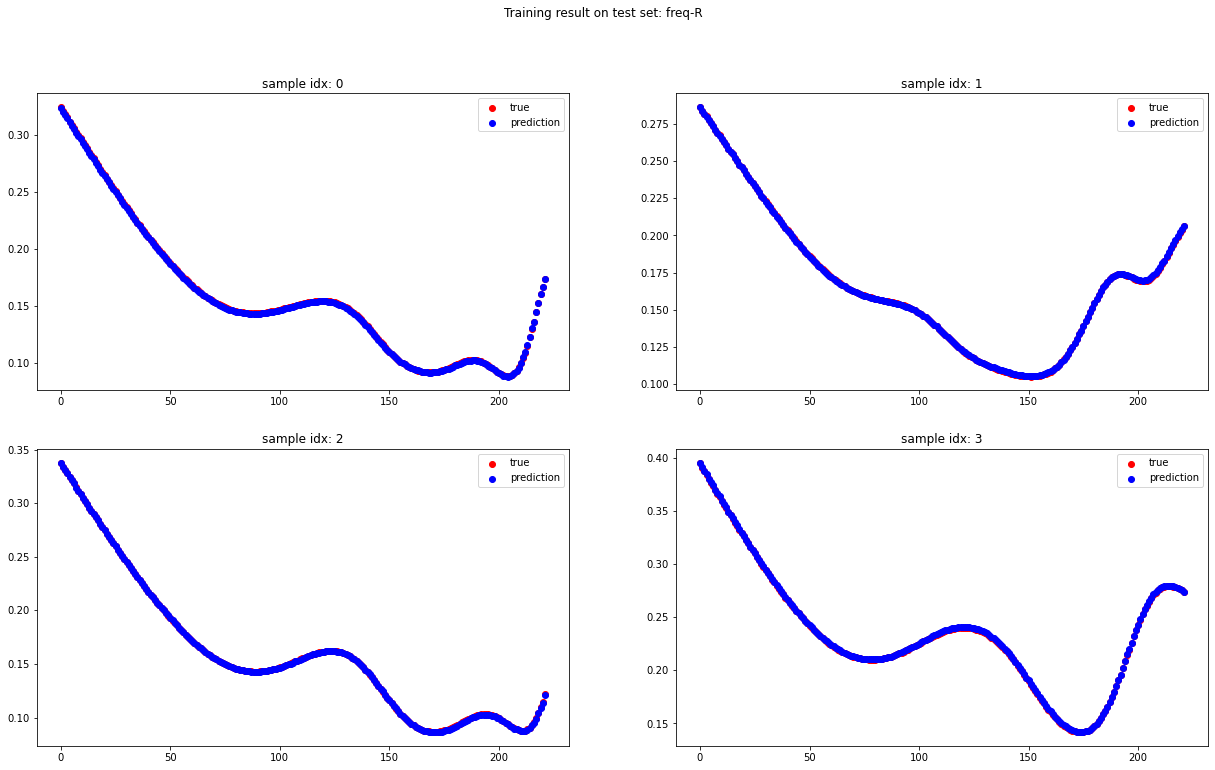

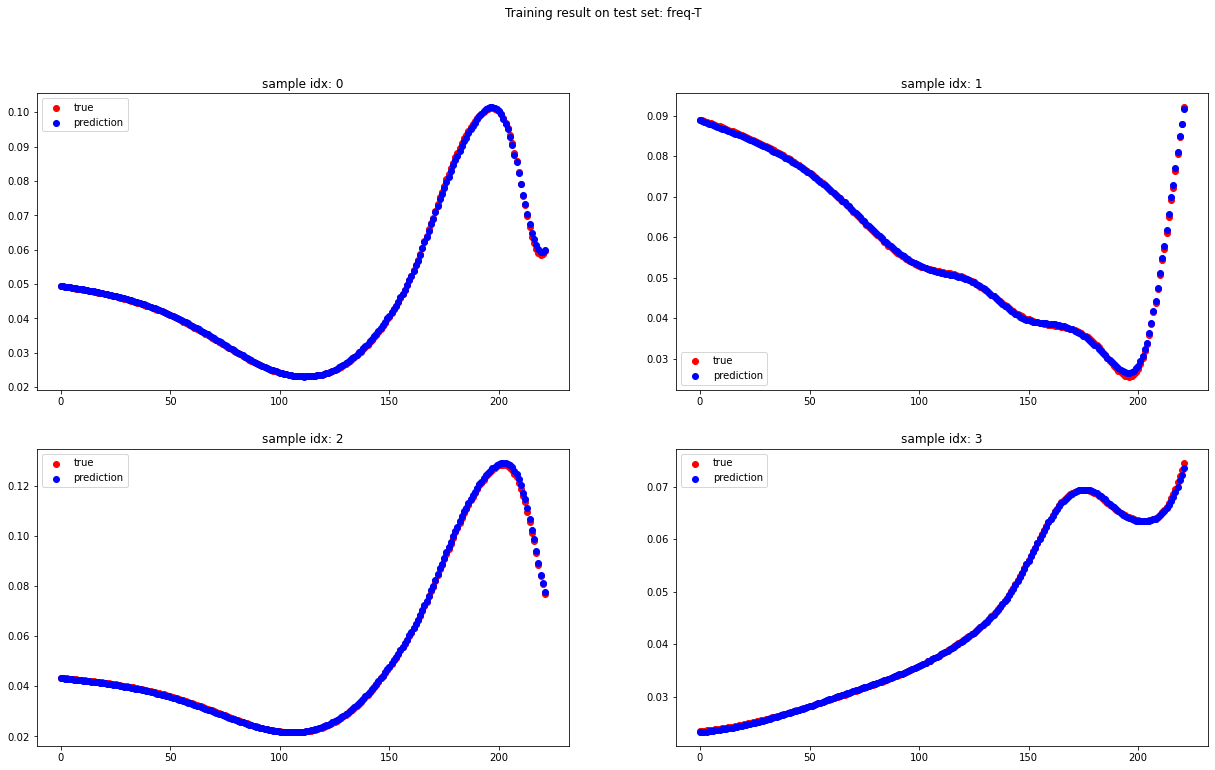

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

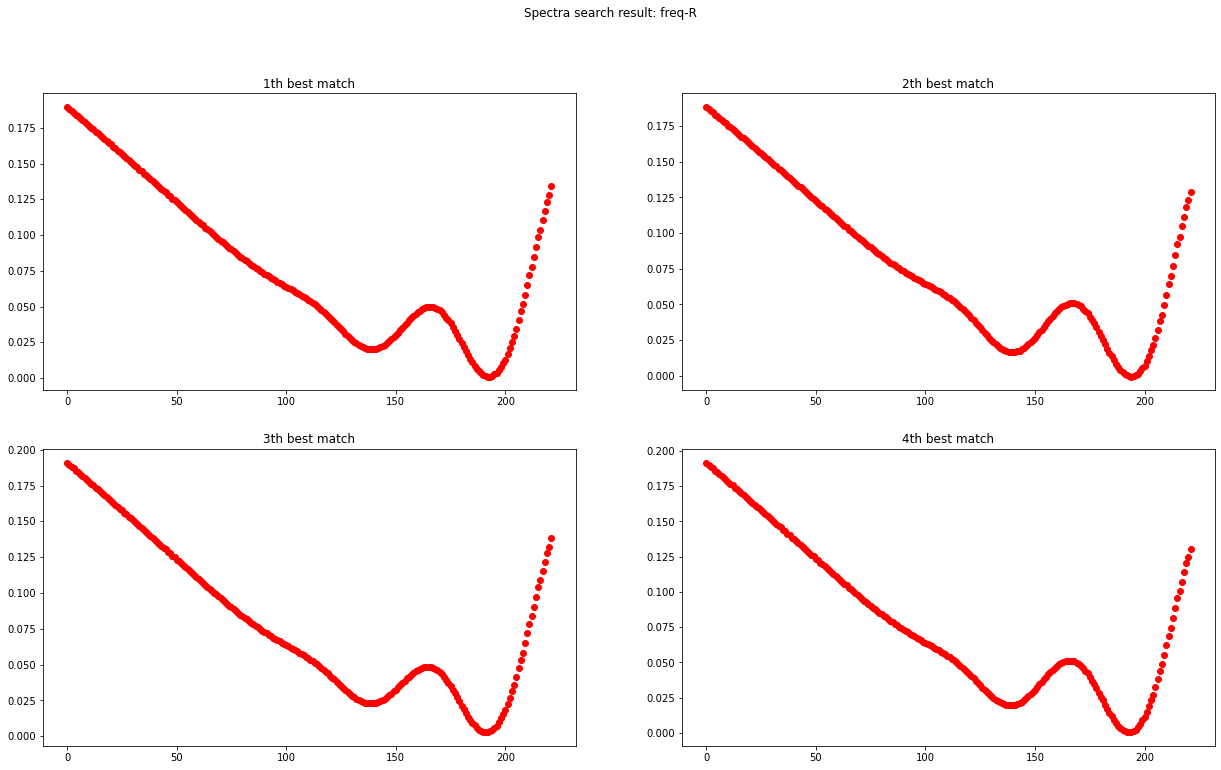

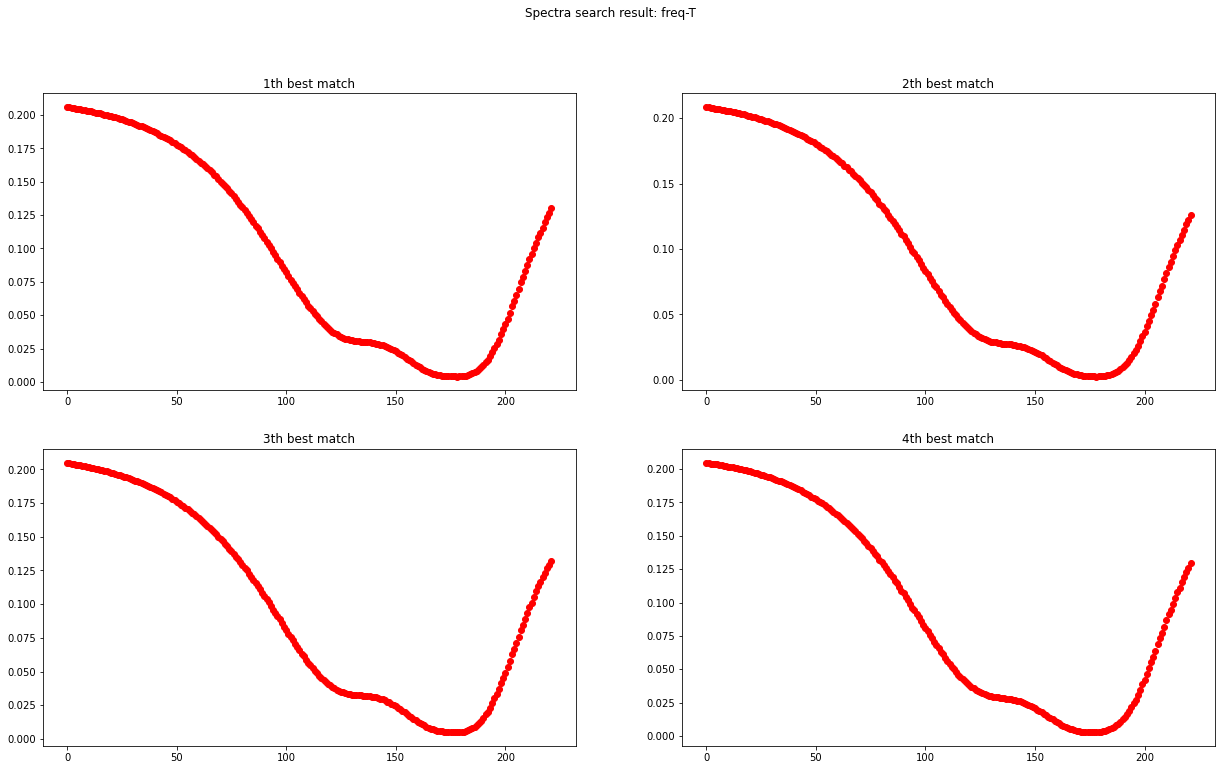

params_pick_visual.shape: (40, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (813, 4)
R_dict.shape: (813, 222)
T_dict.shape: (813, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [150. 132. 160.  75.] params_pick: [150. 132. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [150. 133. 160.  75.] params_pick: [150. 133. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [150. 131. 160.  75.] params_pick: [150. 131. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [149. 132. 160.  75.] params_pick: [149. 132. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [149. 131. 160.  75.] params_pick: [149. 131. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [149. 133. 160.  75.] params_pick: [149. 133. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_d

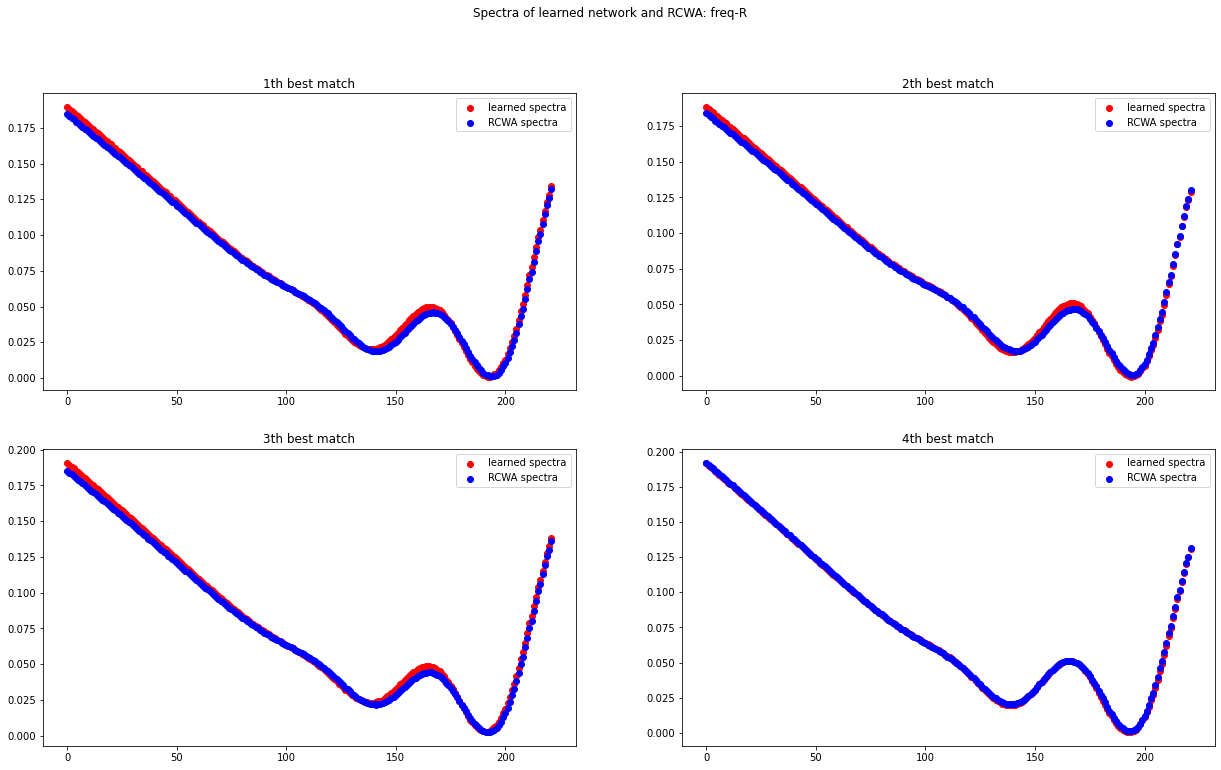

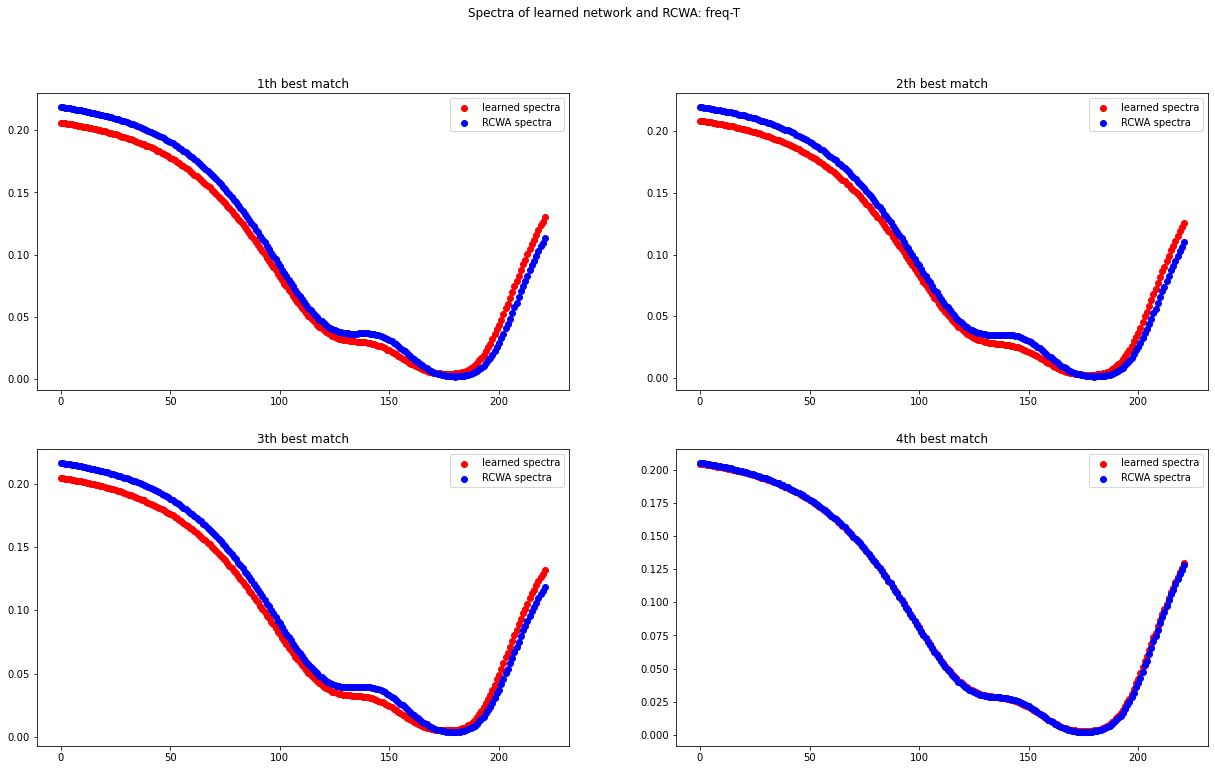

** Model saved.
**************************** ROUND 5 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1000
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [129. 115.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [118. 104.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [148. 111.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [142. 134.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [107.  93.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [90. 90.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [78. 89.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 92. 120.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [ 99. 107.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 56. 114.]
Calculation P

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [146.  86.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [133.  96.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [130.  58.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 69. 140.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [135.  92.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [141.  66.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [139. 148.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [59. 79.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [102. 108.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [120.  67.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 72. 140.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [97. 96.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 5.463042466533352e-05
### TEST LOSS  0.00015071422337011123
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.535991285129512e-05
### TEST LOSS  1.0876890458651663e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 1.6481242334833722e-05
### TEST LOSS  3.7412692108773626e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.8485937297782584e-05
### TEST LOSS  7.67083920436562e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 1.672671822183247e-05
### TEST LOSS  1.6478241316993566e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 9.653304225309967e-06
### TEST LOSS  5.738981478013253e-06
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.7761695736737693e-06
### TEST LOSS  1.5183798799019617e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.7485036599893532e-06
### TEST LOSS  1.9013968540093628e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 3.1449444007805026e-06
### TEST LOSS  1.7250257428713667e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.927999986705231e-06
### TEST LOSS  4.617674024605852e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.352796831615933e-06
### TEST LOSS  1.3600529655377614e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 2.08115335826875e-06
### TEST LOSS  3.4595227892471787e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.2754750883061662e-06
### TEST LOSS  5.893732293316134e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.4183538324488153e-06
### TEST LOSS  1.5852381769339748e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.2758166595645548e-06
### TEST LOSS  8.696276154296357e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 9.745863980725744e-07
### TEST LOSS  1.1279296851777569e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.287169499548213e-06
### TEST LOSS  7.164626216156951e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 3.6246911146378124e-06
### TEST LOSS  5.732401101946986e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 2.5506291553085705e-06
### TEST LOSS  1.2050329208553496e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 1.7867677910246016e-06
### TEST LOSS  2.3032482734682465e-06
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 2.2538433306849017e-06
### TEST LOSS  8.200146082041708e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 1.7404866390080543e-06
### TEST LOSS  1.546568849638182e-06
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 1.3536793524622226e-06
### TEST LOSS  1.7078797024320616e-06
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 1.4654112925001072e-06
### TEST LOSS  1.474591181249707e-06
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 2.1503063092893624e-06
### TEST LOSS  8.788704917606082e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 1.2555626886623373e-06
### TEST LOSS  1.2167298336862587e-06
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 1.0402350614384658e-06
### TEST LOSS  8.352134955202927e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 1.0358543204702642e-06
### TEST LOSS  9.586989942060124e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 8.484434897511051e-07
### TEST LOSS  8.951401355261624e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 1.1526352735131695e-06
### TEST LOSS  9.627943427403806e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 6.553634984030054e-07
### TEST LOSS  2.8281082601703624e-06
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 1.0186173377704222e-06
### TEST LOSS  1.1114582245378794e-06
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 1.4932298828540524e-06
### TEST LOSS  8.988566113051395e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 1.6328766002402517e-06
### TEST LOSS  2.7418243310724696e-06
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 2.120914708669375e-06
### TEST LOSS  7.409094716119095e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 7.99396714313616e-07
### TEST LOSS  5.182174940424981e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.4237703933115427e-06
### TEST LOSS  1.7488383681059835e-06
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 1.20711748268576e-06
### TEST LOSS  5.468917227820687e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 9.206106065633435e-07
### TEST LOSS  7.924656794481658e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.2551925152972673e-06
### TEST LOSS  4.190562018872394e-06
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 2.058637672035957e-06
### TEST LOSS  1.0083084362122464e-06
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 1.1029491381862045e-06
### TEST LOSS  9.210911684931488e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 1.264983164034561e-06
### TEST LOSS  5.277073133432471e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 1.6300168863452313e-06
### TEST LOSS  1.1982640595912622e-06
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 9.046478527849899e-07
### TEST LOSS  7.645845622998119e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 1.4766551635219117e-06
### TEST LOSS  9.918434382901372e-06
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 1.7649232055774177e-06
### TEST LOSS  6.873160013280237e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 8.567214520311949e-07
### TEST LOSS  6.584574331706486e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 1.3140972260572426e-06
### TEST LOSS  6.604803616028221e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 6.337878661497598e-07
### TEST LOSS  1.0289713297121731e-06
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 6.368164059260551e-07
### TEST LOSS  4.6571041517988e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 2.1072694546617755e-06
### TEST LOSS  9.140159742552593e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 1.1031949478663706e-06
### TEST LOSS  6.992315547904582e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 7.058667871575608e-07
### TEST LOSS  3.869648480758769e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 5.460144860052196e-07
### TEST LOSS  5.955399615231727e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.972861860217393e-07
### TEST LOSS  3.4884709331587753e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 1.254642991618482e-06
### TEST LOSS  7.692253385963947e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 8.697775699673116e-07
### TEST LOSS  8.86455287248585e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 5.814520810645263e-07
### TEST LOSS  4.862881629226953e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.4881380644667954e-07
### TEST LOSS  3.909227624869042e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.8052821592771126e-07
### TEST LOSS  3.56642103345924e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.456067199214431e-07
### TEST LOSS  8.423967112018241e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 8.035785986812982e-07
### TEST LOSS  7.935208320001644e-06
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 8.942766021640125e-07
### TEST LOSS  3.7710822766712224e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 5.098882926759529e-07
### TEST LOSS  5.072319064917489e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.461940448940993e-07
### TEST LOSS  5.386203573228461e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 7.856548941198582e-07
### TEST LOSS  8.002256890904391e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 6.457821986387557e-07
### TEST LOSS  4.245600697079984e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 8.828815138102186e-07
### TEST LOSS  5.45041242124474e-06
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.234402034820505e-06
### TEST LOSS  7.159746360230201e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 7.85572795177103e-07
### TEST LOSS  4.7514097332168605e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 5.588466352222099e-07
### TEST LOSS  5.962006810023013e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.265010233552857e-07
### TEST LOSS  3.051332726045075e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.3902528149430965e-07
### TEST LOSS  3.0904449962084374e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.92306557596811e-07
### TEST LOSS  3.388649759017426e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.004060076745475e-07
### TEST LOSS  5.275662147141702e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.354999570495011e-07
### TEST LOSS  3.1525677286481367e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.457250206402307e-07
### TEST LOSS  4.847194134072197e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.680022879137823e-07
### TEST LOSS  4.6913707668257606e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.6744287740475556e-07
### TEST LOSS  3.3739473982071406e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.881140524555349e-07
### TEST LOSS  3.188155555259679e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.557251235832837e-07
### TEST LOSS  4.232758764525594e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.8265972030160355e-07
### TEST LOSS  1.1694384966176586e-06
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 8.846321525595614e-06
### TEST LOSS  1.5632250172833058e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.6125880160398085e-07
### TEST LOSS  2.7887248374251307e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.849207509993846e-07
### TEST LOSS  3.001641005084821e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.8867669566045037e-07
### TEST LOSS  4.113552070824274e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.588533209004652e-07
### TEST LOSS  7.81797829555823e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.803557230419585e-07
### TEST LOSS  3.232767331458793e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.5821152958703805e-07
### TEST LOSS  2.914811858545363e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 5.260900132313395e-07
### TEST LOSS  3.8864845161394136e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.0700269726912097e-07
### TEST LOSS  3.1979001846593746e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.674342224719851e-07
### TEST LOSS  2.9352841674305333e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.957804731911097e-07
### TEST LOSS  3.703394725107501e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.458592466110133e-07
### TEST LOSS  2.372306435442321e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.150679558885372e-07
### TEST LOSS  2.6569953774924216e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.217911918866889e-07
### TEST LOSS  3.884775992446521e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.339605051468908e-07
### TEST LOSS  4.089165751490024e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.536428694701499e-07
### TEST LOSS  3.2068570400648846e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.251066548735082e-07
### TEST LOSS  3.305834951561337e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.619214716046315e-07
### TEST LOSS  4.032590027236438e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.5480835509460463e-07
### TEST LOSS  3.3688205576254403e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.2547807776239777e-07
### TEST LOSS  2.879517031336339e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.995260728617666e-07
### TEST LOSS  2.2696389028927418e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.4588477483055157e-07
### TEST LOSS  2.444122098192262e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.3460748639058123e-07
### TEST LOSS  1.9762905481002236e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.574277457367714e-07
### TEST LOSS  3.1115975881827275e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.290270934428463e-07
### TEST LOSS  3.514358979828103e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.3912223073429003e-07
### TEST LOSS  2.2933816884081656e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.0851391850106327e-07
### TEST LOSS  3.482974780884736e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.068390792382303e-07
### TEST LOSS  2.87648999612126e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.365277556639512e-07
### TEST LOSS  7.47689273339347e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.4111973211636836e-07
### TEST LOSS  3.391649026222391e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.5797358288292003e-07
### TEST LOSS  3.683165232359897e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 5.703127793168505e-07
### TEST LOSS  3.887768968979799e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 6.28839803940906e-07
### TEST LOSS  4.77275593387579e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 5.613685959282577e-07
### TEST LOSS  7.631084561883957e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 5.831799823745598e-07
### TEST LOSS  7.144873090207208e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 1.8341968414183896e-06
### TEST LOSS  2.1433929456785943e-06
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 6.865755383635985e-06
### TEST LOSS  1.6595116827981352e-06
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 5.287593199483354e-07
### TEST LOSS  2.6032971523666977e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 5.460333639142334e-07
### TEST LOSS  2.591421851623939e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.8229815323376214e-07
### TEST LOSS  2.791666967520238e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.458408285244019e-07
### TEST LOSS  2.8880488590251237e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.5098287725787716e-07
### TEST LOSS  2.232435491578144e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.119721570055134e-07
### TEST LOSS  2.0225533792957624e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.824017210620866e-07
### TEST LOSS  2.0934882816921647e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.02867442865562e-07
### TEST LOSS  2.518175070539049e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.8657588416081123e-07
### TEST LOSS  2.542914861199582e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.9165016774967966e-07
### TEST LOSS  3.1982895905002805e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.7447389619084107e-07
### TEST LOSS  1.9049772295905617e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.2646549121828625e-07
### TEST LOSS  2.9363187555494125e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.1562345222369e-07
### TEST LOSS  2.6897521460493105e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.8965219572185675e-07
### TEST LOSS  4.1735002772232593e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.858508313998698e-07
### TEST LOSS  2.0406107523740502e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.4105521924132634e-07
### TEST LOSS  2.101340442095534e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.867838591491534e-07
### TEST LOSS  2.518129633699573e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.897808688899772e-07
### TEST LOSS  2.4222793892173893e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.448544181203772e-07
### TEST LOSS  2.4277907376320705e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.6541123225243267e-07
### TEST LOSS  3.00305765676967e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.6918391909980246e-07
### TEST LOSS  2.4439886866881956e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.8427968199373763e-07
### TEST LOSS  3.6992971672589194e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.879248375968757e-07
### TEST LOSS  2.6816919861024266e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.588092691695465e-07
### TEST LOSS  2.379442814041492e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.9075002388800897e-07
### TEST LOSS  2.1597414180026437e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.777429283185029e-07
### TEST LOSS  2.842254626026867e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.67904764921667e-07
### TEST LOSS  2.3088233831458637e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.8631601249529126e-07
### TEST LOSS  3.1946603182101775e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.686145280108576e-07
### TEST LOSS  2.258360931743179e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.565091894695115e-07
### TEST LOSS  4.785794885719952e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.918336919179865e-07
### TEST LOSS  3.148691935924338e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.659010289995933e-07
### TEST LOSS  3.0769499611930463e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.740635933768942e-07
### TEST LOSS  1.8350005082841865e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.5806741662393053e-07
### TEST LOSS  2.9554870669320127e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.686901330513081e-07
### TEST LOSS  1.8505744018663486e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.611945999930754e-07
### TEST LOSS  2.0157714573088014e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.200825798188589e-07
### TEST LOSS  2.762422127489117e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.685460803188988e-07
### TEST LOSS  2.613196765347917e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.7592447436930454e-07
### TEST LOSS  2.8647457668284914e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.448175284539445e-07
### TEST LOSS  2.365266775920342e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.495873100265555e-07
### TEST LOSS  2.1501041184516603e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.722425360808245e-07
### TEST LOSS  2.492440396887711e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 4.583245259794921e-07
### TEST LOSS  2.9710421263947257e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.5088723529597133e-07
### TEST LOSS  2.2828609094934412e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.8941285756877164e-07
### TEST LOSS  4.541571759849224e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.6363056689481256e-07
### TEST LOSS  2.564441009174819e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.345255111941725e-07
### TEST LOSS  4.7099314125868357e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.9172665120569264e-07
### TEST LOSS  3.727725356839073e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.82074659608611e-07
### TEST LOSS  3.070511363982102e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.78512130991615e-07
### TEST LOSS  1.8887556431460933e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.9011748956975227e-07
### TEST LOSS  3.789669297778649e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.738714019194788e-07
### TEST LOSS  2.086078704148046e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.6180247229845576e-07
### TEST LOSS  4.750308581454495e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.7275674377591485e-07
### TEST LOSS  1.8895977405009035e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 7.335578488465444e-07
### TEST LOSS  5.164450101347029e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 5.138271908222691e-07
### TEST LOSS  1.367980295678232e-06
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 4.666360323817287e-07
### TEST LOSS  3.719146472273375e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 7.917492571998253e-07
### TEST LOSS  8.695362150016687e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 5.354142069613488e-07
### TEST LOSS  4.13082614159066e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 3.649457089878183e-07
### TEST LOSS  8.691616017131309e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 1.1979943459303754e-05
### TEST LOSS  1.549598558388728e-06
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 5.970414904197696e-06
### TEST LOSS  2.3289135697268646e-06
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 1.871731484357042e-06
### TEST LOSS  1.925019031053428e-06
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 1.5803131501428426e-06
### TEST LOSS  9.870228495856282e-07
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 1.5976742025216594e-06
### TEST LOSS  5.888211963641273e-07
----------------------------------------------------------------------
*** EPOCH 1587 || AVG LOSS 1.6117536787980669e-06
### TEST LOSS  8.407597420045932e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 6.373055409198968e-07
### TEST LOSS  3.614391782017871e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 7.401613462203471e-07
### TEST LOSS  2.966104498606607e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 1.4531318082582346e-06
### TEST LOSS  1.7145237279692082e-06
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 8.652414502634542e-07
### TEST LOSS  3.403544278626214e-05
----------------------------------------------------------------------
*** EPOCH 1639 || AVG LOSS 2.2052619209844694e-06
### TEST LOSS  6.8690405896632e-07
----------------------------------------------------------------------
*** EPOCH 1640 || AVG LOSS 9.696019645666353e-07
### TEST LOSS  3.000952602860707e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.708950682261957e-07
### TEST LOSS  2.7847646322243236e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.768764582850025e-07
### TEST LOSS  2.589564805551466e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.821010119811064e-07
### TEST LOSS  4.770919645125104e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 2.760019881673514e-07
### TEST LOSS  2.6161489662020663e-07
----------------------------------------------------------------------
*** EPOCH 1691 || AVG LOSS 3.460533098795793e-07
### TEST LOSS  4.7851780967297e-07
----------------------------------------------------------------------
*** EPOCH 1692 || AVG LOSS 2.9232692646985467e-07
### TEST LOSS  2.2999969075954141e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.4861822123156686e-07
### TEST LOSS  2.4233790062074454e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.700932601289452e-07
### TEST LOSS  2.63701528524507e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.53434598384672e-07
### TEST LOSS  1.93907895133331e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 2.475213887489502e-07
### TEST LOSS  2.553615464269872e-07
----------------------------------------------------------------------
*** EPOCH 1743 || AVG LOSS 2.7208066107320403e-07
### TEST LOSS  2.0702510994397016e-07
----------------------------------------------------------------------
*** EPOCH 1744 || AVG LOSS 2.406915272779031e-07
### TEST LOSS  1.780811724453694e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.684807855892757e-07
### TEST LOSS  1.6832252166902132e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.4247174572877836e-07
### TEST LOSS  2.387681216002117e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.482092083386789e-07
### TEST LOSS  1.7568310492303378e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 2.9683001920943753e-07
### TEST LOSS  3.1880938517285055e-07
----------------------------------------------------------------------
*** EPOCH 1795 || AVG LOSS 3.5496063854623115e-07
### TEST LOSS  3.330871891193965e-07
----------------------------------------------------------------------
*** EPOCH 1796 || AVG LOSS 2.2585080616899232e-07
### TEST LOSS  1.9212046045898508e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.551600016431621e-07
### TEST LOSS  2.6263314036138277e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.332519521122123e-07
### TEST LOSS  2.6739369237323746e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.6726725948300613e-07
### TEST LOSS  5.588865510238369e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 3.235469050366646e-07
### TEST LOSS  3.797716317421873e-07
----------------------------------------------------------------------
*** EPOCH 1847 || AVG LOSS 3.057401086188349e-07
### TEST LOSS  3.5260462709629793e-07
----------------------------------------------------------------------
*** EPOCH 1848 || AVG LOSS 2.5381220790166025e-07
### TEST LOSS  1.7201355101785035e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.4405332770882636e-07
### TEST LOSS  3.0942020619780425e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.2950190997761411e-07
### TEST LOSS  2.391302444948451e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.684303139943722e-07
### TEST LOSS  2.8524390719060953e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 3.184130347015923e-07
### TEST LOSS  1.989515273711125e-07
----------------------------------------------------------------------
*** EPOCH 1899 || AVG LOSS 2.5707529743890236e-07
### TEST LOSS  3.438721838241084e-07
----------------------------------------------------------------------
*** EPOCH 1900 || AVG LOSS 2.806385941784839e-07
### TEST LOSS  1.521792379814239e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.690644271936549e-07
### TEST LOSS  2.0521973359185116e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.2361219023281365e-07
### TEST LOSS  2.2046748332134788e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.5059743216004903e-07
### TEST LOSS  1.9931621011437529e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 2.6033654165935613e-07
### TEST LOSS  3.5964590855049513e-07
----------------------------------------------------------------------
*** EPOCH 1951 || AVG LOSS 2.437069640581768e-07
### TEST LOSS  1.6815456452453266e-07
----------------------------------------------------------------------
*** EPOCH 1952 || AVG LOSS 2.6453334061926626e-07
### TEST LOSS  2.7700193925284113e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.406175537927879e-07
### TEST LOSS  1.5315424046017748e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.3619155835952198e-07
### TEST LOSS  1.607623839087561e-07
** loss_train 2.3619155835952198e-07
** loss_test 1.607623839087561e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


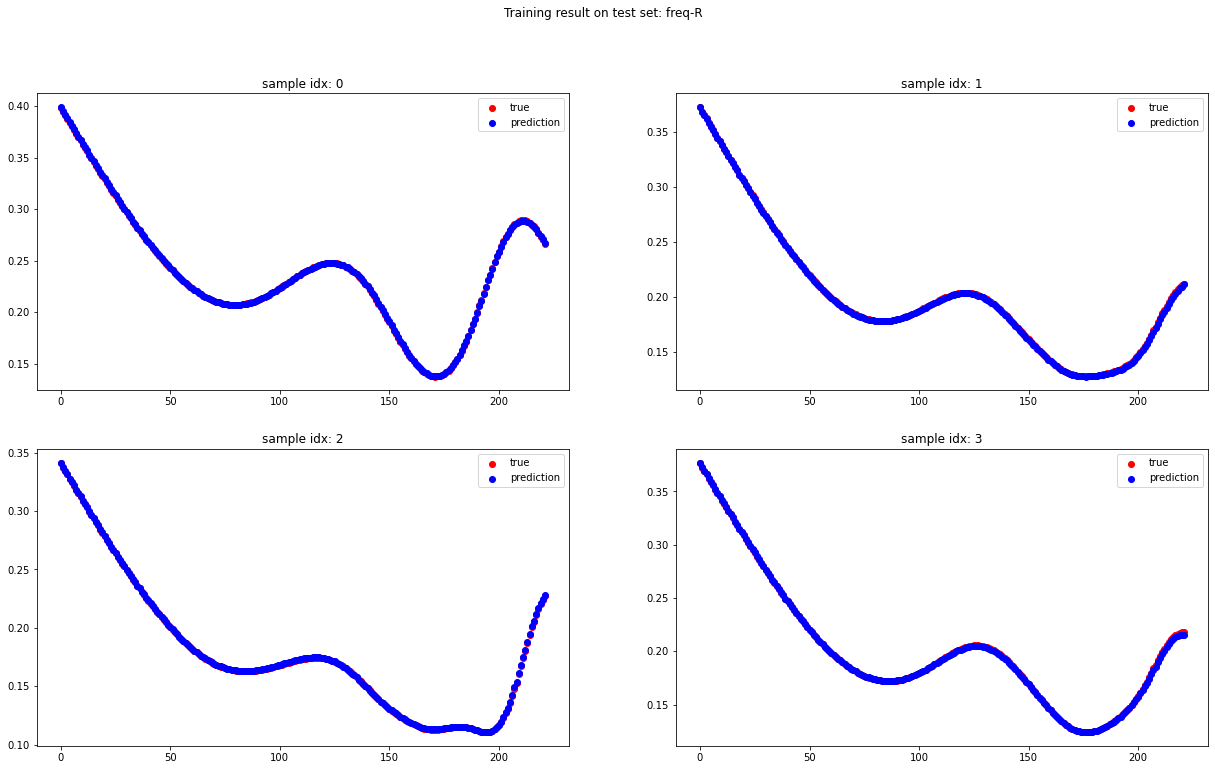

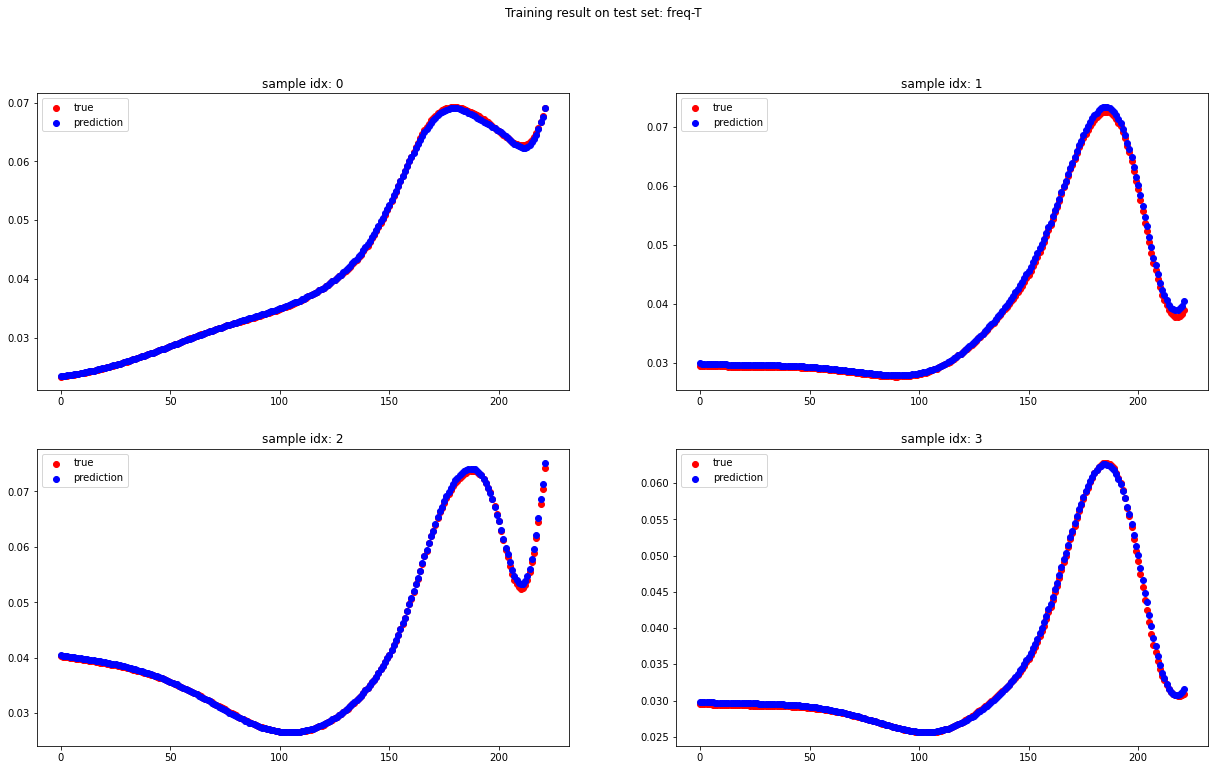

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

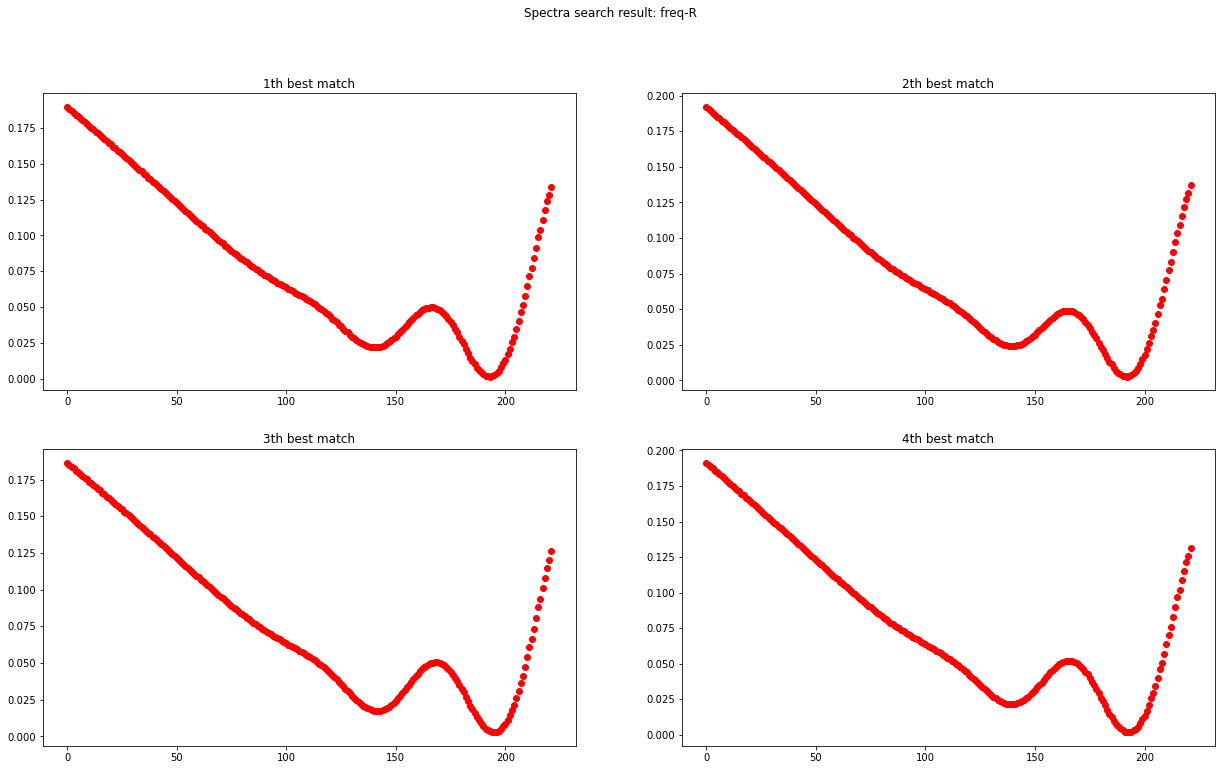

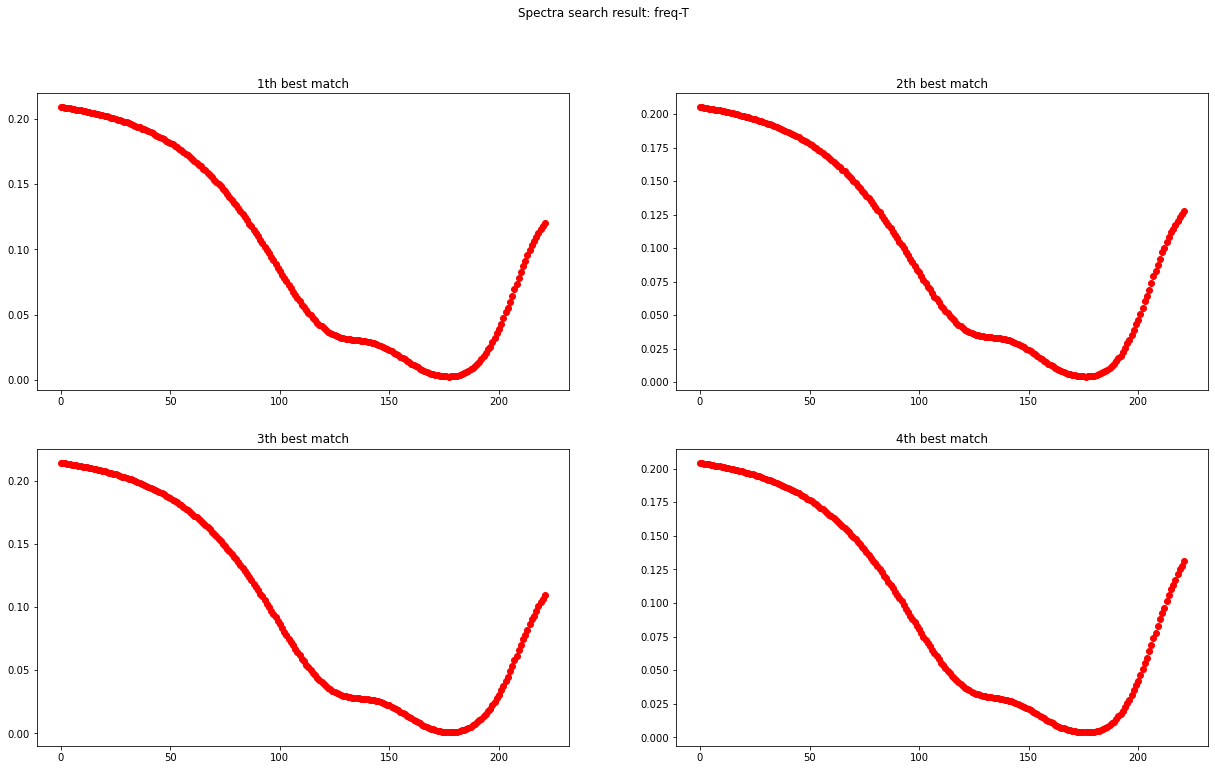

params_pick_visual.shape: (50, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (1014, 4)
R_dict.shape: (1014, 222)
T_dict.shape: (1014, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [150. 132. 160.  75.] params_pick: [150. 132. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [150. 131. 160.  75.] params_pick: [150. 131. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [150. 133. 160.  75.] params_pick: [150. 133. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [149. 132. 160.  75.] params_pick: [149. 132. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [150. 130. 160.  75.] params_pick: [150. 130. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [149. 131. 160.  75.] params_pick: [149. 131. 160.  75.]
--------------------
7 th match
Already in the dict.
# param

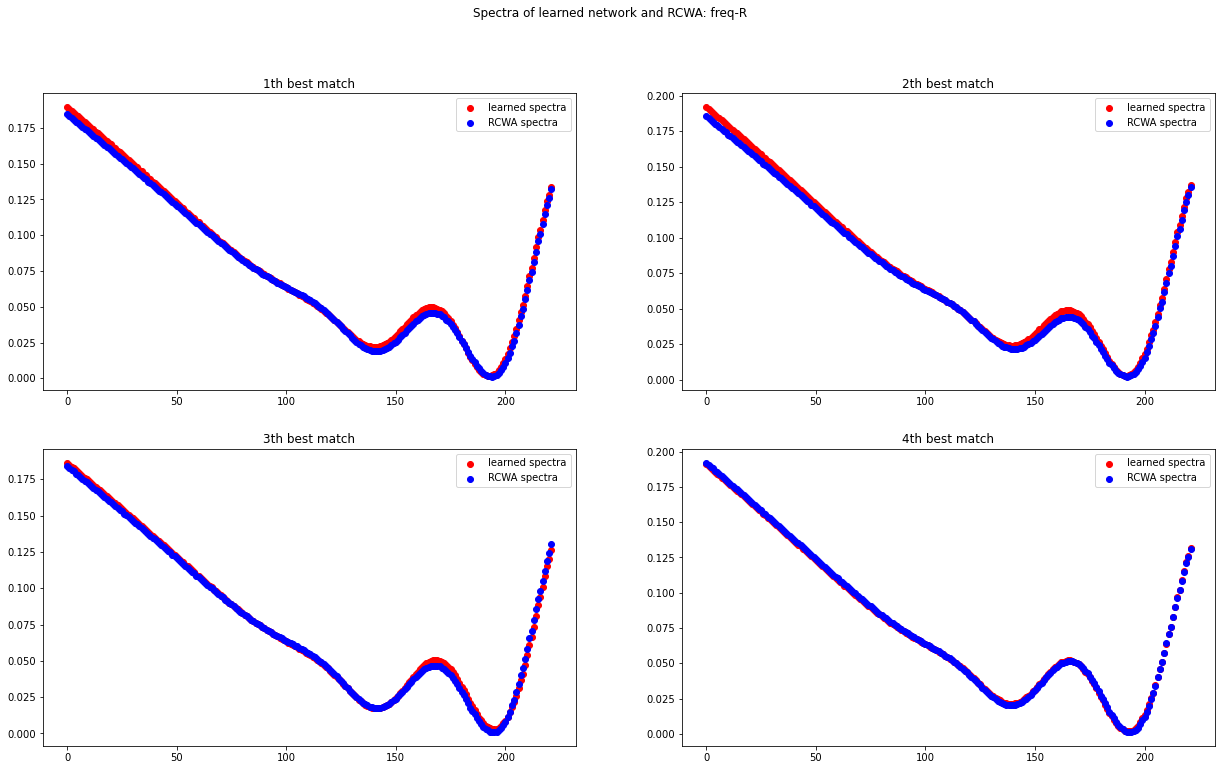

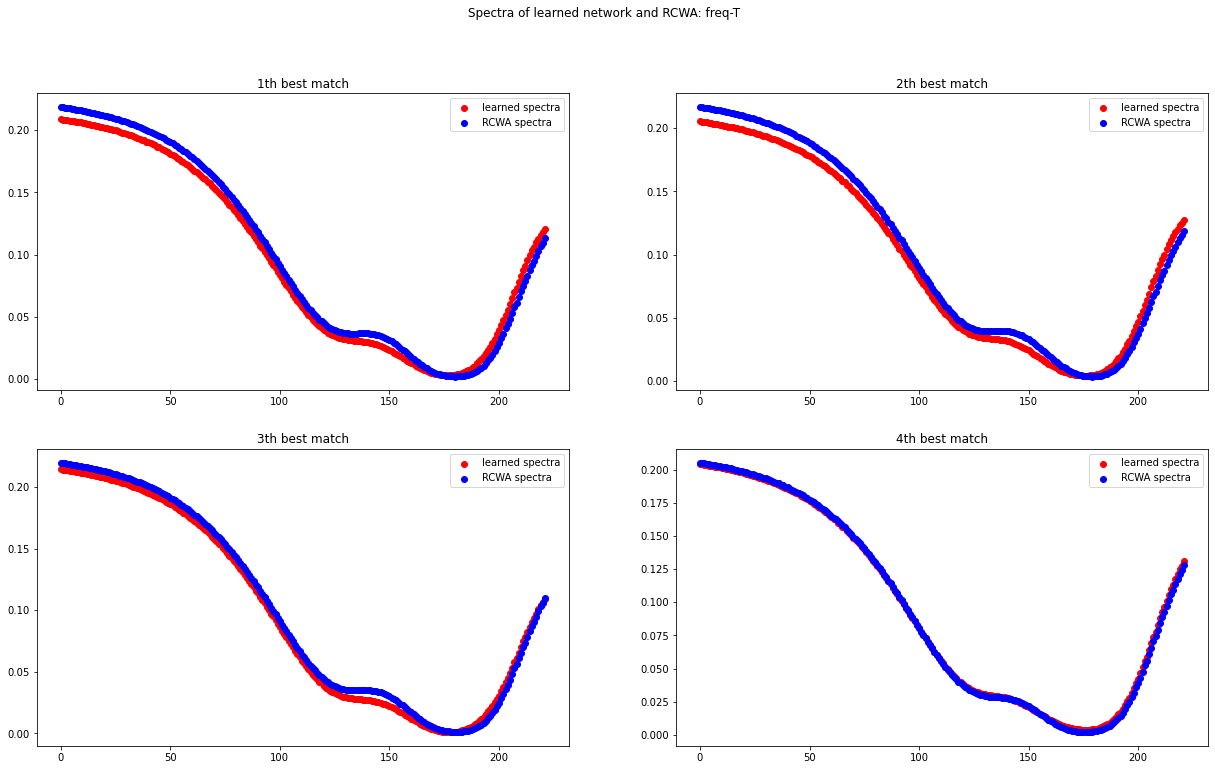

** Model saved.
**************************** ROUND 6 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1200
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [72. 88.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 79. 130.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [104. 147.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [150. 101.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [132. 112.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 64. 129.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [113. 114.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 69. 116.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [ 78. 133.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [97. 74.]
Calculation P

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [111.  67.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [132. 135.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 55. 112.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [147.  61.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [78. 97.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [65. 87.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [144. 118.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [82. 88.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [77. 98.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [87. 71.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [137. 122.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [56. 85.]
Calculation Progress: 100%
-------------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 3.3825108400170244e-05
### TEST LOSS  9.143434888553909e-05
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.794216900044887e-05
### TEST LOSS  9.756900251684581e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 9.520836173445938e-06
### TEST LOSS  8.992945191089853e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 5.9712599819050635e-06
### TEST LOSS  6.118955247479284e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 3.911039387413477e-06
### TEST LOSS  2.456120335460178e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 4.807709255511365e-06
### TEST LOSS  3.01325280815945e-06
----------------------------------------------------------------------
*** 

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.5241996908639995e-06
### TEST LOSS  8.348997811127548e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.5404330817503364e-06
### TEST LOSS  2.1437580244310084e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.4323052666635286e-06
### TEST LOSS  1.187501497826007e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.5218787554260871e-06
### TEST LOSS  2.0262247567694026e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.481948752838728e-06
### TEST LOSS  1.9075625851251566e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 9.787315387477235e-07
### TEST LOSS  1.3062959535798452e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.3973612674493077e-06
### TEST LOSS  8.552063219566561e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 8.873130613492227e-07
### TEST LOSS  8.681106527951165e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.1160868663573352e-06
### TEST LOSS  8.443777975091709e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 4.741578948509091e-06
### TEST LOSS  1.827461902495189e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 2.2326465974783123e-06
### TEST LOSS  4.132975050197274e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.1185066044265095e-06
### TEST LOSS  1.311800060774557e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 6.171185503027013e-07
### TEST LOSS  6.330495775980833e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 8.676296917009551e-07
### TEST LOSS  8.605817672307442e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 6.173973575525812e-07
### TEST LOSS  5.298415809799432e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 7.381702457494772e-07
### TEST LOSS  6.998498855005487e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.259057432315511e-07
### TEST LOSS  7.207138171199606e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 7.587569977947813e-07
### TEST LOSS  6.225822062333464e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 4.6472756324374607e-07
### TEST LOSS  4.654390658566222e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 4.5609658093859196e-07
### TEST LOSS  4.914833892952528e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 4.803570174723622e-07
### TEST LOSS  3.51992791062609e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 5.242299562979725e-07
### TEST LOSS  4.806475541525085e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.136862962454377e-07
### TEST LOSS  3.922851779710375e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 4.6438040953352316e-07
### TEST LOSS  3.472968259643494e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.807460116662554e-07
### TEST LOSS  5.227613131511235e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 8.821309045655331e-07
### TEST LOSS  4.264122392467268e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 9.201061222500566e-07
### TEST LOSS  6.618018757207109e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.913683917313506e-07
### TEST LOSS  4.4037219026904495e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 5.13903238118137e-07
### TEST LOSS  4.402698610622085e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.469607880481675e-07
### TEST LOSS  4.850599503293374e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.635500340703184e-07
### TEST LOSS  4.079457877676557e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.2930856503531345e-07
### TEST LOSS  4.3864664513017084e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.1359579350105e-07
### TEST LOSS  4.295927816934232e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.8173660403077275e-07
### TEST LOSS  3.112397466667163e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 5.043707091356708e-07
### TEST LOSS  5.794657861694456e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.78954459950387e-07
### TEST LOSS  5.231805981035601e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.910160642206506e-07
### TEST LOSS  4.138583433485918e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.2366674258313234e-07
### TEST LOSS  3.624646356886135e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.917034883530827e-07
### TEST LOSS  6.038520976087764e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.793983433049893e-07
### TEST LOSS  2.620533115936673e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.800162301370591e-07
### TEST LOSS  4.4413462616274853e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.927756383352114e-07
### TEST LOSS  3.118425987559527e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.0475875095147274e-07
### TEST LOSS  3.2756226491730763e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.792187569532738e-07
### TEST LOSS  4.0878337870253745e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.6440573289174834e-07
### TEST LOSS  2.9486958810467615e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 6.48852920255294e-07
### TEST LOSS  3.2329528525881164e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 1.5391908066645735e-06
### TEST LOSS  6.360193004360958e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.933194498975742e-07
### TEST LOSS  5.230269708691695e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.0368739873268093e-07
### TEST LOSS  2.93497446395779e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.29403762950875e-07
### TEST LOSS  3.3988283358136567e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.2096771799494663e-07
### TEST LOSS  2.5641364231887565e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.232584633593698e-07
### TEST LOSS  6.338698060264708e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.550105796733798e-07
### TEST LOSS  4.448614119054481e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.792345516284712e-07
### TEST LOSS  3.4675992487286243e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.4692551557450696e-07
### TEST LOSS  2.9807246290955743e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.8327402390514465e-07
### TEST LOSS  6.209121639560383e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.828416807571955e-07
### TEST LOSS  2.967560506464098e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.540623305061293e-07
### TEST LOSS  2.714242318309819e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.9777634965136124e-07
### TEST LOSS  4.371986016672559e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.750123407719741e-07
### TEST LOSS  2.396603188496253e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.2167514662173603e-07
### TEST LOSS  2.7920820855342754e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.3642313590635335e-07
### TEST LOSS  3.591650299641616e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.313162517611564e-07
### TEST LOSS  3.5171530201852067e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 1.0270999804854833e-06
### TEST LOSS  3.7177697878279207e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.749339852957926e-07
### TEST LOSS  3.2746065730609393e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.4721061012395653e-07
### TEST LOSS  2.488580861381706e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.3664995932862025e-07
### TEST LOSS  2.854180781102716e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.2031672575409213e-07
### TEST LOSS  3.294420136196802e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.488019628713109e-07
### TEST LOSS  2.9896967390641294e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.1217120192531905e-07
### TEST LOSS  3.6733141447105783e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.574945137074792e-07
### TEST LOSS  4.277900763503971e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.3129381211397893e-07
### TEST LOSS  4.448205746459482e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.6784196822440643e-07
### TEST LOSS  2.7905785928952457e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.9735058453717045e-07
### TEST LOSS  2.512659544133082e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.368447068297087e-07
### TEST LOSS  3.448922711868363e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.151825438078385e-07
### TEST LOSS  2.983098505006233e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.1806578738654185e-07
### TEST LOSS  5.251564421845009e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.316273230039949e-07
### TEST LOSS  4.5340017764930155e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.3399918074235777e-07
### TEST LOSS  2.359999792626392e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.520313488403204e-07
### TEST LOSS  2.618153279361953e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.212358799468499e-07
### TEST LOSS  2.2752657318708063e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.0459840212770926e-07
### TEST LOSS  2.318093245258347e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 2.913733186756436e-07
### TEST LOSS  3.021715855311413e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.93308871938495e-07
### TEST LOSS  2.856546896307716e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.195126459617133e-07
### TEST LOSS  3.0182846602302663e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.4705605774121294e-07
### TEST LOSS  2.312421779985622e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.0472946236000574e-07
### TEST LOSS  3.1663664638396466e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.2540025300953347e-07
### TEST LOSS  2.860708489846628e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.111236296208612e-07
### TEST LOSS  2.5254222811731273e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.054067415586559e-07
### TEST LOSS  2.4807679939916244e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.672996850246652e-07
### TEST LOSS  2.525586424440007e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.461394944981322e-07
### TEST LOSS  2.981954049611583e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.2838633533908517e-07
### TEST LOSS  3.5160183150158747e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.103542035691002e-07
### TEST LOSS  2.908526215921686e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.8310053126053464e-07
### TEST LOSS  2.513648880153596e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.072904372469765e-07
### TEST LOSS  2.65498667002046e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.8608158525974166e-07
### TEST LOSS  2.9917919559036614e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.746641136945153e-07
### TEST LOSS  2.309325803177368e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.6711646138544155e-07
### TEST LOSS  3.171326423196458e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 2.9711886465833006e-07
### TEST LOSS  1.9380790819114838e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.0267063211445825e-07
### TEST LOSS  2.001161113361781e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.1011515334652035e-07
### TEST LOSS  2.855189333356773e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.883414933929629e-07
### TEST LOSS  3.2662567801051205e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.085885935198244e-07
### TEST LOSS  2.841439328765066e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.3624528849992193e-07
### TEST LOSS  2.487491299360853e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.069186036756359e-07
### TEST LOSS  2.1819714232959893e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.101523307632211e-07
### TEST LOSS  2.130061665815851e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.777293185562968e-07
### TEST LOSS  2.805071240964531e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.9779990405209846e-07
### TEST LOSS  3.54660891667259e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.64859647085558e-07
### TEST LOSS  2.3199191348213492e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.9438680871833137e-07
### TEST LOSS  4.555265667881435e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.01518382210079e-07
### TEST LOSS  2.894664269269419e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.880821672383386e-07
### TEST LOSS  3.089327809865002e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.0164934220403933e-07
### TEST LOSS  3.6250211050198937e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.8454972389013733e-07
### TEST LOSS  2.465996907908953e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.747689765817777e-07
### TEST LOSS  2.879759364304846e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.9213813888281e-07
### TEST LOSS  2.5712613825766715e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.642929311373147e-07
### TEST LOSS  3.628219723673788e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.965735732403848e-07
### TEST LOSS  4.968285828176199e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.9930587183220797e-07
### TEST LOSS  2.424164501727925e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.785170836879421e-07
### TEST LOSS  2.2646709712464346e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.8560000013833077e-07
### TEST LOSS  2.4410739345941897e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.789472714415098e-07
### TEST LOSS  2.7327292823681796e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.6332686104968416e-07
### TEST LOSS  2.2493031397945944e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.828778189704432e-07
### TEST LOSS  2.1740994071706155e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.870225920729534e-07
### TEST LOSS  1.2724409512227592e-06
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.053320798832952e-07
### TEST LOSS  2.811003459631441e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.5931366406310254e-07
### TEST LOSS  3.104646866505492e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.755579492793222e-07
### TEST LOSS  1.810201339935702e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.692776070552701e-07
### TEST LOSS  2.3205553626818679e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.6286931757102396e-07
### TEST LOSS  1.9187328269430913e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.4511469844797534e-07
### TEST LOSS  3.7170588029766805e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.9788112413757045e-07
### TEST LOSS  3.107224620811798e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.435191062036343e-07
### TEST LOSS  2.0002805140645958e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.2298501317473694e-07
### TEST LOSS  2.9437288636321074e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.852207196379908e-07
### TEST LOSS  2.636516553719856e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.111480320905358e-07
### TEST LOSS  3.7221813108266764e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.723572283451029e-07
### TEST LOSS  2.105226997173304e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.8320703667539247e-07
### TEST LOSS  1.8793794885772917e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.637959765502037e-07
### TEST LOSS  1.8522661251710008e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.637792973558817e-07
### TEST LOSS  2.1511648798069575e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.833590504902617e-07
### TEST LOSS  2.4874231583124936e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.6958664549455355e-07
### TEST LOSS  3.5086631239917347e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.5278164677603836e-07
### TEST LOSS  2.2825122177512944e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.4324026054530397e-07
### TEST LOSS  2.466707284851408e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.5544485472058416e-07
### TEST LOSS  5.177770627066517e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.6372824314317236e-07
### TEST LOSS  2.119185388159571e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.732282134498831e-07
### TEST LOSS  3.653718512926692e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.63660009682809e-07
### TEST LOSS  2.845182775798902e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.590958800633795e-07
### TEST LOSS  1.915241764688997e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.4191932040433055e-07
### TEST LOSS  3.331339226204161e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.610021409873061e-07
### TEST LOSS  4.791610576957181e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.9316515876676163e-07
### TEST LOSS  2.284024450065974e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.921051044853703e-07
### TEST LOSS  2.1945240212693938e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.708669790655686e-07
### TEST LOSS  1.938878142482281e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.4679366898390973e-07
### TEST LOSS  1.96197237616818e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.5279395185743664e-07
### TEST LOSS  2.0197240739131908e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.3528805126756443e-07
### TEST LOSS  3.230877752002925e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.6782501351500323e-07
### TEST LOSS  4.3403539488432824e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.626766324409502e-07
### TEST LOSS  2.5639731088884014e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.6891603346198184e-07
### TEST LOSS  4.764437433222055e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.508630919913675e-07
### TEST LOSS  1.9405351281420735e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.6398057908346334e-07
### TEST LOSS  4.058085431147952e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.672082215774789e-07
### TEST LOSS  1.7835644428032538e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.3414007182864794e-07
### TEST LOSS  2.410153238467198e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.2878156021940063e-07
### TEST LOSS  2.8425564282643893e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.53766067954686e-07
### TEST LOSS  3.3132033807861364e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.439444949745943e-07
### TEST LOSS  5.615317001507315e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.4644744374135995e-07
### TEST LOSS  2.609434004183539e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.6478905172636996e-07
### TEST LOSS  2.3831660911355357e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.712141011151914e-07
### TEST LOSS  2.1821482221184851e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.5375432121332865e-07
### TEST LOSS  2.1657266794742705e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.442558188701464e-07
### TEST LOSS  2.8989259230153647e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.7916948736717017e-07
### TEST LOSS  1.8732157592972322e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.5543074753405413e-07
### TEST LOSS  2.2834282178665592e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.026142315798452e-07
### TEST LOSS  1.5441621709694826e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.696249553135743e-07
### TEST LOSS  2.5022909650513407e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.3064385876736537e-07
### TEST LOSS  2.3056855348436835e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.400417284705488e-07
### TEST LOSS  1.781361255047563e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.4987213061174646e-07
### TEST LOSS  3.4732364895262435e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.459441090992461e-07
### TEST LOSS  2.171911922409385e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.4541309685321976e-07
### TEST LOSS  1.943946033280655e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.351714555270945e-07
### TEST LOSS  2.4571090762037784e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.3144300696387176e-07
### TEST LOSS  2.6162912468584585e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.66392359552133e-07
### TEST LOSS  1.9806233492797926e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.2998868243047828e-07
### TEST LOSS  2.8069506659752125e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.3677119928677825e-07
### TEST LOSS  1.9738195078389253e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.4280123358533243e-07
### TEST LOSS  4.772653928360645e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.175654292931502e-07
### TEST LOSS  2.721732488768996e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.65950245733985e-07
### TEST LOSS  1.8787076704206305e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.449577108828057e-07
### TEST LOSS  1.909093391026949e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.1791843038373078e-07
### TEST LOSS  2.546814836061155e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.3807605770513144e-07
### TEST LOSS  3.5897068784152e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.2273847038197422e-07
### TEST LOSS  2.2058242797761017e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.412688031035633e-07
### TEST LOSS  2.004555399695265e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.7492923884153695e-07
### TEST LOSS  3.0256777626568186e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.969019245139629e-07
### TEST LOSS  3.8883550562079313e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.268638597261822e-07
### TEST LOSS  2.0375057690418745e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.1084216140702475e-07
### TEST LOSS  3.9146652378955576e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.564992509723751e-07
### TEST LOSS  2.2822172083023259e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.6411898542170555e-07
### TEST LOSS  3.319905867253207e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.449739307304929e-07
### TEST LOSS  1.7517023407107342e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.4066237826729044e-07
### TEST LOSS  2.146412083132216e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.3735834544957868e-07
### TEST LOSS  1.9873581180718247e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.683809624715039e-07
### TEST LOSS  2.3279074273179705e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.2379339350120376e-07
### TEST LOSS  2.281845689190555e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.554069411801289e-07
### TEST LOSS  1.8797004723107116e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.5189368702438486e-07
### TEST LOSS  3.2558844035672035e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.5268172977988e-07
### TEST LOSS  2.1329479219881856e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.4141120816019895e-07
### TEST LOSS  2.2352483755286005e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.3511949938844387e-07
### TEST LOSS  2.377456240765241e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.293499668774383e-07
### TEST LOSS  3.4210196670553865e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.469975549290737e-07
### TEST LOSS  1.6749112319303094e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.341883981908192e-07
### TEST LOSS  2.413381399909061e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.3983310489879744e-07
### TEST LOSS  2.507906139549555e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.255762168064853e-07
### TEST LOSS  1.6431519453716544e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.29606730419718e-07
### TEST LOSS  1.7471648463798476e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.5348799882400166e-07
### TEST LOSS  2.536044097685893e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.3049705744219532e-07
### TEST LOSS  5.293720038126695e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.2252340864022576e-07
### TEST LOSS  2.768318899547416e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.2423954300817192e-07
### TEST LOSS  2.0087566178340745e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.1823540431971841e-07
### TEST LOSS  2.0498898657529531e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.520899178944565e-07
### TEST LOSS  2.560145091479171e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.1338788316634568e-07
### TEST LOSS  1.61342761373362e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.2042479124628756e-07
### TEST LOSS  4.4443447835520703e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.6618364987148384e-07
### TEST LOSS  1.87584116733635e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.4157273401955357e-07
### TEST LOSS  2.282258553994628e-07
** loss_train 2.4157273401955357e-07
** loss_test 2.282258553994628e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


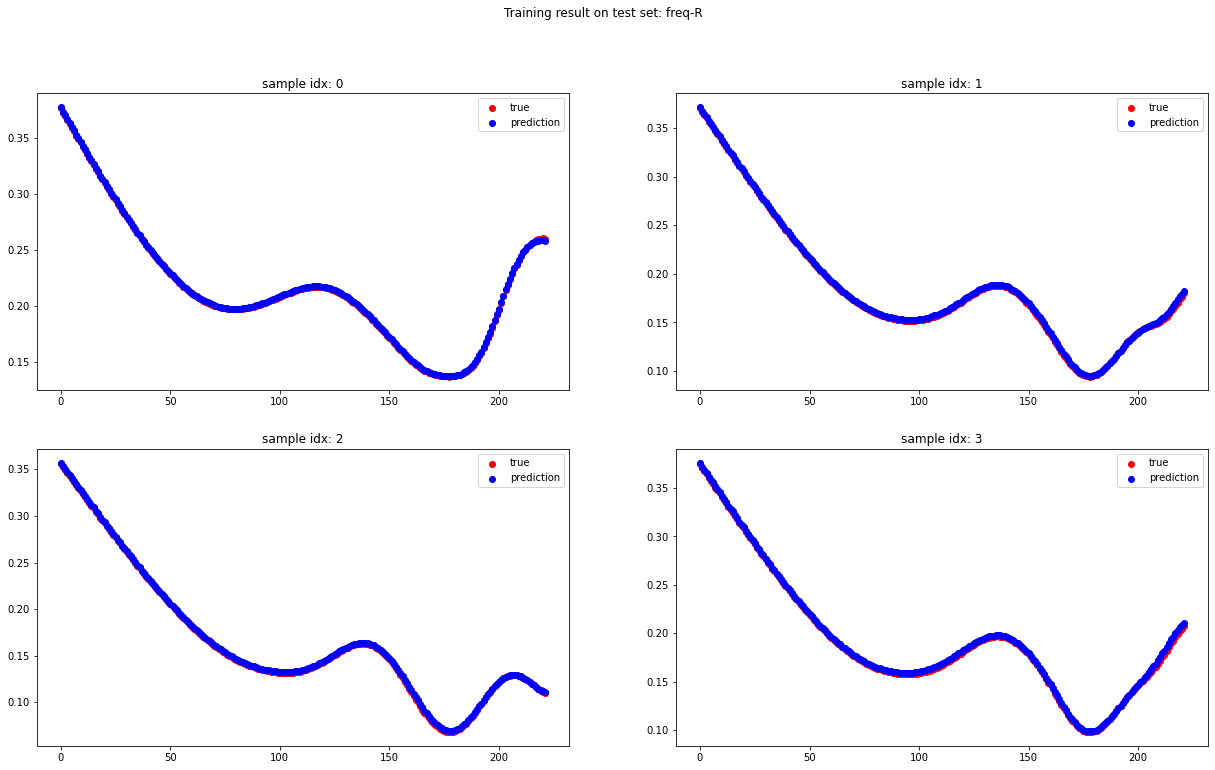

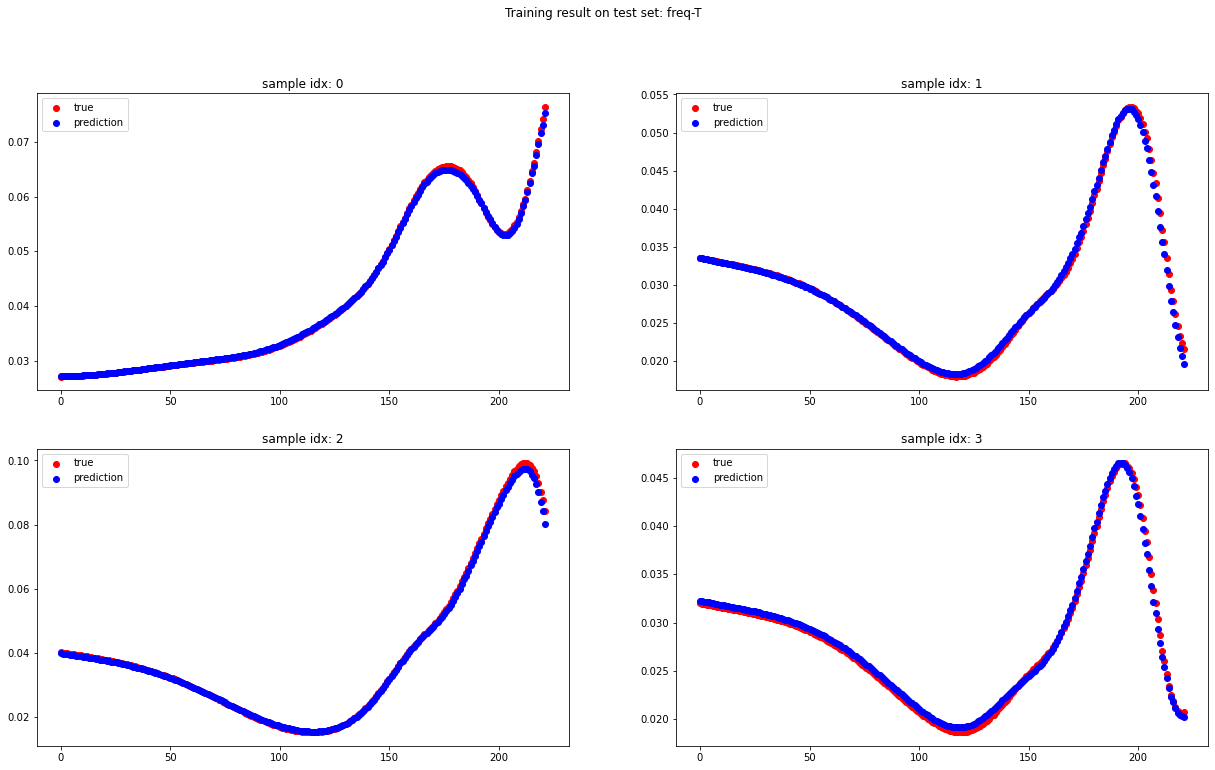

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

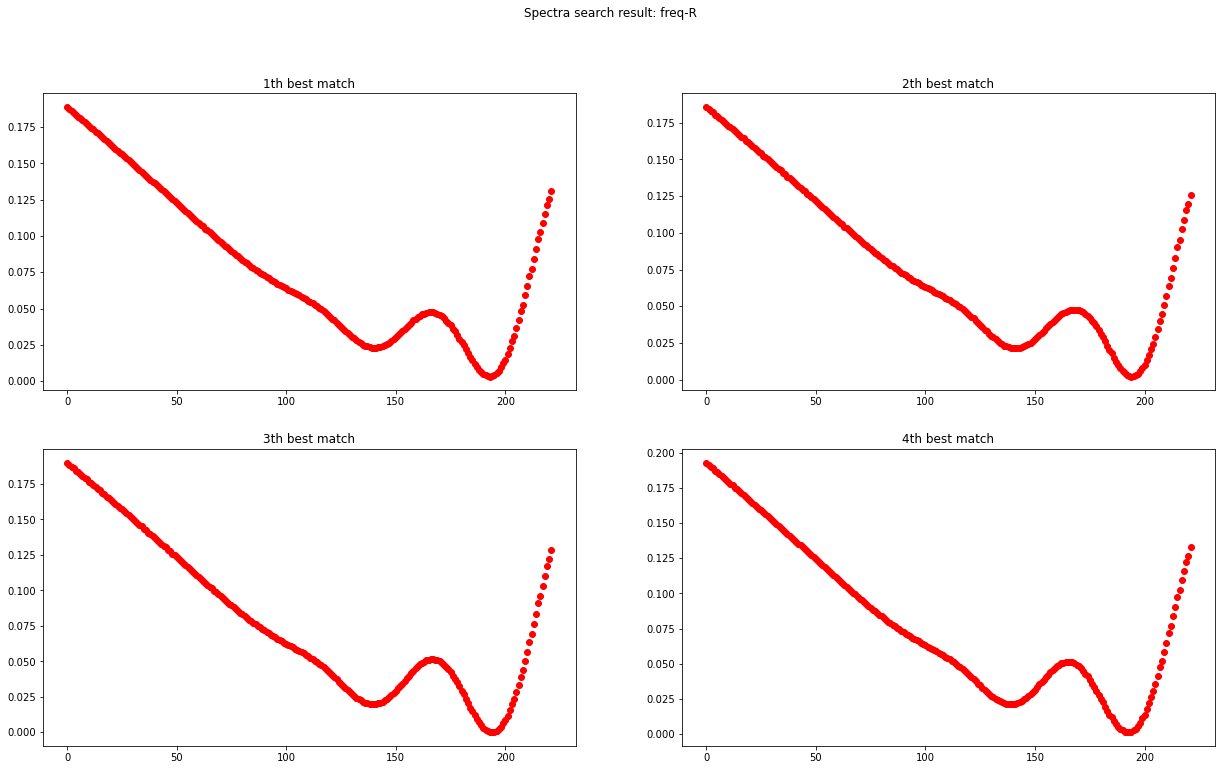

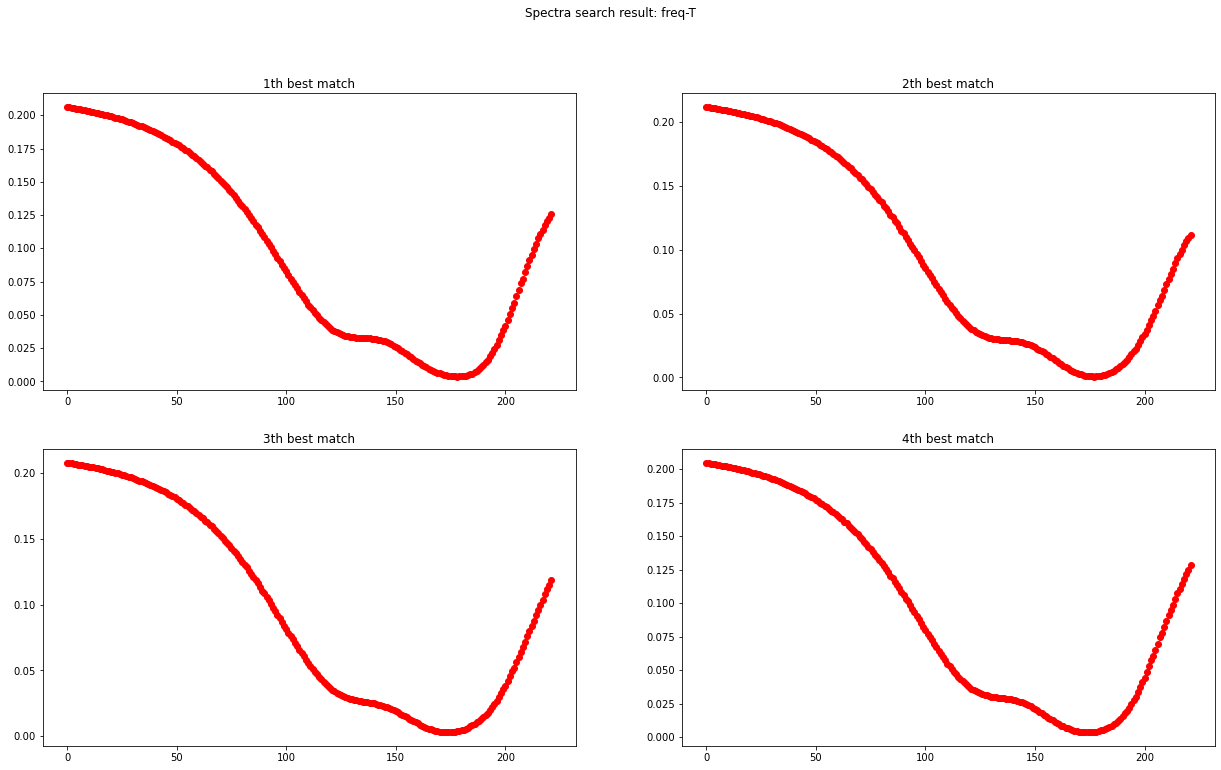

params_pick_visual.shape: (60, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (1214, 4)
R_dict.shape: (1214, 222)
T_dict.shape: (1214, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [150. 131. 160.  75.] params_pick: [150. 131. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [150. 132. 160.  75.] params_pick: [150. 132. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [149. 133. 160.  75.] params_pick: [149. 133. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [149. 132. 160.  75.] params_pick: [149. 132. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [149. 131. 160.  75.] params_pick: [149. 131. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [150. 130. 160.  75.] params_pick: [150. 130. 160.  75.]
--------------------
7 th match
Already in the dict.
# param

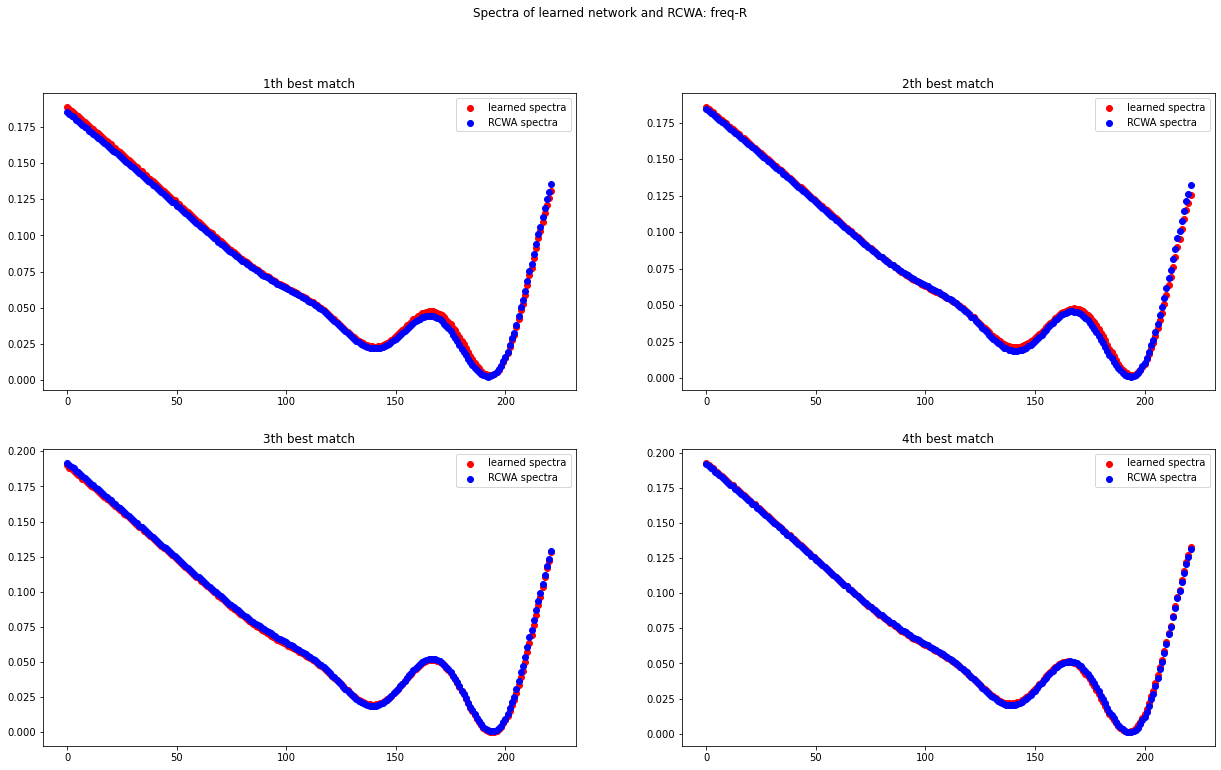

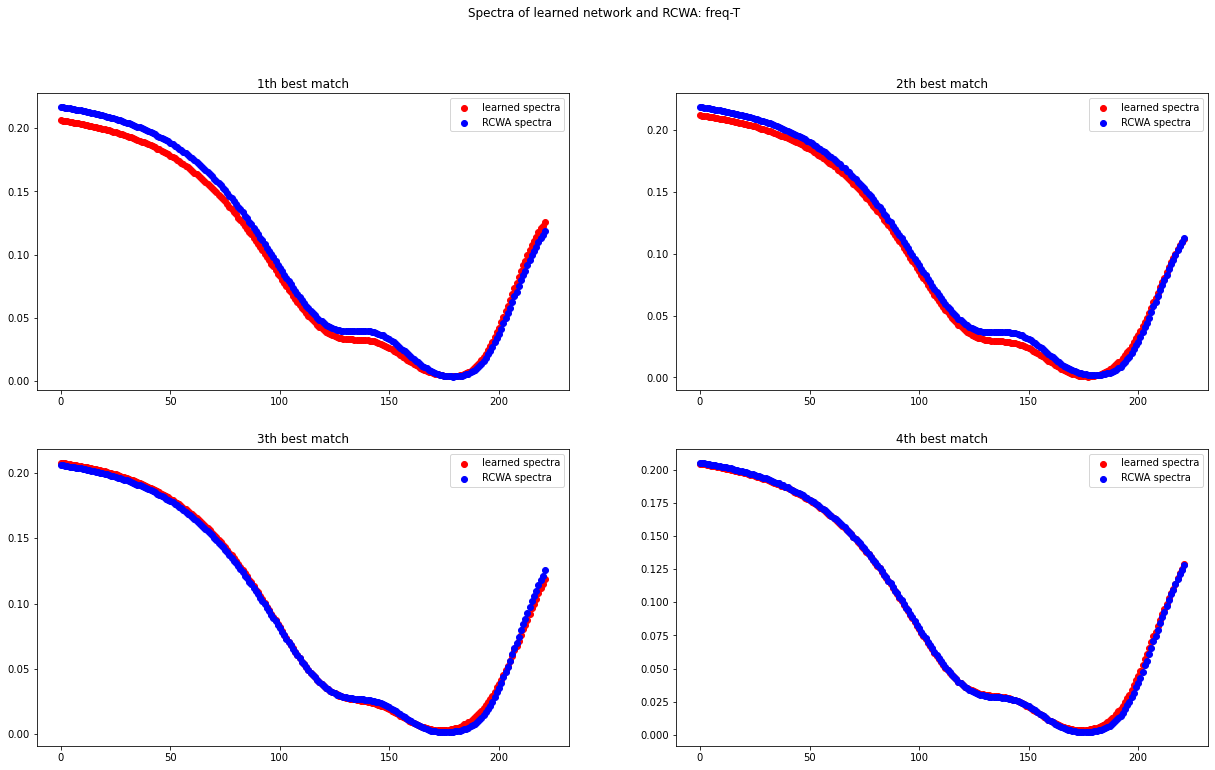

** Model saved.
**************************** ROUND 7 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1400
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [111.  91.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [73. 91.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [134. 142.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [107.  96.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [69. 62.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 79. 133.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [ 66. 107.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [58. 81.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [124. 144.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 70. 130.]
Calculation Pro

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 62. 112.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [66. 62.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [93. 83.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [100.  95.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [94. 96.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [139. 130.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [62. 72.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [125. 107.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [ 52. 122.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [110.  92.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [76. 64.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [66. 56.]
Calculation Progress: 100%
-------------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 2.9412595646038297e-05
### TEST LOSS  0.00011491949193110817
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.3898619021485307e-05
### TEST LOSS  4.428025125558964e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 7.402442159271264e-06
### TEST LOSS  3.947728854117568e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 4.989974509206669e-06
### TEST LOSS  4.15646225478254e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 6.142800456519889e-06
### TEST LOSS  2.9000682905627233e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 3.3465739750835966e-06
### TEST LOSS  2.3677683316236653e-06
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.2036798286629847e-06
### TEST LOSS  8.514821481433252e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.2308529914000539e-06
### TEST LOSS  1.891014894733251e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 7.894023357023018e-07
### TEST LOSS  7.424634825332016e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.1896371210694058e-06
### TEST LOSS  7.29965571302025e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.0430602342483195e-06
### TEST LOSS  8.897994118487159e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.2221561065065398e-06
### TEST LOSS  7.40233670884746e-07
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.286259260514352e-06
### TEST LOSS  1.3885699830366733e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.2780323791109335e-06
### TEST LOSS  1.437850923738634e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 9.801934459769004e-06
### TEST LOSS  3.8042928167669743e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.8172519197483844e-06
### TEST LOSS  3.163921674472063e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.3102240422771923e-06
### TEST LOSS  1.6813830773737044e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.526834760185685e-06
### TEST LOSS  1.2949569465221926e-06
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 6.462947853996022e-07
### TEST LOSS  9.727852534007815e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 6.509435956557143e-07
### TEST LOSS  9.577774384504003e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 1.2913356399327622e-06
### TEST LOSS  1.2737677288689817e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 7.341998504577824e-07
### TEST LOSS  5.772618707892847e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.339041632484412e-07
### TEST LOSS  1.0474556792029366e-06
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 6.206356609946998e-07
### TEST LOSS  6.235442578434397e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 4.966936913421347e-07
### TEST LOSS  5.796853886605194e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 6.196375423529941e-07
### TEST LOSS  7.355873453785865e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 5.202835298057096e-07
### TEST LOSS  4.31067306294608e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.007749571423915e-07
### TEST LOSS  6.392836708486853e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.474245747169196e-07
### TEST LOSS  1.4005795905673453e-06
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.47629432196471e-07
### TEST LOSS  7.392055543029776e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.360680203317559e-07
### TEST LOSS  4.015957583450555e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.3496637372036114e-07
### TEST LOSS  2.743207984808164e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.5974019432547053e-07
### TEST LOSS  4.672611427477849e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.3437643372509375e-07
### TEST LOSS  3.594159236089664e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.206433622653906e-07
### TEST LOSS  4.263147843630577e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 3.7694785393505014e-07
### TEST LOSS  3.0417529020806716e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.573143945561599e-07
### TEST LOSS  3.977259488217235e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.176300170552086e-07
### TEST LOSS  6.124022617500073e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.494077921205327e-07
### TEST LOSS  6.214976480123369e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.0795080616971645e-07
### TEST LOSS  3.542173507236674e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.2933797786558003e-07
### TEST LOSS  4.4156764612456423e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.352561108638448e-07
### TEST LOSS  4.456235287038494e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.961452484243669e-07
### TEST LOSS  3.4199703303660167e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.179625054107865e-07
### TEST LOSS  3.596929700351707e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.5840600282152724e-07
### TEST LOSS  3.2517437243872005e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.822815011693998e-07
### TEST LOSS  5.350317658005885e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.849297140387112e-07
### TEST LOSS  3.545754119407072e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.02013843314413e-07
### TEST LOSS  2.838466664136583e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.132008163334636e-07
### TEST LOSS  3.8221360460449266e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.136559827903698e-07
### TEST LOSS  4.1281921105771535e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.0171323936886793e-07
### TEST LOSS  2.522301733940615e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.7738776859593974e-07
### TEST LOSS  3.541342198073752e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.893360087658948e-07
### TEST LOSS  3.5819763090991974e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.991563638397874e-07
### TEST LOSS  5.092841090262564e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.4066317923908683e-07
### TEST LOSS  2.486305748758158e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.680607680729102e-07
### TEST LOSS  1.4967524541795931e-06
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.4996381659651825e-07
### TEST LOSS  5.429816770753281e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.815802402419775e-07
### TEST LOSS  2.988943537926306e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.6111355311468123e-07
### TEST LOSS  2.573608649020736e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.3625504998445267e-07
### TEST LOSS  2.3022897075654988e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.842812937548956e-07
### TEST LOSS  2.8374782475153054e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.72588138137786e-07
### TEST LOSS  5.818755035782239e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.702360084670683e-07
### TEST LOSS  4.905058210107943e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.8503924585851583e-07
### TEST LOSS  2.440636499365858e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.497943990688717e-07
### TEST LOSS  4.5717764152186646e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.5331375171564006e-07
### TEST LOSS  3.063395433080338e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.3852127576418567e-07
### TEST LOSS  3.099588031897259e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.4961313393517504e-07
### TEST LOSS  3.8101462962458754e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.4339399429888266e-07
### TEST LOSS  3.250621990570256e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.7843282737577105e-07
### TEST LOSS  5.838052433401489e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.625035073946086e-07
### TEST LOSS  2.7658362711235895e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.1543732654221963e-07
### TEST LOSS  6.032345835778456e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.557258591564099e-07
### TEST LOSS  2.575580275922882e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.323840017951544e-07
### TEST LOSS  2.566381014772064e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.279490951843148e-07
### TEST LOSS  2.9426650950302824e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.2017592656379587e-07
### TEST LOSS  5.111403063231343e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.326791391471724e-07
### TEST LOSS  2.1215385973246984e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.6115819847129926e-07
### TEST LOSS  3.5295326354530104e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 4.800611519328868e-07
### TEST LOSS  3.7409104565581813e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.040355796800351e-07
### TEST LOSS  3.9189495479066944e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.6009301557829837e-07
### TEST LOSS  3.4633457475634216e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.142172242474674e-07
### TEST LOSS  2.339306064413904e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.912773870418107e-07
### TEST LOSS  2.3600707747691144e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.5761977005118896e-07
### TEST LOSS  3.5767993076454085e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.0646258144021287e-07
### TEST LOSS  2.904944952061586e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.455261795615172e-07
### TEST LOSS  2.453580139868708e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.9419778966501197e-07
### TEST LOSS  2.9518836248081987e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.384089088319188e-07
### TEST LOSS  2.776407764703105e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.022513349978543e-07
### TEST LOSS  2.717674166516107e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.263710853954446e-07
### TEST LOSS  3.9862637699818815e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.362789619844518e-07
### TEST LOSS  2.1784278268135246e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.255037879615738e-07
### TEST LOSS  2.54521605246406e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.725994379686983e-07
### TEST LOSS  2.521158419002942e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.070466614575805e-07
### TEST LOSS  3.782273313132381e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.1568227190399105e-07
### TEST LOSS  3.141053826735432e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.156149200808248e-07
### TEST LOSS  2.469356184581722e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.0907701937746673e-07
### TEST LOSS  4.099575299030469e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.099140881422459e-07
### TEST LOSS  3.767317531872488e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.008917489376119e-07
### TEST LOSS  3.65399096515582e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.3136454490037944e-07
### TEST LOSS  3.396739226053052e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.3245615370246033e-07
### TEST LOSS  3.870124422953516e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.883758007067781e-07
### TEST LOSS  2.7713262085171664e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.9962854498981936e-07
### TEST LOSS  3.641178755680647e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.874414942206321e-07
### TEST LOSS  2.25837468160638e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.9489704163562383e-07
### TEST LOSS  3.745599715640227e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 2.936817907198527e-07
### TEST LOSS  2.666209869449755e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.2062145023127794e-07
### TEST LOSS  8.123609621758409e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.8781122929112866e-07
### TEST LOSS  2.197589898339009e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.165757343432623e-07
### TEST LOSS  2.8264089476951165e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 2.895685503823131e-07
### TEST LOSS  2.673833841206694e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.7876996529079587e-07
### TEST LOSS  3.235332777442388e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.042596509139628e-07
### TEST LOSS  2.7878902257457e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.314698411876244e-07
### TEST LOSS  2.1431306797901264e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.990248089445353e-07
### TEST LOSS  3.8321739478678035e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.171460252003401e-07
### TEST LOSS  2.3859989668876963e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.225530934182684e-07
### TEST LOSS  2.736858187352647e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.042915404678175e-07
### TEST LOSS  3.2775075873494397e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.9072690298091534e-07
### TEST LOSS  3.8092744861470157e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.8576044753845865e-07
### TEST LOSS  2.422400898054052e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.945080035703691e-07
### TEST LOSS  1.9512514561690544e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.34481996582576e-07
### TEST LOSS  2.1380385203687266e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.0747299361572846e-07
### TEST LOSS  4.150963222441946e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.9910753234726633e-07
### TEST LOSS  2.0426490042847367e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.632587695191749e-07
### TEST LOSS  2.2522560301622849e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.739545977892277e-07
### TEST LOSS  3.53774835688951e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.6125825596626636e-07
### TEST LOSS  2.2597299159149936e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.8289697552149766e-07
### TEST LOSS  2.1457804422198024e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.7181516000546985e-07
### TEST LOSS  3.657327480058567e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.747930541373884e-07
### TEST LOSS  2.5092296531490566e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 4.6376516365980484e-07
### TEST LOSS  2.878992333421593e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.968196565029351e-07
### TEST LOSS  2.6571733128962066e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.8161947086578566e-07
### TEST LOSS  3.0642905748188487e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.7762275841399944e-07
### TEST LOSS  2.3197675344280552e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.743954781690507e-07
### TEST LOSS  1.9106295923165817e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.648482970281561e-07
### TEST LOSS  2.977185728654645e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.7486941253635726e-07
### TEST LOSS  2.234275439408603e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.639710923167473e-07
### TEST LOSS  1.980219947613064e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.990893904732315e-07
### TEST LOSS  3.4983296550515e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.0798453801241166e-07
### TEST LOSS  2.471874399713091e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.765413487385412e-07
### TEST LOSS  2.0852083340824637e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.7148589433169586e-07
### TEST LOSS  1.8594636359962766e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.7866183103876706e-07
### TEST LOSS  2.552734027393523e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.9704422822415414e-07
### TEST LOSS  2.427001032468855e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.7263458133498985e-07
### TEST LOSS  2.682052450030493e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.6261735371743303e-07
### TEST LOSS  3.3946370143150323e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.6488045101175874e-07
### TEST LOSS  2.4651893617353626e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.7295303616955585e-07
### TEST LOSS  2.074155744935524e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.7982684647146323e-07
### TEST LOSS  3.01343612689338e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.796041987096487e-07
### TEST LOSS  1.8738093129658492e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.6084816230184264e-07
### TEST LOSS  1.7461002728551153e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.930575998075621e-07
### TEST LOSS  1.9100376359336801e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.652658658419682e-07
### TEST LOSS  2.1522397569190782e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.574509346927759e-07
### TEST LOSS  3.6219906136962393e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.8945277326743375e-07
### TEST LOSS  2.137410397360575e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.529697072604721e-07
### TEST LOSS  3.406745050101149e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.043441727726811e-07
### TEST LOSS  2.2665993203542134e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.9533440862142666e-07
### TEST LOSS  2.4892881743777584e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.5249511814833573e-07
### TEST LOSS  2.311690255784139e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.6525678451453214e-07
### TEST LOSS  2.681712190492776e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.6485268901715084e-07
### TEST LOSS  3.454723130599549e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.7082297372312984e-07
### TEST LOSS  1.9768084769111738e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.8724336779869676e-07
### TEST LOSS  2.487656183673566e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.6751406458152313e-07
### TEST LOSS  2.416803707464252e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.538080748390062e-07
### TEST LOSS  2.8627035610704543e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.8732867478810574e-07
### TEST LOSS  2.0374864042403054e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.631891891599228e-07
### TEST LOSS  2.823564838908252e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.627964194536401e-07
### TEST LOSS  2.2003195386911434e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.6737058758742805e-07
### TEST LOSS  2.148870049981352e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.6259869784947147e-07
### TEST LOSS  2.1041681593074332e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.7174372070908656e-07
### TEST LOSS  2.2092846630915697e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.6278721830712875e-07
### TEST LOSS  1.8753878030317786e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.6741993048418066e-07
### TEST LOSS  2.690372937763641e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.6940773550825674e-07
### TEST LOSS  8.487399247252886e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.578875578228081e-07
### TEST LOSS  2.388525495369074e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.832240801721651e-07
### TEST LOSS  3.405418473272965e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.5554230633265517e-07
### TEST LOSS  2.446141506724912e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.662254338276731e-07
### TEST LOSS  2.6641843672595395e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.6768029328089987e-07
### TEST LOSS  2.1235732848946431e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.779199776029425e-07
### TEST LOSS  1.917394354804132e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.4544136358503213e-07
### TEST LOSS  2.05631067728973e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.651420592769682e-07
### TEST LOSS  1.8238990148492204e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.6468137732089354e-07
### TEST LOSS  3.3009088569583994e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.988018730183078e-07
### TEST LOSS  3.6111260599950995e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.793056688865647e-07
### TEST LOSS  2.267961069047818e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.72681712801973e-07
### TEST LOSS  3.133288208284119e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.7024517951446114e-07
### TEST LOSS  2.0726079632347386e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 3.182764357363104e-07
### TEST LOSS  5.965537132562365e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.7138894056477623e-07
### TEST LOSS  4.637049435338916e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.715196658525138e-07
### TEST LOSS  2.031556908961689e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.495559036359245e-07
### TEST LOSS  3.194956444861997e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.6281301570943836e-07
### TEST LOSS  2.3039893451678753e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.518219874136918e-07
### TEST LOSS  2.857267624924795e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.7314098619716074e-07
### TEST LOSS  3.157850281871271e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.4340745058383715e-07
### TEST LOSS  2.5595541137074013e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.4794268501184187e-07
### TEST LOSS  2.5633906504522613e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.692608091971392e-07
### TEST LOSS  2.1689106236263714e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.3407968890966555e-07
### TEST LOSS  2.7763430536383155e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.3671960549848896e-07
### TEST LOSS  3.173623051628221e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.4855155329588693e-07
### TEST LOSS  3.442096876617804e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.4987159741688253e-07
### TEST LOSS  1.876557895741371e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.4914201725044295e-07
### TEST LOSS  2.66927840315971e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.621312275508103e-07
### TEST LOSS  2.517865667073238e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.6963442514293943e-07
### TEST LOSS  1.7060089195875994e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.5972284133146674e-07
### TEST LOSS  2.6326230924537825e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.3572254412153524e-07
### TEST LOSS  2.6824695256974257e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.2614457023324113e-07
### TEST LOSS  2.1509024541253233e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.3828587385540548e-07
### TEST LOSS  3.0985868093580393e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.559786089647734e-07
### TEST LOSS  2.751128572630147e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.655188197017314e-07
### TEST LOSS  1.8302170898013256e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.425187090856643e-07
### TEST LOSS  1.7708527880441496e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.421930070590455e-07
### TEST LOSS  2.723644120744046e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.517824607473074e-07
### TEST LOSS  2.03924202938052e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.3322411652212542e-07
### TEST LOSS  1.976188108508061e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.570263237482757e-07
### TEST LOSS  2.9382675072817865e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.667489226279177e-07
### TEST LOSS  1.7645783759431569e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.6340101053940705e-07
### TEST LOSS  2.7344902132530147e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.755332578300137e-07
### TEST LOSS  2.6677878330681115e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.618501362393135e-07
### TEST LOSS  2.0449488534847082e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.3565846594765715e-07
### TEST LOSS  2.52070848396422e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.2740934687094848e-07
### TEST LOSS  2.9323788520617777e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.643092490802904e-07
### TEST LOSS  2.4963467575906345e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.684705828492895e-07
### TEST LOSS  1.787544857992626e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.38558639755431e-07
### TEST LOSS  2.0484418977224034e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.5497902467895374e-07
### TEST LOSS  3.2860450522259105e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.4244738602392196e-07
### TEST LOSS  2.9877211008252663e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.3786088764537235e-07
### TEST LOSS  2.436791726784742e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.343073235661868e-07
### TEST LOSS  1.7690862302350235e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.287254720975288e-07
### TEST LOSS  1.9511652544162478e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.4341362724682774e-07
### TEST LOSS  1.7780463065522864e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.495472284737486e-07
### TEST LOSS  2.3292838203691313e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.440557686954138e-07
### TEST LOSS  2.0155806236165186e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.3989499126107563e-07
### TEST LOSS  2.108091758530732e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.669995040438522e-07
### TEST LOSS  2.8390035179303264e-07
** loss_train 2.669995040438522e-07
** loss_test 2.8390035179303264e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


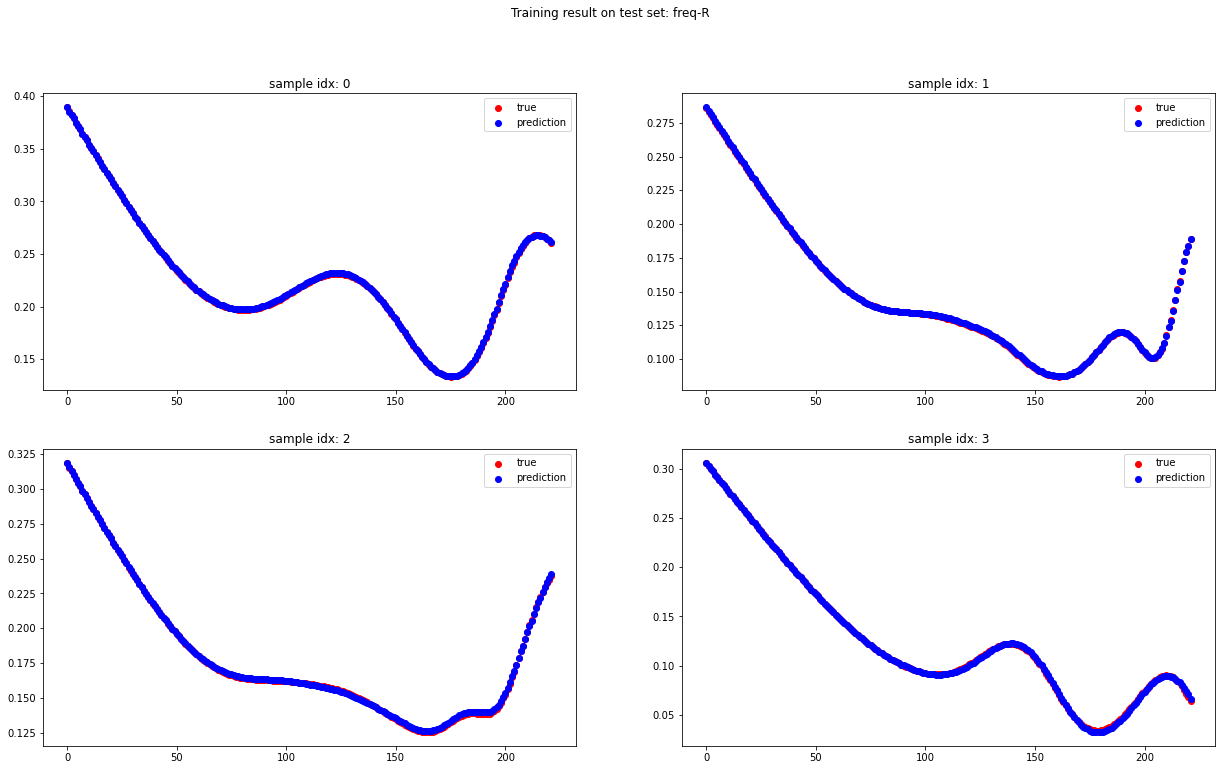

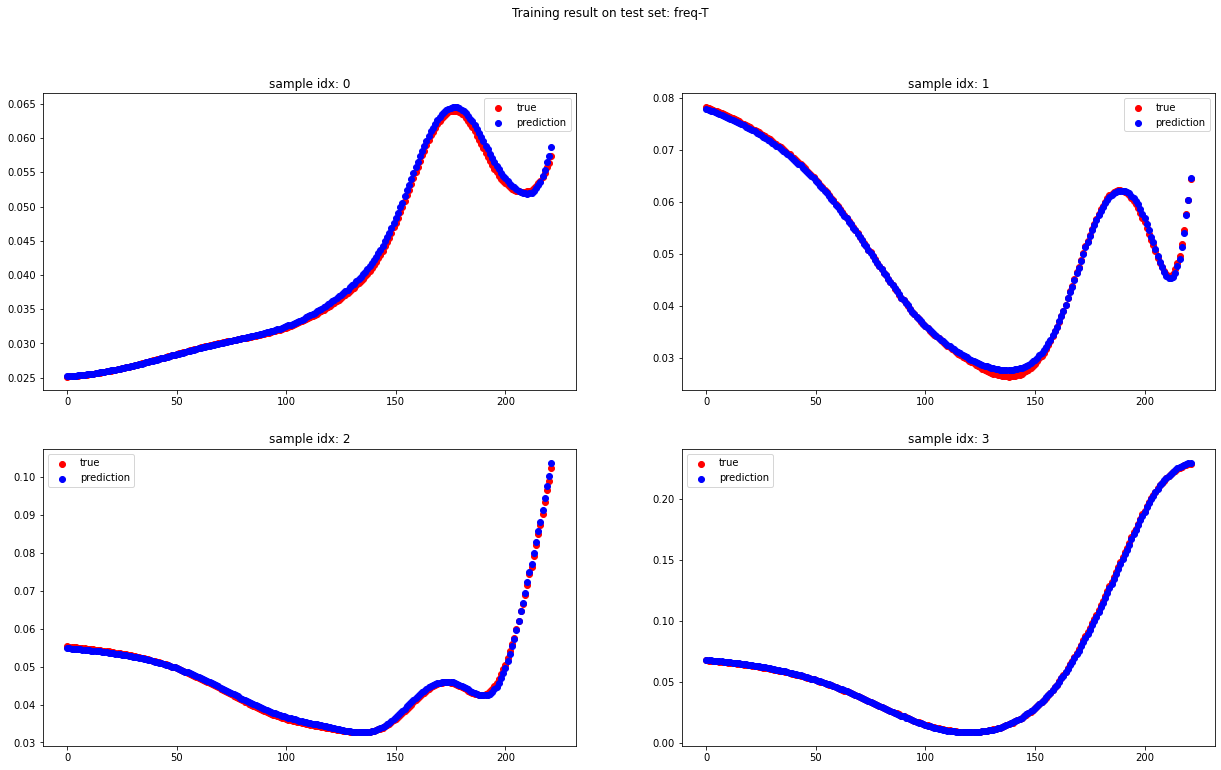

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

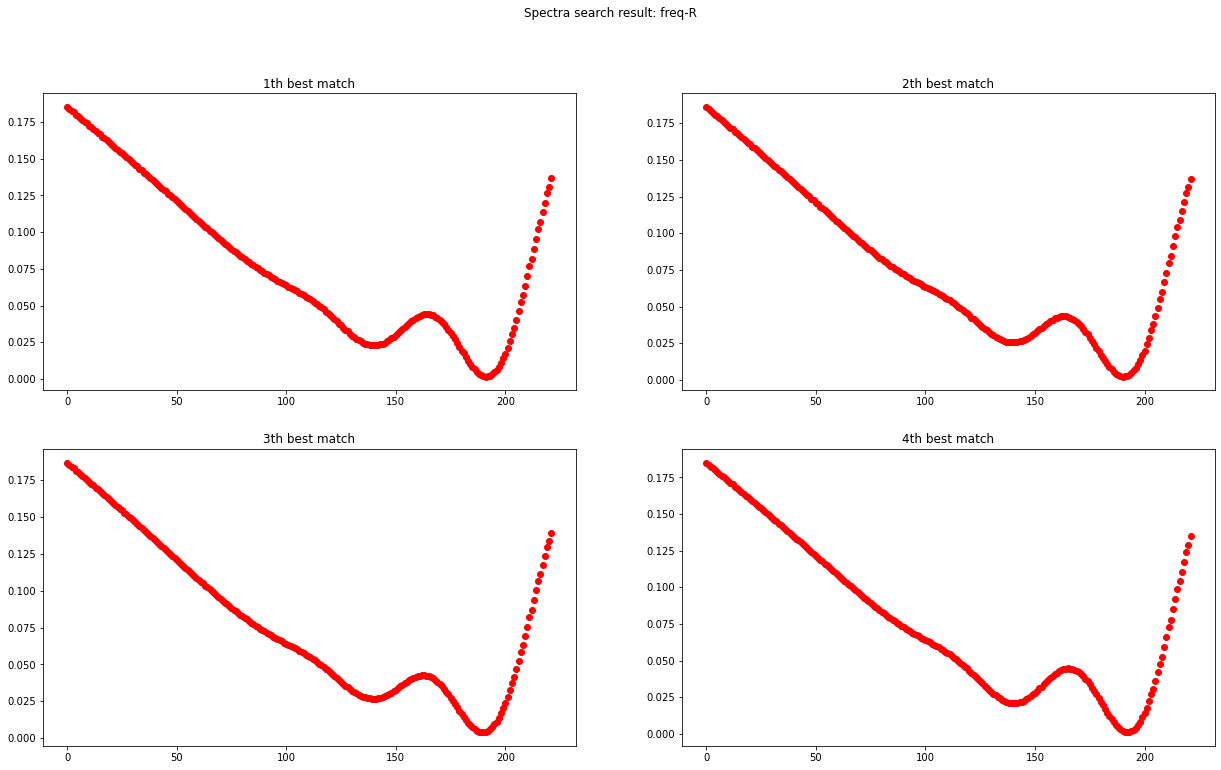

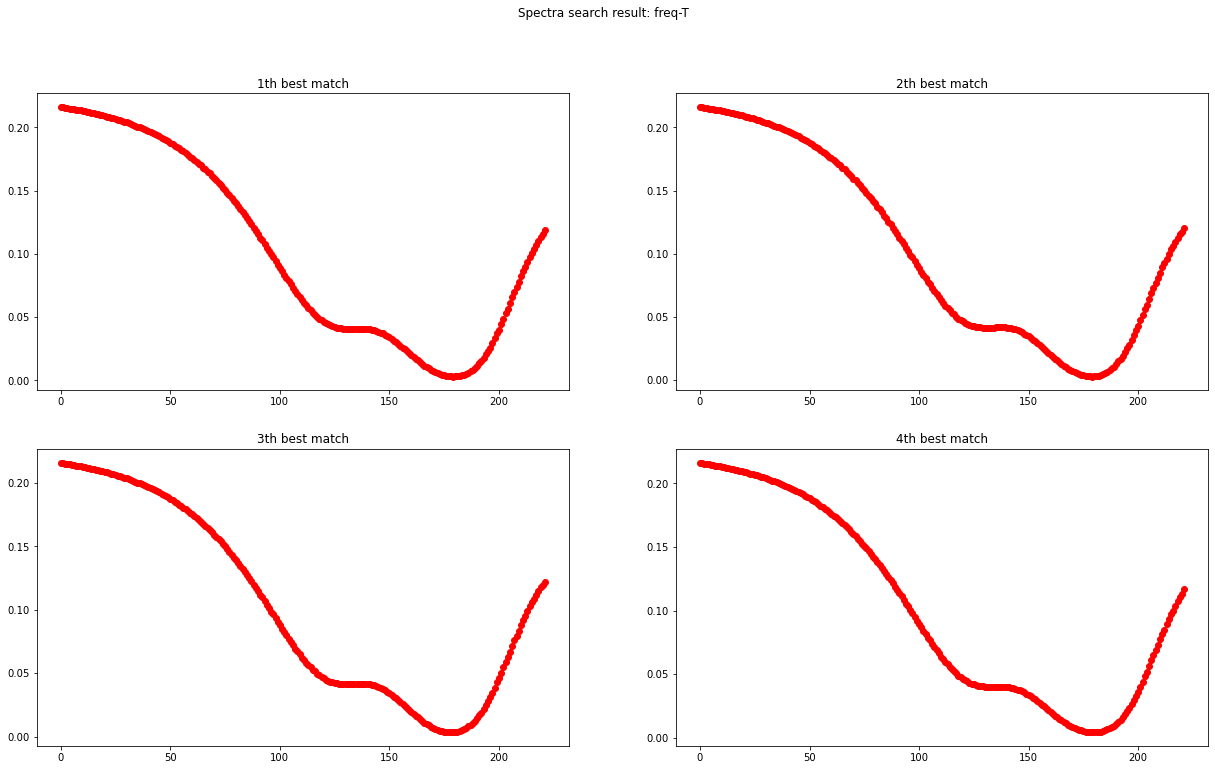

params_pick_visual.shape: (70, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (1415, 4)
R_dict.shape: (1415, 222)
T_dict.shape: (1415, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [150. 130. 160.  75.] params_pick: [150. 130. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [150. 129. 160.  75.] params_pick: [150. 129. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [150. 128. 160.  75.] params_pick: [150. 128. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [150. 131. 160.  75.] params_pick: [150. 131. 160.  75.]
--------------------
5 th match
Not in the dict, calling RCWA...
# params_pick: [150. 127. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
6 th match
Already in the dict.
# params_dict: [150. 132. 160.  75.] params_pick: [150. 132. 160.  75.]
------------

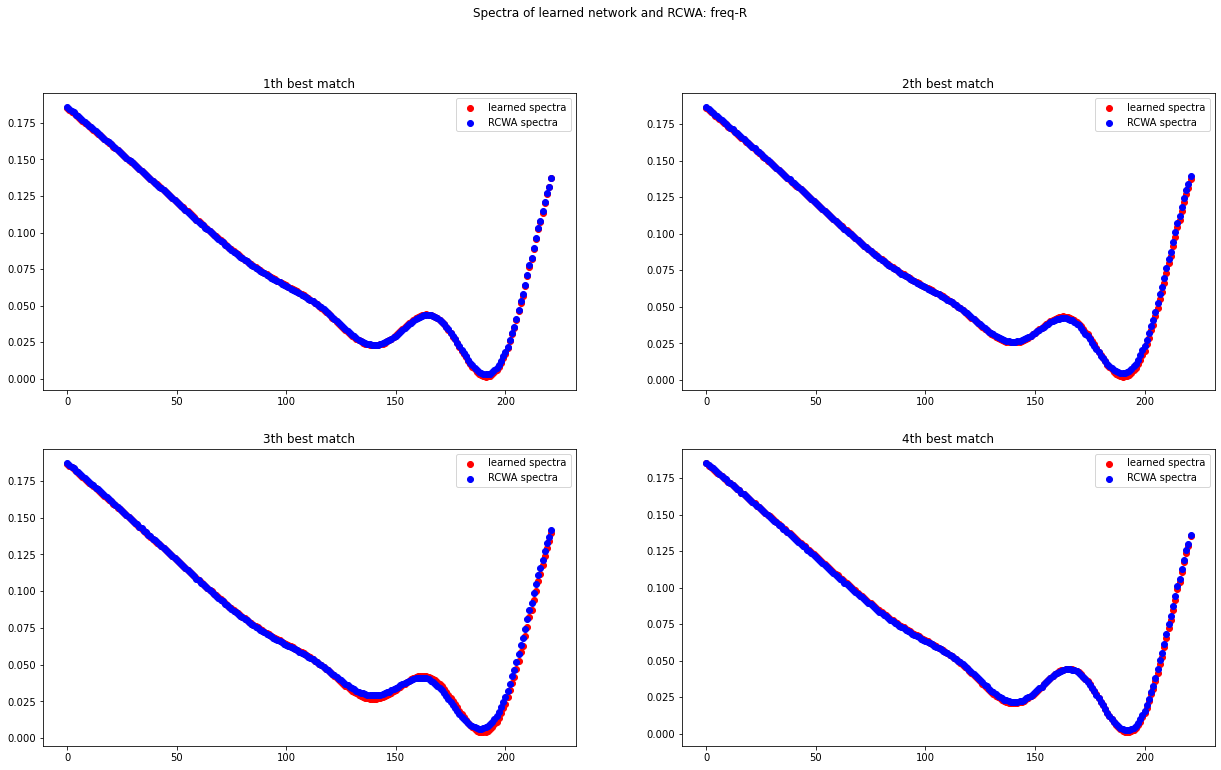

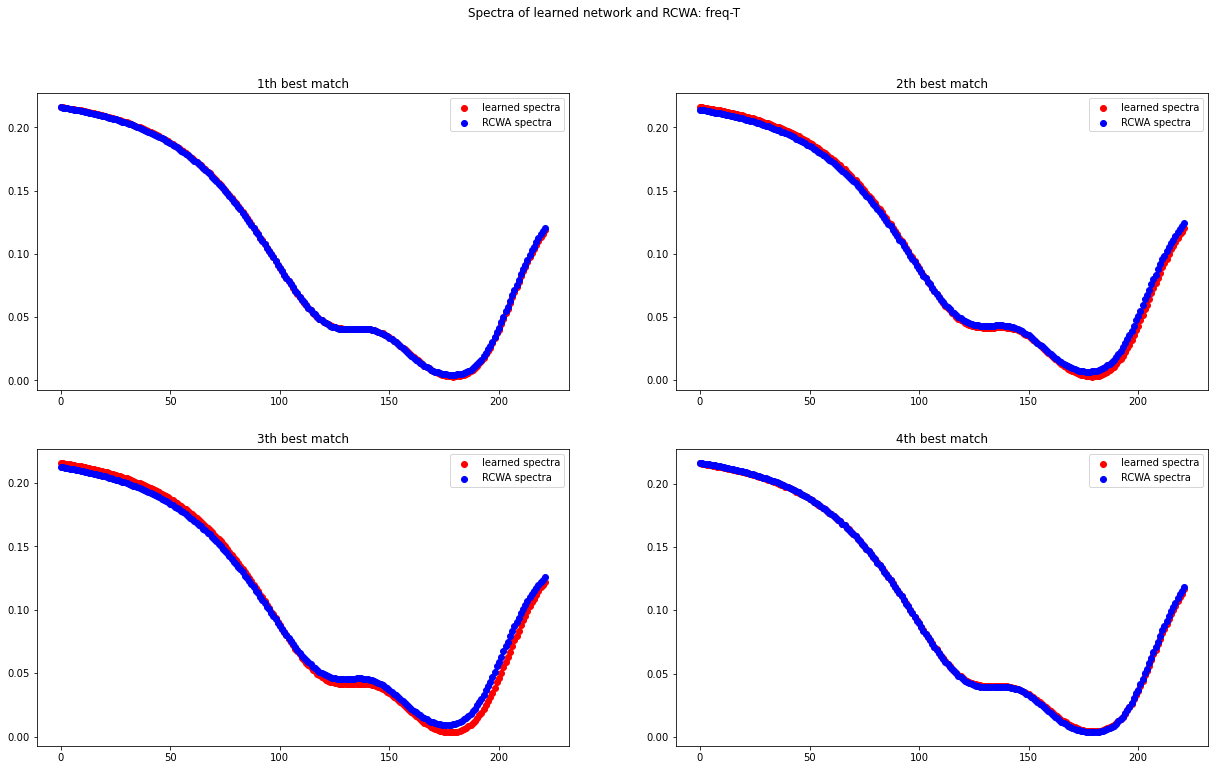

** Model saved.
**************************** ROUND 8 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1600
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [138.  69.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [60. 92.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 95. 101.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [144.  55.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [134.  61.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [110.  65.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [120.  96.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [127.  57.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [78. 66.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 99. 142.]
Calculation P

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [129. 107.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [84. 62.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [141.  65.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 96. 115.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [138. 107.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [109. 141.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [132. 142.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 52. 132.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [134.  71.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [144. 129.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [109. 111.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [95. 58.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 2.7857681258218747e-05
### TEST LOSS  7.560568307477904e-05
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 8.467726302061607e-06
### TEST LOSS  8.139847172590938e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 3.6974439888881605e-06
### TEST LOSS  6.43574219338916e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 4.753515202411407e-06
### TEST LOSS  5.46147447266776e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 3.3187562602421392e-06
### TEST LOSS  5.388475993110357e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 2.6009055462594686e-06
### TEST LOSS  1.517791763679573e-06
----------------------------------------------------------------------
***

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 7.086521366583831e-07
### TEST LOSS  4.828136693409609e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 8.899772192694222e-07
### TEST LOSS  6.651575539251553e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 7.997085456223907e-07
### TEST LOSS  3.7235754083061088e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.498930900170059e-06
### TEST LOSS  8.15187828351327e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.0039374027970283e-06
### TEST LOSS  1.0821503077333243e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 7.927434286458812e-07
### TEST LOSS  4.6012946934107884e-07
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 6.467899339379634e-07
### TEST LOSS  4.2572745447462995e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 5.2637783128473e-07
### TEST LOSS  6.422319801894597e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 6.994127428816554e-07
### TEST LOSS  4.356883055815312e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 6.036269510256709e-07
### TEST LOSS  3.9100419021072713e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 5.711695907062442e-07
### TEST LOSS  1.1380192267059404e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 5.23805789969245e-07
### TEST LOSS  1.2360651477176059e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 4.694113734737826e-07
### TEST LOSS  6.584818261027673e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 4.865110308327481e-07
### TEST LOSS  4.350398050689819e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 4.831816676564848e-07
### TEST LOSS  7.871695473227192e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.060846352833437e-07
### TEST LOSS  6.055016624391859e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 5.369851335590426e-07
### TEST LOSS  3.386558275290478e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 5.584654539192435e-07
### TEST LOSS  3.9549621296449306e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 4.351100739974356e-07
### TEST LOSS  3.109745634333194e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 4.403458861124143e-07
### TEST LOSS  4.96373574539651e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 4.767198483945911e-07
### TEST LOSS  3.413002194937083e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 4.4085085374234725e-07
### TEST LOSS  4.460715743448418e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 3.8448518447031787e-07
### TEST LOSS  4.6467020216785687e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 3.816685899638017e-07
### TEST LOSS  4.976075113442372e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.529532816111015e-07
### TEST LOSS  4.347885370255729e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.464407741955334e-07
### TEST LOSS  3.085500116147462e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.2900711942017724e-07
### TEST LOSS  2.947123730242159e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.368748676715107e-07
### TEST LOSS  7.004264179026146e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 3.9917881303308536e-07
### TEST LOSS  4.2845864337929623e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.4067538715442114e-07
### TEST LOSS  3.6185343788019964e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.94484180001875e-07
### TEST LOSS  3.557769302868034e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.958633459899552e-07
### TEST LOSS  3.8374891175863013e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.093338531374613e-07
### TEST LOSS  4.3908654608533954e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.07133793873804e-07
### TEST LOSS  3.8716589164285625e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.7173336966178636e-07
### TEST LOSS  3.1181479087649677e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.1831549495108254e-07
### TEST LOSS  3.4024805017907056e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.87081809687384e-07
### TEST LOSS  2.9010041539360526e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.572291563780361e-07
### TEST LOSS  3.8993795096568345e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.349118247863991e-07
### TEST LOSS  3.621316585859328e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.699192272921259e-07
### TEST LOSS  3.7643478734139535e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.858473597739831e-07
### TEST LOSS  4.107764712083887e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.0052902461562567e-07
### TEST LOSS  4.199755186580963e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.8196737894180544e-07
### TEST LOSS  3.2682562374949004e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.2878831278670973e-07
### TEST LOSS  2.4903586511489567e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.817423621388372e-07
### TEST LOSS  3.7109821349190497e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.956839613517005e-07
### TEST LOSS  5.401014734710922e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.9048590454449085e-07
### TEST LOSS  2.7264921283650284e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.2672265650134377e-07
### TEST LOSS  2.809145230505313e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.6724974351698415e-07
### TEST LOSS  4.3466611880186673e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.1567948508514085e-07
### TEST LOSS  4.111288932998984e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.385748823170331e-07
### TEST LOSS  3.197525971406397e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.2844153172950643e-07
### TEST LOSS  4.493186966196087e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.3341821081167567e-07
### TEST LOSS  2.4588461222663227e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.345622136041726e-07
### TEST LOSS  3.3710469438119617e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.7828626369806884e-07
### TEST LOSS  5.23749388747774e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.8720877189479806e-07
### TEST LOSS  2.577259235655068e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.139066507751309e-07
### TEST LOSS  3.4655056187678685e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 3.836773782173175e-07
### TEST LOSS  4.851432819918955e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.3154750545438815e-07
### TEST LOSS  2.7487045883844985e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.3740498122547536e-07
### TEST LOSS  2.7331487650883446e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.875577039025302e-07
### TEST LOSS  3.1485580483566383e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.687680928043946e-07
### TEST LOSS  2.923572530733054e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.3407030611387614e-07
### TEST LOSS  7.331607084400579e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.6218967597090313e-07
### TEST LOSS  5.057241878603236e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.76785808635649e-07
### TEST LOSS  3.3314819821346947e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.36110151428759e-07
### TEST LOSS  2.722830097686331e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.428344142197837e-07
### TEST LOSS  2.2145320066613294e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.3563805635350443e-07
### TEST LOSS  2.6714682199724393e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.399376724244618e-07
### TEST LOSS  3.451541405278628e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.331073982892896e-07
### TEST LOSS  2.4675455989608963e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 3.556625958056614e-07
### TEST LOSS  3.419326522665263e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.2956148224516646e-07
### TEST LOSS  2.9204095556660076e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.069860256488255e-07
### TEST LOSS  3.3786407508766086e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.4674865529882306e-07
### TEST LOSS  2.5512282952888654e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 3.4706523080352267e-07
### TEST LOSS  4.979225411242775e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.4817103202744446e-07
### TEST LOSS  3.5285440880272745e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.9704434162169946e-07
### TEST LOSS  2.1618936211590759e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.1679689603714144e-07
### TEST LOSS  5.324063738025112e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.1176815918132486e-07
### TEST LOSS  3.179710089303474e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.0008195122444013e-07
### TEST LOSS  3.7008536916497786e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.173168251269232e-07
### TEST LOSS  2.772738548391847e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.0882670682075286e-07
### TEST LOSS  3.667877273016984e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.381607733599079e-07
### TEST LOSS  7.784422682751332e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.0848634976154977e-07
### TEST LOSS  4.6375501365029476e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.305073163539785e-07
### TEST LOSS  2.2702350991702738e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.0298123343763805e-07
### TEST LOSS  2.7481893797679885e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.1222730603186475e-07
### TEST LOSS  2.2157737807522912e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.4462460836270915e-07
### TEST LOSS  3.6469694464358327e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.2707019796962556e-07
### TEST LOSS  2.6105933296586653e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.689478718926775e-07
### TEST LOSS  3.4756189866887627e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.160798192669567e-07
### TEST LOSS  3.325113091534604e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.0592289644859606e-07
### TEST LOSS  3.43576894342353e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.136527036629033e-07
### TEST LOSS  2.4868913979977e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.1633965647759334e-07
### TEST LOSS  3.869775054473242e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.0786217542155825e-07
### TEST LOSS  2.5635010144261133e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.2316231265205884e-07
### TEST LOSS  3.1433303189961254e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.084829026733793e-07
### TEST LOSS  2.3529131591241517e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.900136046912749e-07
### TEST LOSS  2.6429099975189274e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.8331707567996745e-07
### TEST LOSS  4.114653637069902e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.0661358532579894e-07
### TEST LOSS  2.1752866767125548e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.802947709157344e-07
### TEST LOSS  4.2069644242322585e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.028393045512168e-07
### TEST LOSS  2.4128406472812003e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.305430251732133e-07
### TEST LOSS  3.7901514104987655e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.040776928631139e-07
### TEST LOSS  2.8621397696326767e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.06795950112404e-07
### TEST LOSS  2.255526763879819e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.0622595758478256e-07
### TEST LOSS  3.681449278758464e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.140982594906916e-07
### TEST LOSS  3.115867629096177e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.0138077798280706e-07
### TEST LOSS  2.429487295785293e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.4361821098505275e-07
### TEST LOSS  3.0129175658070534e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.8033904477808844e-07
### TEST LOSS  2.719980850921881e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.114852082153341e-07
### TEST LOSS  2.542022675318852e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.9729683223345127e-07
### TEST LOSS  3.2937742962720523e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.0604044218951464e-07
### TEST LOSS  4.3570387594134746e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.7872599885236936e-07
### TEST LOSS  1.9768742435625578e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.8301364220828516e-07
### TEST LOSS  2.3630159281159044e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.0248984173031346e-07
### TEST LOSS  2.9428364219559927e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.0636141701845256e-07
### TEST LOSS  3.802533363739258e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.8192066490406733e-07
### TEST LOSS  3.7237588301763935e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.7914133939210826e-07
### TEST LOSS  1.9857064674037397e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.9644505098902487e-07
### TEST LOSS  2.2812926895691513e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.7542348912668047e-07
### TEST LOSS  2.4599393159500477e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.1104966712991456e-07
### TEST LOSS  1.8793143456245312e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.82468896273258e-07
### TEST LOSS  3.763765429691072e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.113441162494457e-07
### TEST LOSS  2.2627663713118787e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.0410023279525687e-07
### TEST LOSS  3.683757938688359e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.3551427281452997e-07
### TEST LOSS  2.671777815284789e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.812166067078792e-07
### TEST LOSS  2.3451176585827702e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.869518931170045e-07
### TEST LOSS  2.887903226186002e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.9089722041408806e-07
### TEST LOSS  2.105602974940742e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.56188876964314e-07
### TEST LOSS  1.1933527185685004e-06
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.377903653689618e-07
### TEST LOSS  2.4750663207839807e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.6721874148982747e-07
### TEST LOSS  3.092330563466324e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.6921002341639964e-07
### TEST LOSS  2.2050595186821434e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.8471869499613335e-07
### TEST LOSS  2.563943120037493e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.503681448440265e-07
### TEST LOSS  1.8110549119635758e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.908594467454506e-07
### TEST LOSS  2.268451838223958e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.875721697126465e-07
### TEST LOSS  4.4379611570851313e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.093280638166718e-07
### TEST LOSS  1.8216832546139963e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.994483714446883e-07
### TEST LOSS  2.681813384697307e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.8403413734223726e-07
### TEST LOSS  2.4105399868782723e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.7531240102351975e-07
### TEST LOSS  3.7835006475953986e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.724426541689251e-07
### TEST LOSS  2.462906317409382e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.8287604744159365e-07
### TEST LOSS  3.0577051883066514e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.7895543236677866e-07
### TEST LOSS  2.1586106472663383e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.023304197125043e-07
### TEST LOSS  2.3281222342556399e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.933896707157935e-07
### TEST LOSS  2.982815020165693e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.220924192159913e-07
### TEST LOSS  1.788595872890634e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.958212503634261e-07
### TEST LOSS  2.4939690905038486e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.9169836481712786e-07
### TEST LOSS  2.580895165730605e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.8220097581077577e-07
### TEST LOSS  2.4883510126490666e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.700831755231281e-07
### TEST LOSS  1.9961822594893874e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.167801211434451e-07
### TEST LOSS  2.757866859326441e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.835427417680059e-07
### TEST LOSS  1.9225902588478524e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.8231132030764884e-07
### TEST LOSS  2.1658604391442773e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.85733179964387e-07
### TEST LOSS  2.693319445986238e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.988210039611694e-07
### TEST LOSS  4.91328911778055e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.351097012482818e-07
### TEST LOSS  2.726086337408636e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.1372927176809286e-07
### TEST LOSS  3.6865723155680524e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.9510959566714233e-07
### TEST LOSS  3.6085705919693584e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.9362373015651145e-07
### TEST LOSS  5.508697735005322e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.0859587126341735e-07
### TEST LOSS  2.493750006493656e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.846150679736148e-07
### TEST LOSS  2.0112266222819622e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.673598180735759e-07
### TEST LOSS  1.7890842999671955e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.737246163153628e-07
### TEST LOSS  2.7978903934429883e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.6988690230433934e-07
### TEST LOSS  2.4304985579703953e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.7185962667042316e-07
### TEST LOSS  2.723196181146174e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.755504295970379e-07
### TEST LOSS  2.4432603791998037e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.676683750701958e-07
### TEST LOSS  2.846808276520581e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.933429774387708e-07
### TEST LOSS  7.168946491257581e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.805128159877324e-07
### TEST LOSS  2.1468271960145557e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.4970515384636906e-07
### TEST LOSS  2.6590403834347853e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.612501885379537e-07
### TEST LOSS  3.107177259191e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.8854884713935823e-07
### TEST LOSS  2.190167413355463e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.757861781388371e-07
### TEST LOSS  2.1964920193795479e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.6139590159734993e-07
### TEST LOSS  3.0142285526816676e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.862104967582546e-07
### TEST LOSS  7.181926070150743e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.5652722379865267e-07
### TEST LOSS  2.7272265571790893e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.816979088682281e-07
### TEST LOSS  2.233602008535248e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.614038625625703e-07
### TEST LOSS  2.42318070201956e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.5154018571615923e-07
### TEST LOSS  2.3213465816240841e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.9095786573174466e-07
### TEST LOSS  2.568116877673295e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.7124024450264626e-07
### TEST LOSS  2.014251911930387e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.691805880450371e-07
### TEST LOSS  2.4415015194752715e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.1563719062432936e-07
### TEST LOSS  3.9790925162227114e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.4884261343727234e-07
### TEST LOSS  1.7737999454444284e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.8160497118845383e-07
### TEST LOSS  2.0795716615396032e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.9807387001978826e-07
### TEST LOSS  2.573517476160229e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.6797068948036794e-07
### TEST LOSS  2.337598790091988e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.73939375914356e-07
### TEST LOSS  2.1738554304799132e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.6972953067194717e-07
### TEST LOSS  3.1521282650714966e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.3238738526453206e-07
### TEST LOSS  2.1082652660690351e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.015887309265608e-07
### TEST LOSS  2.1579902072706622e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.599328664698586e-07
### TEST LOSS  3.2548719749077765e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.65183009019454e-07
### TEST LOSS  1.5798412592952596e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.7015212140213406e-07
### TEST LOSS  2.494019971284918e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.6331091224851557e-07
### TEST LOSS  2.0516682575077994e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.8449847930378527e-07
### TEST LOSS  1.8544318021914327e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.76217988088856e-07
### TEST LOSS  3.073708067328577e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.8674307897214033e-07
### TEST LOSS  2.1170512513416875e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.5808533876792164e-07
### TEST LOSS  2.3778264631365195e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.581242107135839e-07
### TEST LOSS  2.187820064373606e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.497839293735815e-07
### TEST LOSS  2.0276896310159978e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.496723566330905e-07
### TEST LOSS  1.6943314662398734e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.5382063448819994e-07
### TEST LOSS  1.9772221726555017e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.767946991544257e-07
### TEST LOSS  1.7729329175134959e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.624175837462328e-07
### TEST LOSS  2.0885471722446405e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.6135470713395394e-07
### TEST LOSS  2.3907239980284584e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.6334271850836365e-07
### TEST LOSS  2.729922575402573e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.771238374232876e-07
### TEST LOSS  2.4781986892226843e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.787302486151333e-07
### TEST LOSS  1.7683762483973928e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.453829208470815e-07
### TEST LOSS  1.6235176047985078e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.498002703121838e-07
### TEST LOSS  2.035909994665038e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.67803032131253e-07
### TEST LOSS  2.0844526460450652e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.7254753698469083e-07
### TEST LOSS  1.7784559602773697e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 3.0541228684621833e-07
### TEST LOSS  1.8056943140720705e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.692495269918105e-07
### TEST LOSS  1.982657575894109e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.711275393363355e-07
### TEST LOSS  2.764330607381756e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.7471525985811597e-07
### TEST LOSS  2.5939576175915136e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.7425295576755106e-07
### TEST LOSS  2.773241837653965e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.488457536653499e-07
### TEST LOSS  2.1772856939605845e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.506291307535768e-07
### TEST LOSS  2.2833219818589137e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.6121538473256046e-07
### TEST LOSS  1.979416879294149e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.4627012574662823e-07
### TEST LOSS  1.7021770185958e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.618153696332115e-07
### TEST LOSS  2.2921928355401633e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.4735929449626326e-07
### TEST LOSS  2.1493954468117712e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.602971374154883e-07
### TEST LOSS  1.9141873804547535e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.3561349375200712e-07
### TEST LOSS  3.091370762338859e-07
** loss_train 2.3561349375200712e-07
** loss_test 3.091370762338859e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


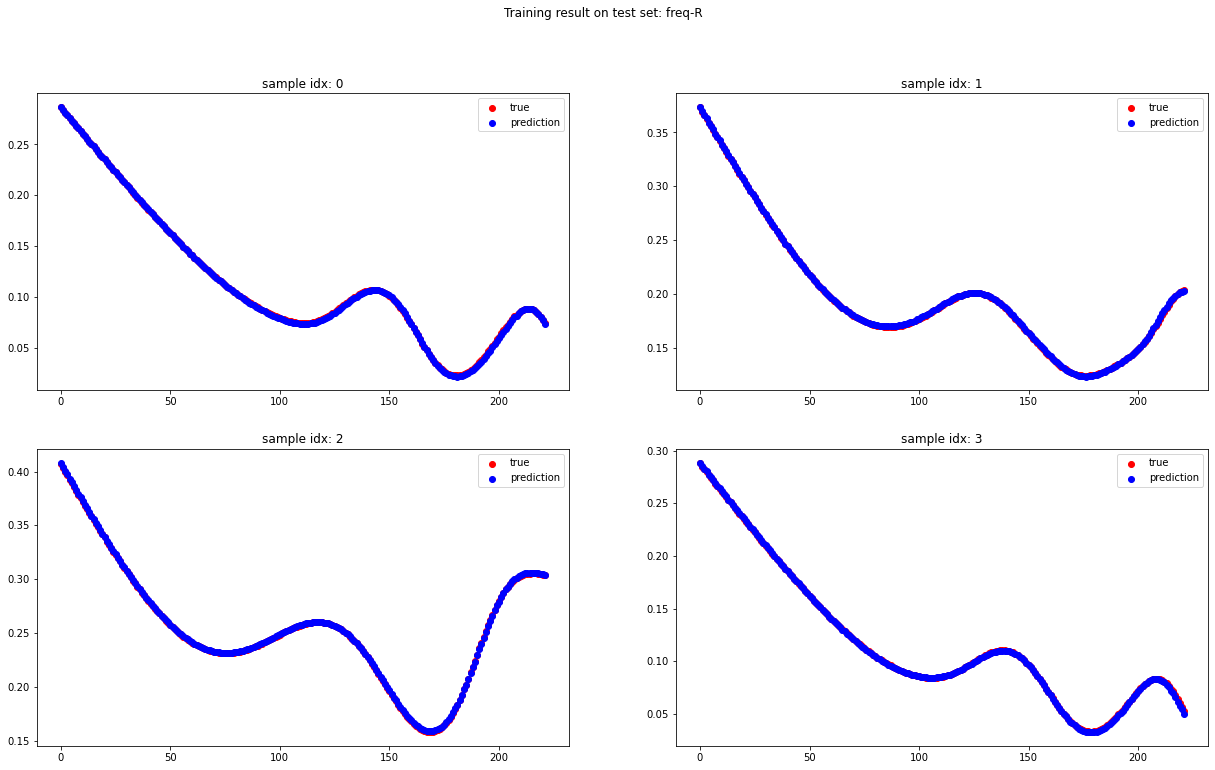

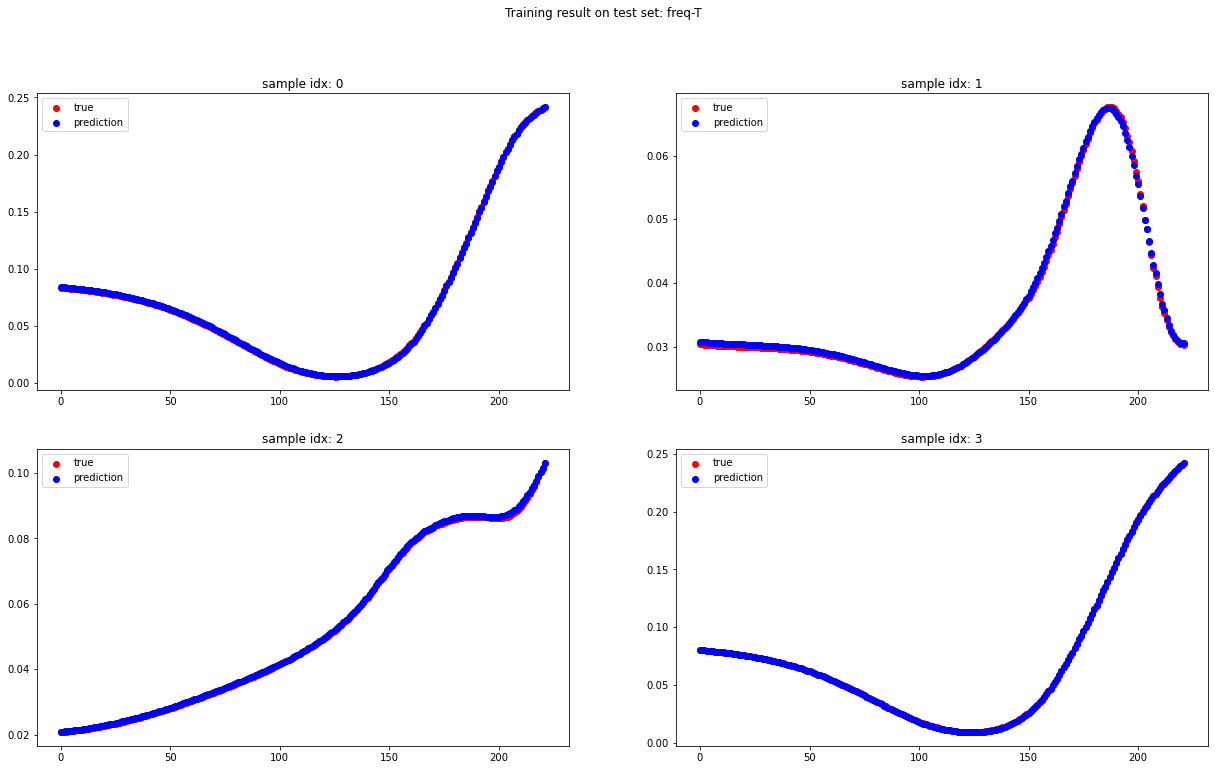

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

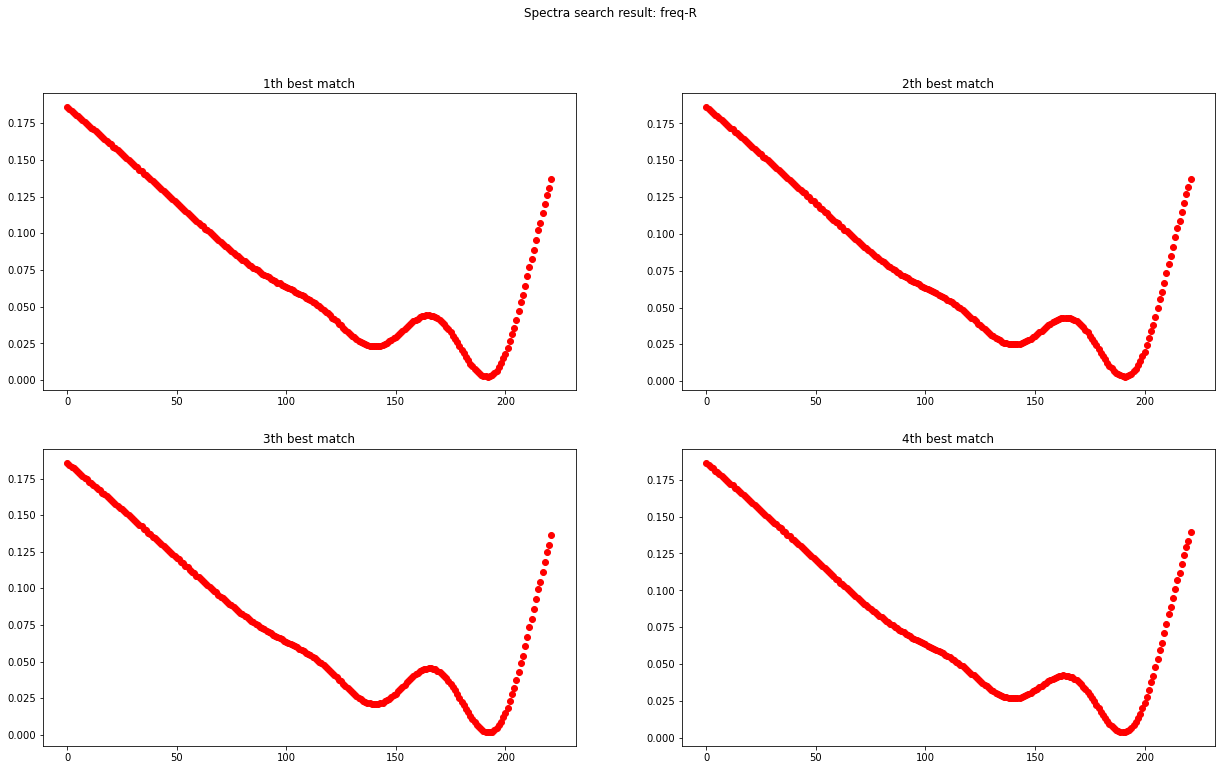

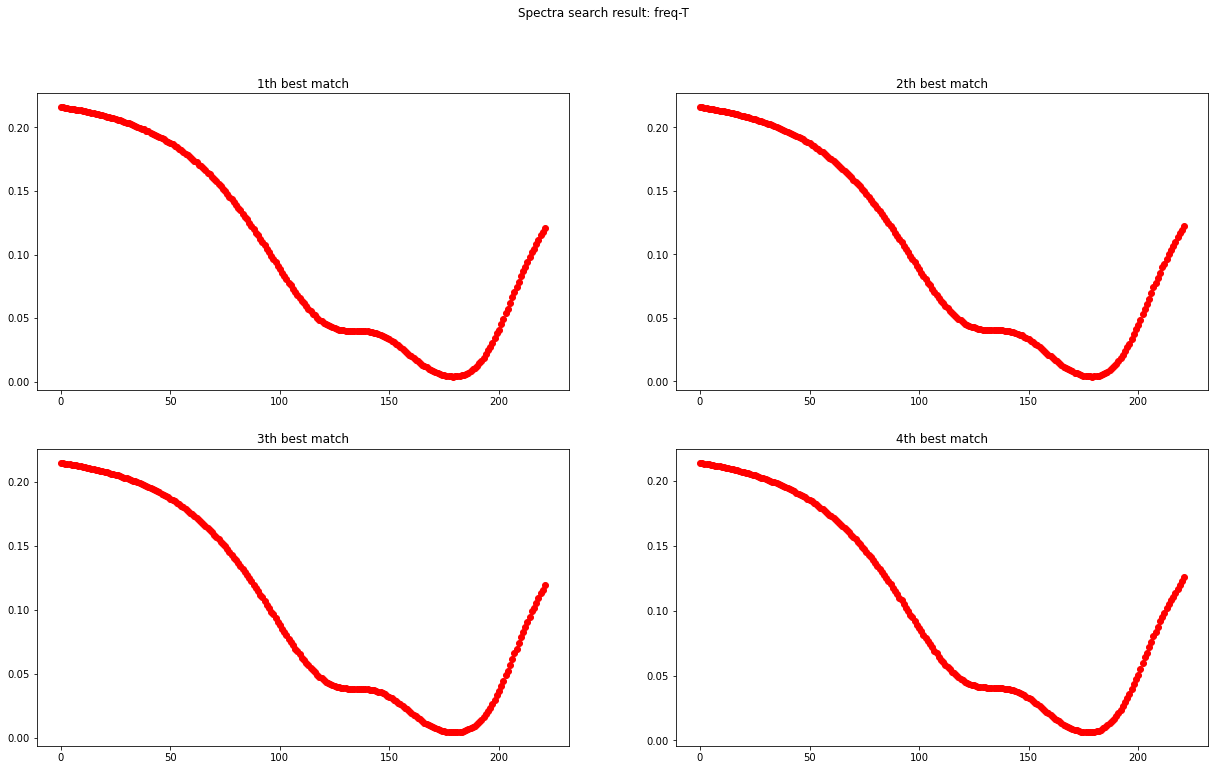

params_pick_visual.shape: (80, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (1617, 4)
R_dict.shape: (1617, 222)
T_dict.shape: (1617, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [150. 130. 160.  75.] params_pick: [150. 130. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [150. 129. 160.  75.] params_pick: [150. 129. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [150. 131. 160.  75.] params_pick: [150. 131. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [150. 128. 160.  75.] params_pick: [150. 128. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [150. 132. 160.  75.] params_pick: [150. 132. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [150. 127. 160.  75.] params_pick: [150. 127. 160.  75.]
--------------------
7 th match
Already in the dict.
# param

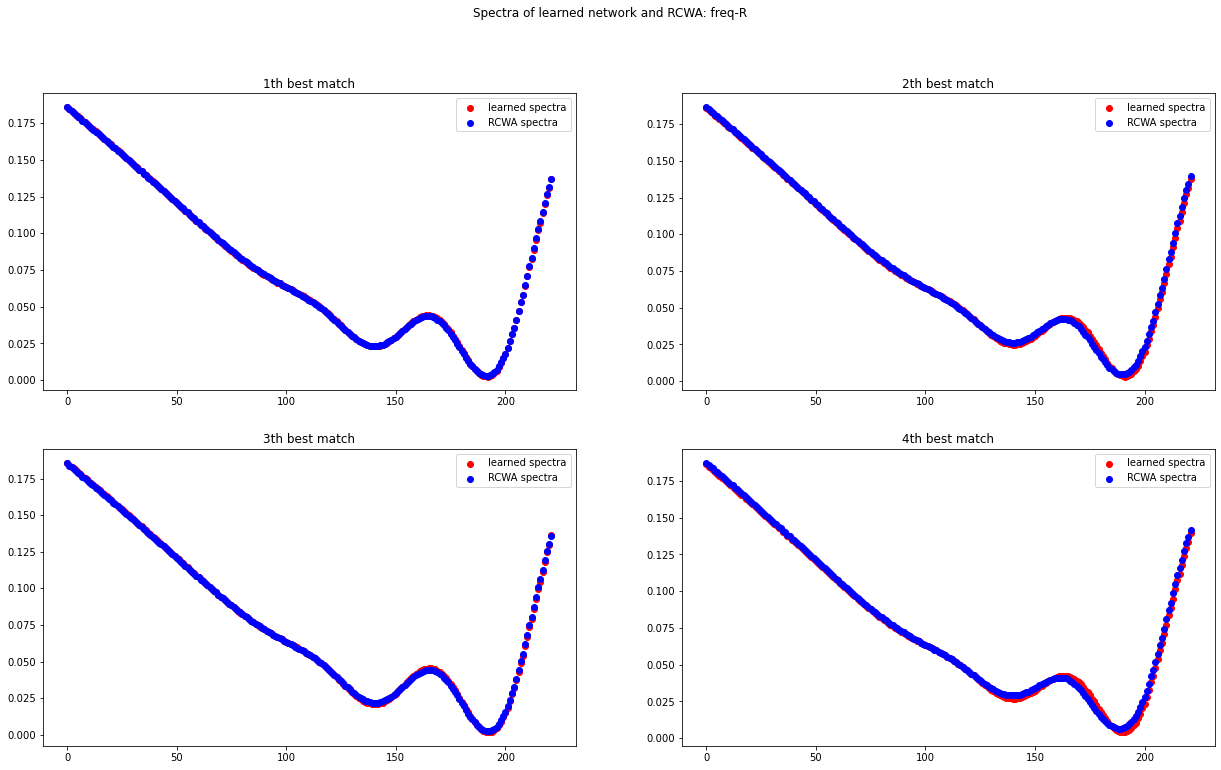

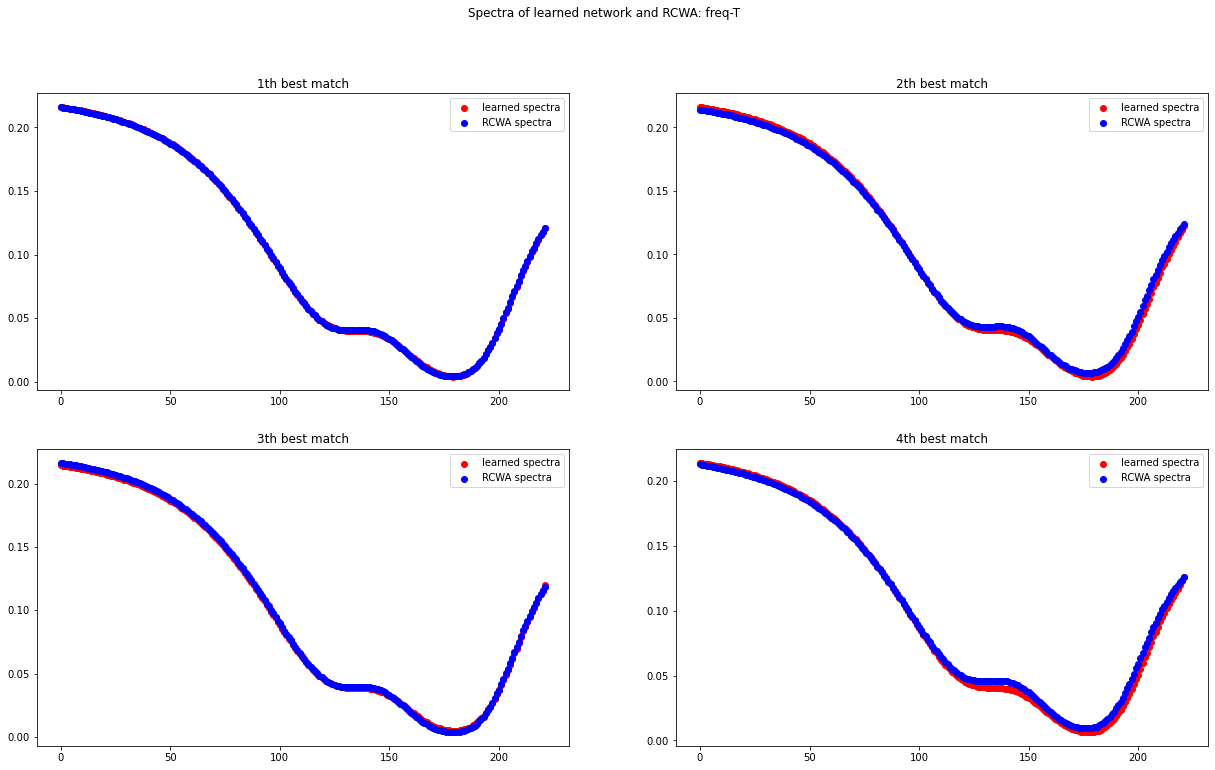

** Model saved.
**************************** ROUND 9 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1800
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [133.  63.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [118. 108.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [141.  73.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [94. 79.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [125.  79.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 94. 127.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [135.  64.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 94. 110.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [139.  59.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [146.  92.]
Calculation

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [145.  64.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [76. 92.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [100.  68.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [149. 147.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 50. 136.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [ 53. 149.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 97. 150.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [104.  70.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [149.  80.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 69. 105.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 69. 102.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [139.  73.]
Calculation Progress: 100%
---

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 2.461253957989129e-05
### TEST LOSS  0.00013226117341589457
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 7.056750715221938e-06
### TEST LOSS  2.3908516018983156e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 2.364781297185598e-06
### TEST LOSS  1.092158504013275e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 2.133460734338794e-06
### TEST LOSS  1.7133114709024624e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 1.4825243198046678e-06
### TEST LOSS  1.4906723764498665e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 1.798929916701929e-06
### TEST LOSS  2.927063877467407e-06
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 6.259144732823074e-07
### TEST LOSS  4.1181094919314393e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.2472973473798277e-06
### TEST LOSS  4.4780267040146606e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 6.43525667373505e-07
### TEST LOSS  6.690837608402944e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 5.101260327518749e-07
### TEST LOSS  4.412069190325214e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 4.746357454048993e-07
### TEST LOSS  4.776168688530797e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.0732726796231556e-06
### TEST LOSS  1.7579291946074388e-06
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 3.8961340289726344e-07
### TEST LOSS  3.585419455652704e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 3.809108322529021e-07
### TEST LOSS  5.92021845275465e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 4.108807368198421e-07
### TEST LOSS  3.738487677125064e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 3.8469202470439416e-07
### TEST LOSS  2.6342007265190695e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 4.122159468700204e-07
### TEST LOSS  3.282495350099958e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 4.104643748083071e-07
### TEST LOSS  5.014476300857496e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 3.981385070300152e-07
### TEST LOSS  3.3448343959595083e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 4.039759746652136e-07
### TEST LOSS  3.0121885088276567e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 5.610414297131507e-07
### TEST LOSS  3.7202258866913055e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 3.9432199914399586e-07
### TEST LOSS  2.7759920716040076e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 3.9728433672811844e-07
### TEST LOSS  3.156410552188997e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 3.406639682464648e-07
### TEST LOSS  4.10266511397384e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 3.436571961677891e-07
### TEST LOSS  2.6134955901482126e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 4.1301859835208965e-07
### TEST LOSS  2.981828359864907e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 5.019329325723416e-07
### TEST LOSS  3.003527440257501e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 3.620923460800896e-07
### TEST LOSS  3.6987467061172303e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 3.231404989703337e-07
### TEST LOSS  3.9939981290983805e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 3.4010193064383366e-07
### TEST LOSS  2.505791332783634e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 2.7790015394460155e-07
### TEST LOSS  3.4341621076068636e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 3.2361345192318443e-07
### TEST LOSS  2.9752885929476046e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 3.1011137036666506e-07
### TEST LOSS  2.653305852230982e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 3.0165072317739965e-07
### TEST LOSS  2.5336374710183954e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 3.0032706773732957e-07
### TEST LOSS  2.894427624327094e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 3.054609976575288e-07
### TEST LOSS  2.3651118712880108e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.0082308257048693e-07
### TEST LOSS  2.141466745165922e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.0762536686681745e-07
### TEST LOSS  2.851466721014933e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 3.532461715987583e-07
### TEST LOSS  3.523402833033523e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 2.940225539788738e-07
### TEST LOSS  2.677634735501097e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 2.865075905737295e-07
### TEST LOSS  2.0441789548318345e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 2.8579974414929173e-07
### TEST LOSS  2.981743889491823e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 2.9459956914834604e-07
### TEST LOSS  2.187458455359269e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.028910666734595e-07
### TEST LOSS  2.365440410459188e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 2.9094598941033686e-07
### TEST LOSS  2.012885252716606e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 2.931050389509693e-07
### TEST LOSS  3.5204138586979957e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.326970041930524e-07
### TEST LOSS  2.4363951396295577e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.0291501821643073e-07
### TEST LOSS  2.0052137017501082e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 2.75754844501424e-07
### TEST LOSS  2.7067647244570657e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 2.846512867499879e-07
### TEST LOSS  2.396421089551276e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 2.761071039832548e-07
### TEST LOSS  1.997717928529878e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.237332556456825e-07
### TEST LOSS  2.2197209219669917e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 2.6616434733956533e-07
### TEST LOSS  2.2765927572739505e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 2.651715002194916e-07
### TEST LOSS  2.7112555124454553e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 2.913531121902698e-07
### TEST LOSS  3.347936957130447e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 2.9704606739973846e-07
### TEST LOSS  2.532168900239008e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 2.9441364873940126e-07
### TEST LOSS  6.311897640932363e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.11743607246642e-07
### TEST LOSS  2.2395688385283089e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 2.890757721542138e-07
### TEST LOSS  3.5539247015229326e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 2.8890389469182765e-07
### TEST LOSS  3.5002626561806583e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 2.701086986098586e-07
### TEST LOSS  2.5862003699078036e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 2.7320641915018485e-07
### TEST LOSS  2.0504922954640077e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 2.7665085061122516e-07
### TEST LOSS  3.665070159463034e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 2.773920163878785e-07
### TEST LOSS  2.832323799692757e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 2.9247133761561233e-07
### TEST LOSS  2.1916986743993524e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 2.8806681454934194e-07
### TEST LOSS  2.644591998230478e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 2.594762766447742e-07
### TEST LOSS  2.1233921748481172e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 2.7499606274301097e-07
### TEST LOSS  2.712284341483879e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 2.786867025002711e-07
### TEST LOSS  3.384563350900188e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.6561060964781624e-07
### TEST LOSS  3.395762893921562e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.003416611926626e-07
### TEST LOSS  2.7465015216842367e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 2.5197277178238643e-07
### TEST LOSS  2.795247590265043e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 2.7280917397614563e-07
### TEST LOSS  2.104872852147242e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 2.6958876099985534e-07
### TEST LOSS  2.075744305329863e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 2.575791213378488e-07
### TEST LOSS  2.1944504116736088e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 2.9173130091406405e-07
### TEST LOSS  1.9385712248633893e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.664666307536676e-07
### TEST LOSS  3.2871817794515393e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.8392662471195725e-07
### TEST LOSS  3.740196253450752e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 2.735885718567014e-07
### TEST LOSS  2.6272217862949924e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.6321397991956196e-07
### TEST LOSS  3.550345003010012e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 2.659127913329229e-07
### TEST LOSS  2.6912936774621174e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 2.955794425159771e-07
### TEST LOSS  2.1867292227179185e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.901767417936204e-07
### TEST LOSS  5.809712604332162e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 2.6256003931517887e-07
### TEST LOSS  2.278955075022774e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 2.8860138493927126e-07
### TEST LOSS  3.9509251021425166e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 2.6334812423990505e-07
### TEST LOSS  3.331267524547204e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.6763179842070886e-07
### TEST LOSS  2.1882529263503212e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 2.796243157801273e-07
### TEST LOSS  2.3518470331711998e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.029996182086276e-07
### TEST LOSS  2.1570104517347014e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.544758489323821e-07
### TEST LOSS  2.2309871560032156e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 2.5185492917461574e-07
### TEST LOSS  3.5660905668751015e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 2.52855428830085e-07
### TEST LOSS  2.5990962205502946e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 2.6055216162390593e-07
### TEST LOSS  2.482991237473942e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 2.8070297058658947e-07
### TEST LOSS  2.7598160504230354e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 2.570818562484965e-07
### TEST LOSS  2.544411093670836e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 2.622018673026361e-07
### TEST LOSS  1.7998433558356433e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.5666983672579926e-07
### TEST LOSS  2.2993092243352833e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 2.7937971382662064e-07
### TEST LOSS  2.2566786812890145e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.659883540988438e-07
### TEST LOSS  3.089435088659903e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 2.471735716517524e-07
### TEST LOSS  2.438983462601148e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.764011873098345e-07
### TEST LOSS  2.211123644344668e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.7608133135477904e-07
### TEST LOSS  2.2914992754336977e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.515291885559397e-07
### TEST LOSS  4.274627761552202e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.737252589035677e-07
### TEST LOSS  3.098658464961301e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.508126766098684e-07
### TEST LOSS  2.6771210762624965e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 2.363124160778243e-07
### TEST LOSS  2.3642413932773505e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.679681059664713e-07
### TEST LOSS  2.271072719184775e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.5963181128080885e-07
### TEST LOSS  2.1389528607566413e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.562455915534735e-07
### TEST LOSS  3.082719154513648e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 2.68771550342686e-07
### TEST LOSS  1.8952572976037051e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.4856126486641177e-07
### TEST LOSS  2.1295787546562308e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.549339092795656e-07
### TEST LOSS  1.786718652536163e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.430038787704092e-07
### TEST LOSS  3.994907486954886e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.542834926326047e-07
### TEST LOSS  2.0803045422915738e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.4237739327877723e-07
### TEST LOSS  1.9522300141893032e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.3536864286417053e-07
### TEST LOSS  3.1803811219156665e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.664079444484694e-07
### TEST LOSS  3.196635008053919e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.3718871672468507e-07
### TEST LOSS  1.56511240247794e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.5234983213865784e-07
### TEST LOSS  2.5876646932206144e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.452981759009592e-07
### TEST LOSS  2.533243861922461e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.4343345508665633e-07
### TEST LOSS  2.5797828531840086e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.5215160698977e-07
### TEST LOSS  2.34310791542898e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.629491736853377e-07
### TEST LOSS  2.8269884395555253e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.6856070176507607e-07
### TEST LOSS  2.887678863106447e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.5548420247724203e-07
### TEST LOSS  1.8983835093211855e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.61722077053624e-07
### TEST LOSS  2.6021576544550315e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.516274506013537e-07
### TEST LOSS  1.995125363354991e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.4267990050298575e-07
### TEST LOSS  2.386741713238465e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.518818061335458e-07
### TEST LOSS  2.9540636393011043e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.5887760809201806e-07
### TEST LOSS  2.1204249273304648e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.5287848731952385e-07
### TEST LOSS  3.76519759962927e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.657210479009267e-07
### TEST LOSS  2.0982116403181998e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.431902641614809e-07
### TEST LOSS  2.7941993344618955e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.4121896696390385e-07
### TEST LOSS  1.886930042010809e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.56194952442791e-07
### TEST LOSS  2.0965724498064784e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.478207450194879e-07
### TEST LOSS  1.9979077644957552e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.510189822175274e-07
### TEST LOSS  1.8073727456221942e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.524159031756944e-07
### TEST LOSS  2.5695077104720205e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.3097754242782128e-07
### TEST LOSS  1.9942887334949505e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.4536551723741695e-07
### TEST LOSS  2.7898355388818646e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.5792314014536385e-07
### TEST LOSS  3.263211414992771e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.7553251496195387e-07
### TEST LOSS  2.906088341163653e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.391047789007672e-07
### TEST LOSS  2.3824622775026473e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.499405081904074e-07
### TEST LOSS  3.19909623861484e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.632084275402649e-07
### TEST LOSS  1.6120038887274185e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.339617802180369e-07
### TEST LOSS  2.0872821351160922e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.6584450342623554e-07
### TEST LOSS  2.1068603980775489e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.383190736241245e-07
### TEST LOSS  2.3496555298960527e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.3671953869788512e-07
### TEST LOSS  3.848936608442778e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.4003412136350576e-07
### TEST LOSS  1.9135414832918388e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.4781188178539064e-07
### TEST LOSS  3.2289984717324305e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.435260405903645e-07
### TEST LOSS  2.2750549691055414e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.3626627900045587e-07
### TEST LOSS  1.6774517590605415e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.3739361100795343e-07
### TEST LOSS  2.1351666679981496e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.542264216693408e-07
### TEST LOSS  4.477005890950952e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.546935770267014e-07
### TEST LOSS  2.0294304876929177e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.46635614336515e-07
### TEST LOSS  3.0599587285417293e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.5058558247772725e-07
### TEST LOSS  2.943541159294438e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.3954702013403067e-07
### TEST LOSS  2.8651571479140667e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.268677453562715e-07
### TEST LOSS  1.836428811817246e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.2500710657643216e-07
### TEST LOSS  2.2855374587143835e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.3218055553029e-07
### TEST LOSS  2.0068540975528406e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.444305129342992e-07
### TEST LOSS  2.127316570800354e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.2579474088679773e-07
### TEST LOSS  2.2886044769586955e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.2781507715150282e-07
### TEST LOSS  2.1674368505736546e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.21506387875006e-07
### TEST LOSS  1.8763995986622226e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.4015298909693983e-07
### TEST LOSS  1.4980109439319574e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.557943830123261e-07
### TEST LOSS  1.8806203593579051e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.4686157435560573e-07
### TEST LOSS  1.9943710722398262e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.3724846293463978e-07
### TEST LOSS  2.1301191776712112e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.3751615310294324e-07
### TEST LOSS  2.2667792304926277e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.3692600867578998e-07
### TEST LOSS  1.9453697767083348e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.491676568785708e-07
### TEST LOSS  1.9785699965655956e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.604675128154494e-07
### TEST LOSS  2.1984041556724723e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.459867573950052e-07
### TEST LOSS  2.2896686857620807e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.441799509660885e-07
### TEST LOSS  1.8446596967620549e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.3210316821299493e-07
### TEST LOSS  1.9237251659955357e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.400290614140093e-07
### TEST LOSS  2.7835119348546194e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.367738578890055e-07
### TEST LOSS  2.4387603206024426e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.410052181960825e-07
### TEST LOSS  2.8148701805666523e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.4174727653184883e-07
### TEST LOSS  2.2634428323389902e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.4213189194593414e-07
### TEST LOSS  2.7966320854173114e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.4147793473360146e-07
### TEST LOSS  2.2297730305775043e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.4493938435041526e-07
### TEST LOSS  2.43897935197984e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.2503371684400184e-07
### TEST LOSS  2.667390309288412e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.4291734138771736e-07
### TEST LOSS  2.7739319661021807e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.3499543751705055e-07
### TEST LOSS  2.608334576145218e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.2708957300190648e-07
### TEST LOSS  2.3828471548178505e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.2435063243915938e-07
### TEST LOSS  1.630304548480463e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.3375756054180543e-07
### TEST LOSS  2.16767570346174e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.179029098275325e-07
### TEST LOSS  2.711905469570613e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.246916705465433e-07
### TEST LOSS  3.060342521621351e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.3059900686048548e-07
### TEST LOSS  2.1651302814815506e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.4351073239417234e-07
### TEST LOSS  1.5668349554424048e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.2408504287893846e-07
### TEST LOSS  2.294609836789513e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.2324265878164657e-07
### TEST LOSS  2.076159293867224e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.3348595463367082e-07
### TEST LOSS  1.7448585957161548e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.36023163885256e-07
### TEST LOSS  2.2476450935839778e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.2120805583133083e-07
### TEST LOSS  2.1309302437826032e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.3467225402029612e-07
### TEST LOSS  2.0298941826189952e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.1567460827043307e-07
### TEST LOSS  1.6876810112383586e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.3596617521567016e-07
### TEST LOSS  1.9672381136438668e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.3932351741152836e-07
### TEST LOSS  1.9360936886625023e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.2890634720557695e-07
### TEST LOSS  2.645384084955906e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.2516082514615714e-07
### TEST LOSS  1.864625568680788e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.4247650960577496e-07
### TEST LOSS  2.045573534427671e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.3852967317574937e-07
### TEST LOSS  2.018344652562384e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.1343195394744422e-07
### TEST LOSS  1.9923152721006504e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.499867083955504e-07
### TEST LOSS  1.5039031722010434e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.3571021838463145e-07
### TEST LOSS  3.1072951066511854e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.3312226026522214e-07
### TEST LOSS  2.636996117433699e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.3122967025853334e-07
### TEST LOSS  1.5978570802291063e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.3223781384689663e-07
### TEST LOSS  2.2539302125113427e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.2204155093537754e-07
### TEST LOSS  1.799754553783512e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.2748716739388422e-07
### TEST LOSS  2.410520015364118e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.2175633937631604e-07
### TEST LOSS  2.1770116297324825e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.224123143336322e-07
### TEST LOSS  4.3030488814952993e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.2825717361859194e-07
### TEST LOSS  1.6727361079810415e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.479638689943818e-07
### TEST LOSS  3.207550439246579e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.2616761904083028e-07
### TEST LOSS  2.384271214042302e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.525720053952401e-07
### TEST LOSS  2.6211369351535217e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.3074942451807426e-07
### TEST LOSS  1.7538789831161448e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.301234803909264e-07
### TEST LOSS  1.8891976838875525e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.1675432224100966e-07
### TEST LOSS  2.2996748380474283e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.2391315597718947e-07
### TEST LOSS  2.57049201216567e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.1920377722750574e-07
### TEST LOSS  1.863372508144797e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.4308158163085145e-07
### TEST LOSS  1.8739771900510714e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.2126458132968688e-07
### TEST LOSS  2.0155098923169135e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.313218696552926e-07
### TEST LOSS  2.3045985255133995e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.39530944887218e-07
### TEST LOSS  2.0787043474178466e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.1530447456699322e-07
### TEST LOSS  2.4610869470759804e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.26729595793371e-07
### TEST LOSS  1.711585242589906e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.359856586882832e-07
### TEST LOSS  1.5223928626381974e-07
** loss_train 2.359856586882832e-07
** loss_test 1.5223928626381974e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


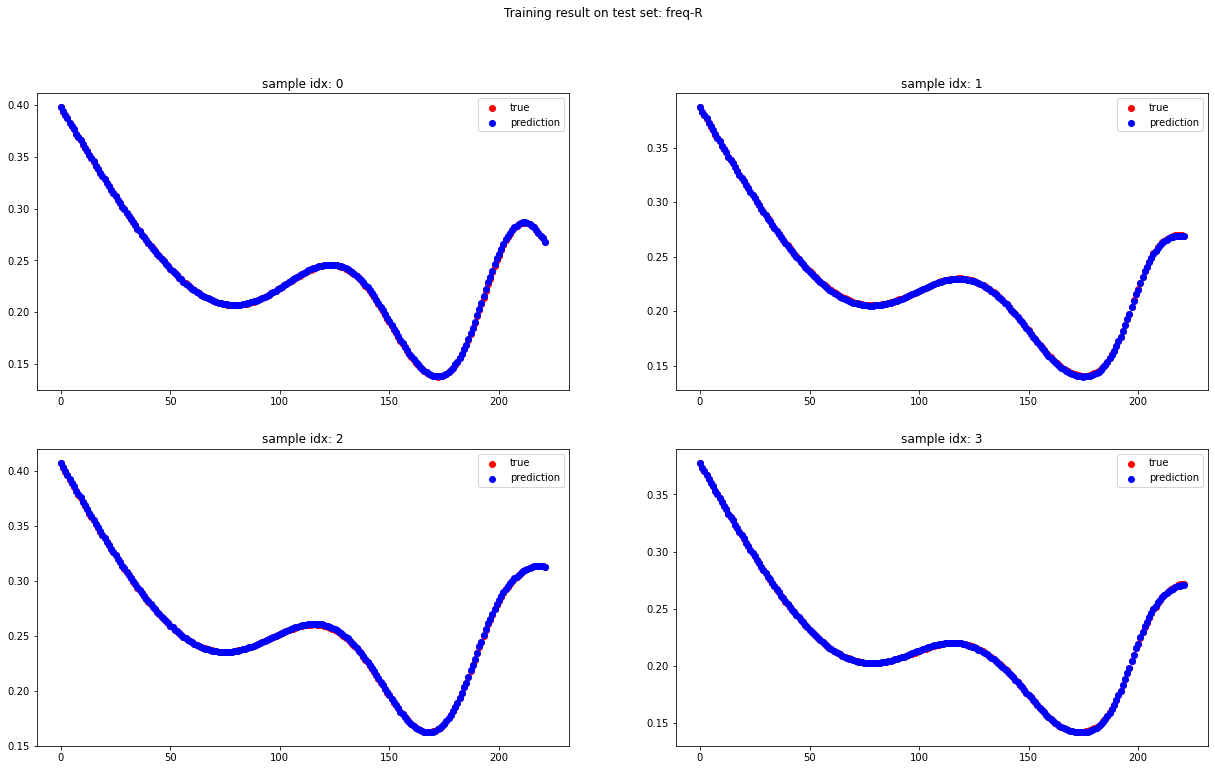

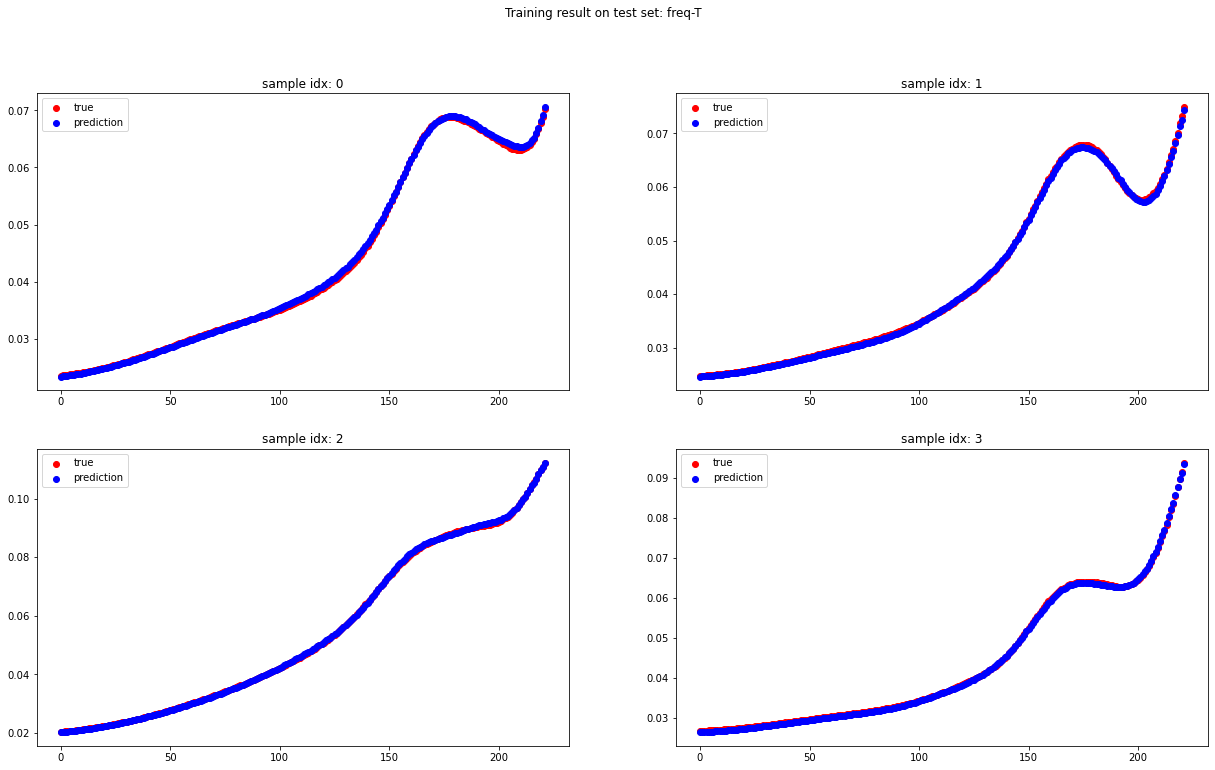

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

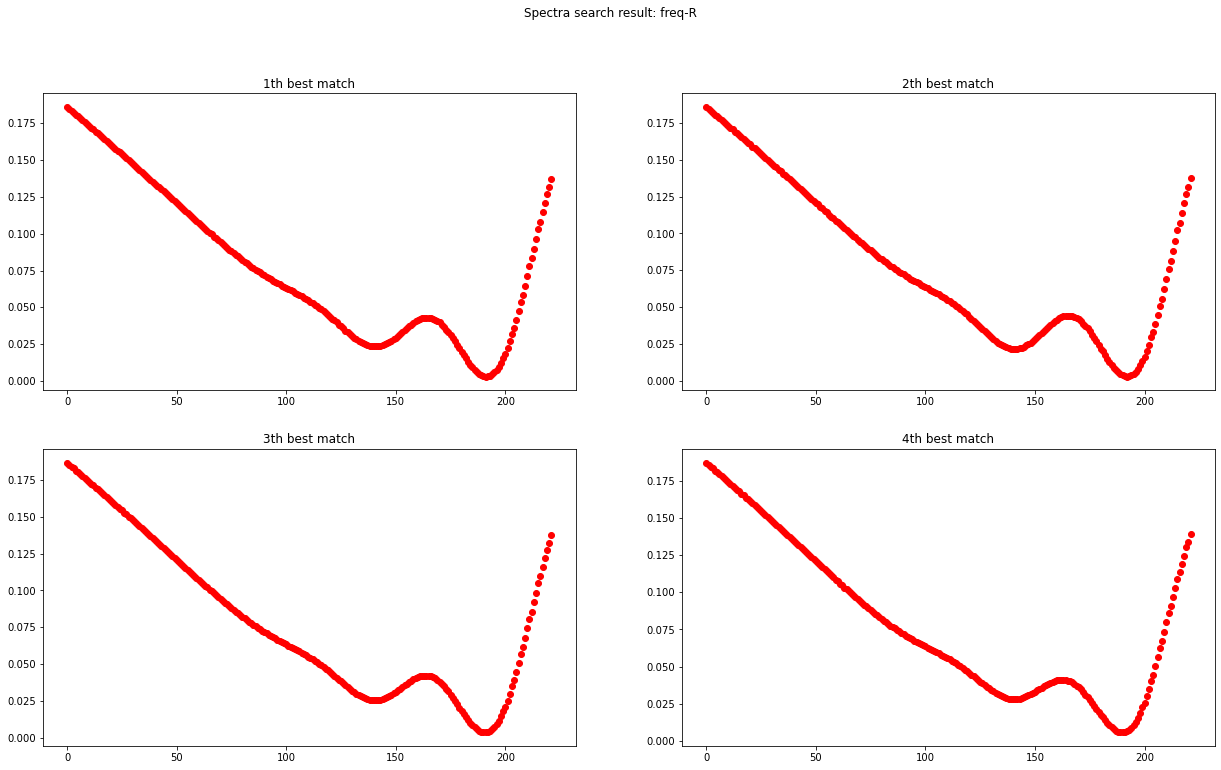

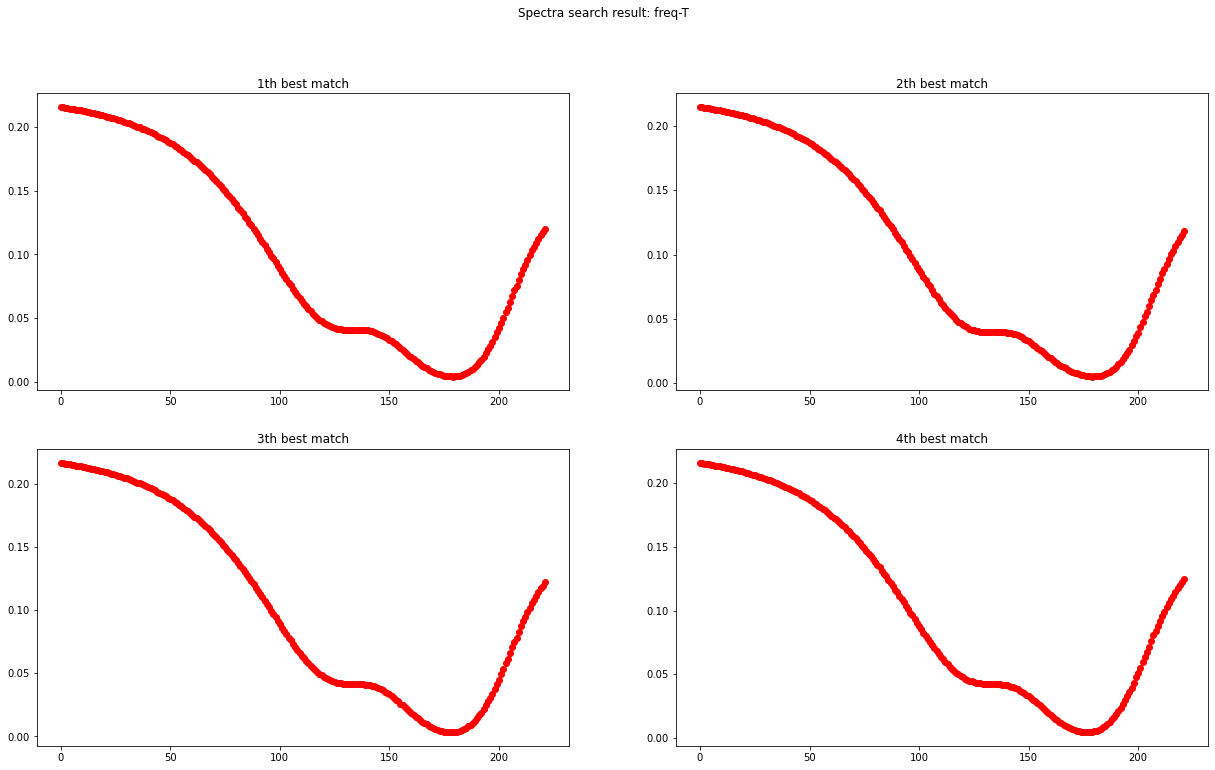

params_pick_visual.shape: (90, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (1817, 4)
R_dict.shape: (1817, 222)
T_dict.shape: (1817, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [150. 130. 160.  75.] params_pick: [150. 130. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [150. 131. 160.  75.] params_pick: [150. 131. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [150. 129. 160.  75.] params_pick: [150. 129. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [150. 128. 160.  75.] params_pick: [150. 128. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [150. 132. 160.  75.] params_pick: [150. 132. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [150. 127. 160.  75.] params_pick: [150. 127. 160.  75.]
--------------------
7 th match
Already in the dict.
# param

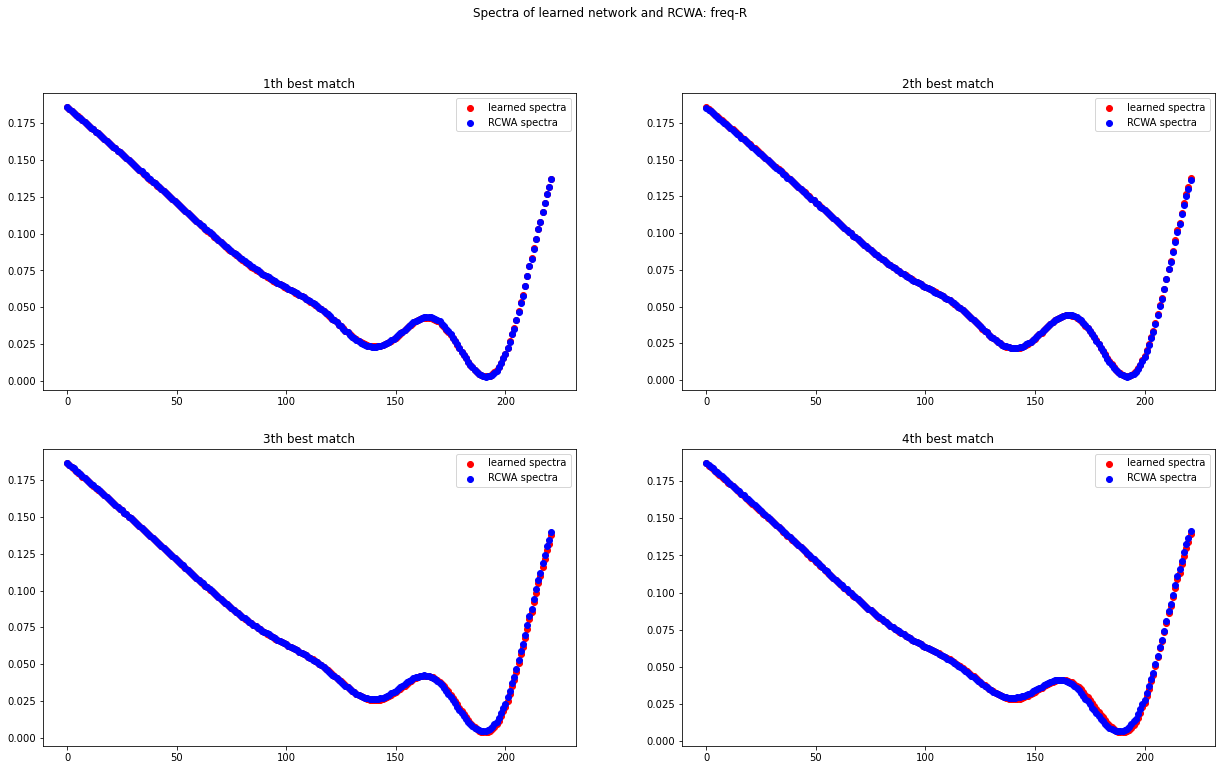

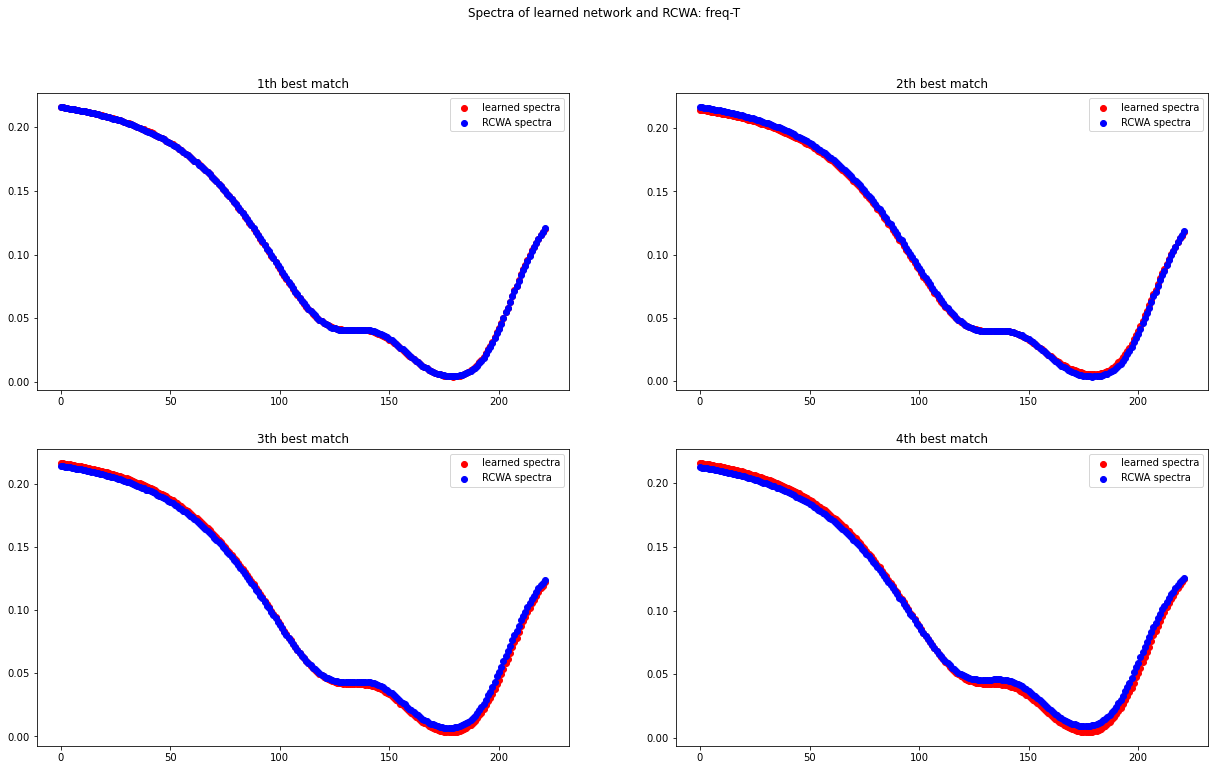

** Model saved.
**************************** ROUND 10 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 2000
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [122. 110.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 50. 114.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [96. 63.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 92. 115.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 74. 116.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 78. 130.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [69. 59.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [107.  89.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [ 64. 132.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [117. 112.]
Calculation 

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [149. 108.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [75. 59.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 85. 112.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [118.  90.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [ 62. 145.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [122.  74.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 91. 102.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [51. 70.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [116.  98.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [116. 134.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [77. 60.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [68. 58.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 2.1213323255068416e-05
### TEST LOSS  0.00014028323615396707
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 1.0850369637260825e-05
### TEST LOSS  4.27527149895468e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 4.9864702305555395e-06
### TEST LOSS  4.289087132747227e-06
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 2.8427823545769115e-06
### TEST LOSS  2.477068994721776e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.3120632655100336e-06
### TEST LOSS  2.069429145497755e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 3.4694829038919294e-06
### TEST LOSS  2.352350956395336e-06
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.4326703233500381e-06
### TEST LOSS  2.215755826758444e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.3408138307084983e-06
### TEST LOSS  9.161490387062562e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.4028155282659327e-06
### TEST LOSS  1.2865166032346072e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.0416072718761882e-06
### TEST LOSS  9.727071396052148e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 9.106355367105579e-07
### TEST LOSS  4.389057911187895e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.879903796352167e-06
### TEST LOSS  7.37022390732515e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 4.613708450795784e-07
### TEST LOSS  3.4540098615328436e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 4.700231444889624e-07
### TEST LOSS  2.957672004792281e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 4.150845358861233e-07
### TEST LOSS  5.622526733380558e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 4.5631065378159973e-07
### TEST LOSS  3.313148634257838e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 4.608352166588503e-07
### TEST LOSS  4.0217768647229e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 4.6971867416090164e-07
### TEST LOSS  5.135262635273345e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 3.950647445680744e-07
### TEST LOSS  2.8621900867165094e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 3.595631525872278e-07
### TEST LOSS  3.4209439358316256e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 3.774930006326116e-07
### TEST LOSS  5.521456472479258e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 3.532542802116012e-07
### TEST LOSS  2.782144212195211e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 3.8476969649714474e-07
### TEST LOSS  3.563818789113308e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 3.7599679860278455e-07
### TEST LOSS  3.8988023997414227e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 3.4502204015574023e-07
### TEST LOSS  5.732236947627219e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 3.4321274159587747e-07
### TEST LOSS  5.670922111751982e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 3.446043449955027e-07
### TEST LOSS  3.21825138390371e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 3.5944315224156754e-07
### TEST LOSS  4.1030642800402953e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 3.502966962489751e-07
### TEST LOSS  4.235279751204265e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 3.4844845872505914e-07
### TEST LOSS  3.522374285580554e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 3.35326185540552e-07
### TEST LOSS  2.9294561159076694e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.2475557339271e-07
### TEST LOSS  3.906981068742728e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 3.735178954773488e-07
### TEST LOSS  3.275088279982204e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 3.5087450323967315e-07
### TEST LOSS  3.671395215102772e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 3.274203417600319e-07
### TEST LOSS  2.1453302518163279e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 3.275560535271893e-07
### TEST LOSS  3.9690426092420237e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.238441265143166e-07
### TEST LOSS  4.2557034305446e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.90753072532668e-07
### TEST LOSS  4.844500959203894e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 3.465523876267085e-07
### TEST LOSS  3.073024122575892e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 3.3396292549525696e-07
### TEST LOSS  3.358917226137237e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.1434452697620685e-07
### TEST LOSS  3.008322039477207e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 1.0329013843772827e-06
### TEST LOSS  1.9492096403913213e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.2144859581340055e-07
### TEST LOSS  2.141207294433419e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.3451871595335803e-07
### TEST LOSS  3.0752130252646264e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.2346287828488584e-07
### TEST LOSS  2.2827027237326548e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.17448352578964e-07
### TEST LOSS  2.8239549626126367e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.2142451144245855e-07
### TEST LOSS  3.0235963161355054e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 3.034220951159128e-07
### TEST LOSS  4.209054651482802e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.408908433382152e-07
### TEST LOSS  2.7315045703820335e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.09362057691942e-07
### TEST LOSS  3.202090875712808e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.0098572130299315e-07
### TEST LOSS  2.8701059780663246e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.070899063519761e-07
### TEST LOSS  4.5236048814937625e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 2.9574366798090776e-07
### TEST LOSS  3.3881285096034236e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 2.9840320224749916e-07
### TEST LOSS  3.3167384572152514e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 2.8996152567550836e-07
### TEST LOSS  2.494064716529465e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.029726410046507e-07
### TEST LOSS  3.2188028076992243e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 2.9154737814529596e-07
### TEST LOSS  3.2090389652239536e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 2.9968275094383046e-07
### TEST LOSS  2.88018978267246e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 2.9579414219327303e-07
### TEST LOSS  4.184220642855507e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.017366860937898e-07
### TEST LOSS  3.063444694362261e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.1922609545453895e-07
### TEST LOSS  1.7957526286712284e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.041159780599045e-07
### TEST LOSS  2.6596670939701045e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 2.832720700967073e-07
### TEST LOSS  2.1780526301048061e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 2.868011786958391e-07
### TEST LOSS  2.68386503421425e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 2.916031780184625e-07
### TEST LOSS  4.568869153824077e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 2.849580427444209e-07
### TEST LOSS  2.0069396290030757e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 2.9338716470839186e-07
### TEST LOSS  5.678022650575562e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 3.013736426407121e-07
### TEST LOSS  2.1858189190500827e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.1284273209486456e-07
### TEST LOSS  2.5388787795084984e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.833062253131402e-07
### TEST LOSS  2.6822866251071293e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 2.875497020609075e-07
### TEST LOSS  3.0612820391221853e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 2.6370523222141175e-07
### TEST LOSS  3.1139323605581616e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 2.8366978384664067e-07
### TEST LOSS  2.809844237579758e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 2.9604683480144443e-07
### TEST LOSS  2.632351476942555e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 2.86418229507035e-07
### TEST LOSS  2.0780564445506872e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 2.84842055159551e-07
### TEST LOSS  2.1477919981786423e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.782657495599139e-07
### TEST LOSS  1.99619329066536e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.75987456930693e-07
### TEST LOSS  2.7561630891644505e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 2.5872282914907173e-07
### TEST LOSS  2.9263976131232994e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.8636457582109643e-07
### TEST LOSS  1.9879803119238205e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 2.6837891346165323e-07
### TEST LOSS  3.127665929506899e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 2.6928005778792395e-07
### TEST LOSS  2.0698900916234682e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.5772645462396324e-07
### TEST LOSS  2.3648661671889688e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 2.8304500099807227e-07
### TEST LOSS  1.962360618297983e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 2.878591737598413e-07
### TEST LOSS  2.2263982231152112e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 2.8699956946454107e-07
### TEST LOSS  3.2630896432313726e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.823513171232861e-07
### TEST LOSS  1.9892074665979937e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 2.717277294639331e-07
### TEST LOSS  2.2674340840467267e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 2.727421812007691e-07
### TEST LOSS  4.831201020275936e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.942800225245179e-07
### TEST LOSS  2.412804600263977e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 2.685286566990186e-07
### TEST LOSS  2.114925322871386e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 2.682229149053583e-07
### TEST LOSS  1.8707704517358554e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 2.6341324155598756e-07
### TEST LOSS  3.737211433948081e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 2.919994003498516e-07
### TEST LOSS  2.4315124941646596e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 2.8169532212185544e-07
### TEST LOSS  2.3332545898332076e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 2.853427602573788e-07
### TEST LOSS  2.50070298098611e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.688795539569355e-07
### TEST LOSS  2.7867654258291924e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 2.704998571365635e-07
### TEST LOSS  2.2869717592281328e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.6348997538061526e-07
### TEST LOSS  3.9789162826764367e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 2.763235236358241e-07
### TEST LOSS  2.67322338250627e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.758513245932903e-07
### TEST LOSS  3.8745529593597896e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.71091035069837e-07
### TEST LOSS  1.7198188804930698e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.9773057694715275e-07
### TEST LOSS  2.7039415613216987e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.9247860635273073e-07
### TEST LOSS  2.5067110414056516e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.6566978662234675e-07
### TEST LOSS  3.38759761101907e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 2.7195418123149296e-07
### TEST LOSS  1.979166441401503e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.6974891461417625e-07
### TEST LOSS  2.6148576637297083e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.7851262235678574e-07
### TEST LOSS  2.623265468552442e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.615771621199414e-07
### TEST LOSS  2.4747924006381555e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 2.611385216910733e-07
### TEST LOSS  4.241107698514194e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.643008448890427e-07
### TEST LOSS  3.353623090636878e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.9389867055140685e-07
### TEST LOSS  1.9144789623245136e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.6522804936668365e-07
### TEST LOSS  2.763594210364317e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.751897009050097e-07
### TEST LOSS  2.1323116736008766e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.736360365993562e-07
### TEST LOSS  2.2937907478611427e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.799167367797395e-07
### TEST LOSS  2.2828849068901036e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.5901313448351004e-07
### TEST LOSS  2.922441666441955e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.624386540279744e-07
### TEST LOSS  2.603700589058159e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.6985496806464224e-07
### TEST LOSS  6.765177924232073e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.860256572274622e-07
### TEST LOSS  2.8186167403039995e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.597680000127056e-07
### TEST LOSS  3.283900828895033e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 2.5625755570235497e-07
### TEST LOSS  1.8967591941532191e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.6179190535025045e-07
### TEST LOSS  2.488857660409849e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.660534933642822e-07
### TEST LOSS  2.174539721030063e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.606261529054521e-07
### TEST LOSS  2.701037478421616e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.693224471510547e-07
### TEST LOSS  2.031328013648211e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.786824614222638e-07
### TEST LOSS  3.8442787797521305e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.7252870358029923e-07
### TEST LOSS  3.06934702128577e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.4970273559965506e-07
### TEST LOSS  2.0627988609097277e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.756166693131945e-07
### TEST LOSS  1.9342760898174068e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.619504835656983e-07
### TEST LOSS  2.3474838712900236e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.646881887651276e-07
### TEST LOSS  2.1814877347499834e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 4.135387077219832e-07
### TEST LOSS  3.4581900365537876e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.1734128691596196e-07
### TEST LOSS  2.5325435473178e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.874637757557252e-07
### TEST LOSS  2.0722407327866678e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.478396066907251e-07
### TEST LOSS  2.6340036640704056e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.487776747504e-07
### TEST LOSS  2.583831620957729e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.4730876512357727e-07
### TEST LOSS  1.9799171440126885e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.6512842517334434e-07
### TEST LOSS  2.063282655247652e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 2.5716636988803996e-07
### TEST LOSS  1.8840631289170535e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.408090160228582e-07
### TEST LOSS  3.118099267377753e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.475907223367102e-07
### TEST LOSS  3.0237642410687235e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.5719138222335404e-07
### TEST LOSS  2.590612732925971e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.5215102510856014e-07
### TEST LOSS  2.1867040847685833e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.3742365378431885e-07
### TEST LOSS  2.423399019827836e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.4323824556660155e-07
### TEST LOSS  2.3260407052324203e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.483142349847256e-07
### TEST LOSS  3.157344110604754e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.648435339818178e-07
### TEST LOSS  2.0770012601663742e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.662997870546135e-07
### TEST LOSS  3.2184332875810167e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.5447961841162935e-07
### TEST LOSS  2.5195031885990225e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.587199276256058e-07
### TEST LOSS  2.483176582283401e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.472148682608477e-07
### TEST LOSS  2.9237174838196247e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.596817201174773e-07
### TEST LOSS  2.3545578689739462e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.4364085097516864e-07
### TEST LOSS  5.700120188597187e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.561317560565435e-07
### TEST LOSS  2.0941741875428004e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.5987527291970734e-07
### TEST LOSS  2.4017983738152303e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.518998233496106e-07
### TEST LOSS  1.922270196056767e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.549424092510577e-07
### TEST LOSS  2.2456987191314208e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.4395590980574867e-07
### TEST LOSS  2.1261979744243338e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 2.55864230052083e-07
### TEST LOSS  2.445636828459404e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.5474372525469135e-07
### TEST LOSS  3.528979505063035e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.5314758543082403e-07
### TEST LOSS  2.607878708242121e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.5468356471236573e-07
### TEST LOSS  2.4924499560559826e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.421662151652626e-07
### TEST LOSS  2.247678651201568e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.6111456603317154e-07
### TEST LOSS  2.2702145277738358e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.4530392668165035e-07
### TEST LOSS  3.46843730388476e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.497619563888165e-07
### TEST LOSS  1.9946782809180755e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.754214637317176e-07
### TEST LOSS  4.050589988461676e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.627621623316756e-07
### TEST LOSS  2.0799908639901332e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.528755226558488e-07
### TEST LOSS  2.0924381611090818e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.466517344075214e-07
### TEST LOSS  2.630349546469309e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.2794400527281765e-07
### TEST LOSS  1.9625467804947522e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.62336858915635e-07
### TEST LOSS  2.3303824955670886e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.463712151694608e-07
### TEST LOSS  3.3861741191761517e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.6217897277192035e-07
### TEST LOSS  3.1978468702694346e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.576172442649849e-07
### TEST LOSS  2.8707852000782926e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 2.4046806840161137e-07
### TEST LOSS  4.680721938636149e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.2972383723018908e-07
### TEST LOSS  1.7472845996735488e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.4907323058087625e-07
### TEST LOSS  2.0107752950101105e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.4541598168337233e-07
### TEST LOSS  2.80802569344966e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.537820231758303e-07
### TEST LOSS  2.0243157242324135e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.3868068700050316e-07
### TEST LOSS  2.914190645242343e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.652821194759625e-07
### TEST LOSS  2.3054107269141849e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 2.535293636585223e-07
### TEST LOSS  2.7299089471929013e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 2.618782935854824e-07
### TEST LOSS  1.7937064077007864e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.38797540029978e-07
### TEST LOSS  2.1411403139381946e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.525490500744354e-07
### TEST LOSS  2.0136605011581802e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.4210319537676383e-07
### TEST LOSS  3.3302301479428326e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.4532357423723283e-07
### TEST LOSS  2.6577643221041094e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 2.645916038144236e-07
### TEST LOSS  2.4744123550135555e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.619344169891846e-07
### TEST LOSS  3.46236571620769e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.6840620288126615e-07
### TEST LOSS  4.075094238942256e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.4252028716009734e-07
### TEST LOSS  2.4587940193517475e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.609613903317154e-07
### TEST LOSS  3.747572568120935e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.4026312318348174e-07
### TEST LOSS  1.9972972277552497e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.4480590375741686e-07
### TEST LOSS  1.9678958788441983e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.474307756674676e-07
### TEST LOSS  2.8726728752796285e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.485053465441922e-07
### TEST LOSS  2.0397746141043173e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.349551140676809e-07
### TEST LOSS  2.0083715668306468e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.591875420145939e-07
### TEST LOSS  2.281437223435508e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.605391967209769e-07
### TEST LOSS  2.3795938612162595e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.4197478718956946e-07
### TEST LOSS  2.1620000865141264e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.3736408235386364e-07
### TEST LOSS  2.6694315001426125e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.4651653427643083e-07
### TEST LOSS  2.4853064151860356e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.480587785260724e-07
### TEST LOSS  1.8987193139234175e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.416796157893586e-07
### TEST LOSS  2.2350663139529085e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.440181635590122e-07
### TEST LOSS  3.462605462800639e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.464427077413234e-07
### TEST LOSS  1.748095982634368e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.4208489675103805e-07
### TEST LOSS  2.1220633972992193e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.210864980449756e-07
### TEST LOSS  2.1815977220285275e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.455999481822957e-07
### TEST LOSS  2.0919452055068176e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.377309544998596e-07
### TEST LOSS  1.999397009437113e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.3831331121915155e-07
### TEST LOSS  2.3669756169889902e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.424796700379872e-07
### TEST LOSS  1.991920219287143e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.3766319934370727e-07
### TEST LOSS  3.56706355357043e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.4994351562312997e-07
### TEST LOSS  1.7425627163447643e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.3751547538974905e-07
### TEST LOSS  1.8708911161032424e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.3493823407871873e-07
### TEST LOSS  2.748802216956392e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.4046650008280323e-07
### TEST LOSS  2.07779684065675e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.5299193438321763e-07
### TEST LOSS  3.0034722631929374e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.5827521655052977e-07
### TEST LOSS  2.0360159377711777e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.4581441647875126e-07
### TEST LOSS  2.61254147441529e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.371355721804136e-07
### TEST LOSS  1.9229505028306447e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.3630978973265825e-07
### TEST LOSS  3.2332298995167244e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.3268644876672796e-07
### TEST LOSS  2.0702113943116273e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.325358152788226e-07
### TEST LOSS  1.9562738439541742e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.4191749673541095e-07
### TEST LOSS  3.069356935725409e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.4467470524847103e-07
### TEST LOSS  1.9113357675829928e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.333768356788113e-07
### TEST LOSS  2.455215010854772e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.351655661136931e-07
### TEST LOSS  1.906180296865993e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.2942801913572453e-07
### TEST LOSS  1.9160511849728815e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.339206540300509e-07
### TEST LOSS  1.9676583491445853e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.4094964589149723e-07
### TEST LOSS  2.43208590688937e-07
** loss_train 2.4094964589149723e-07
** loss_test 2.43208590688937e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


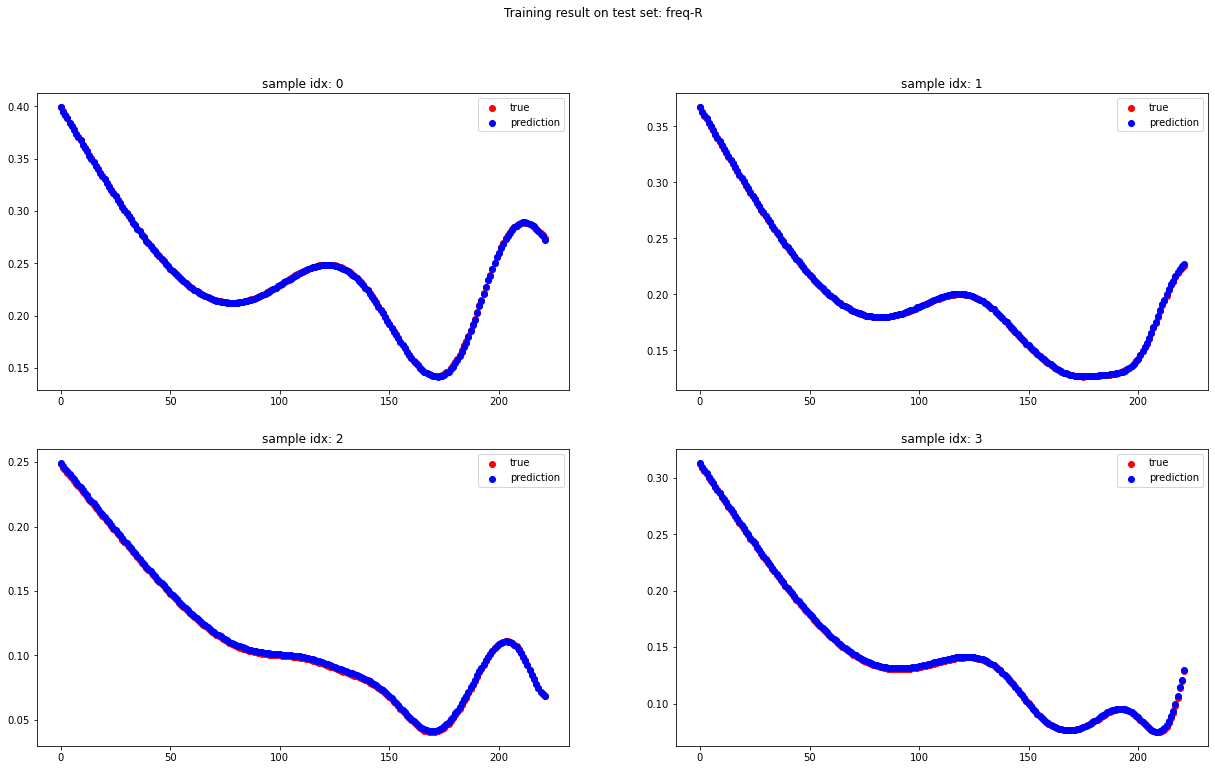

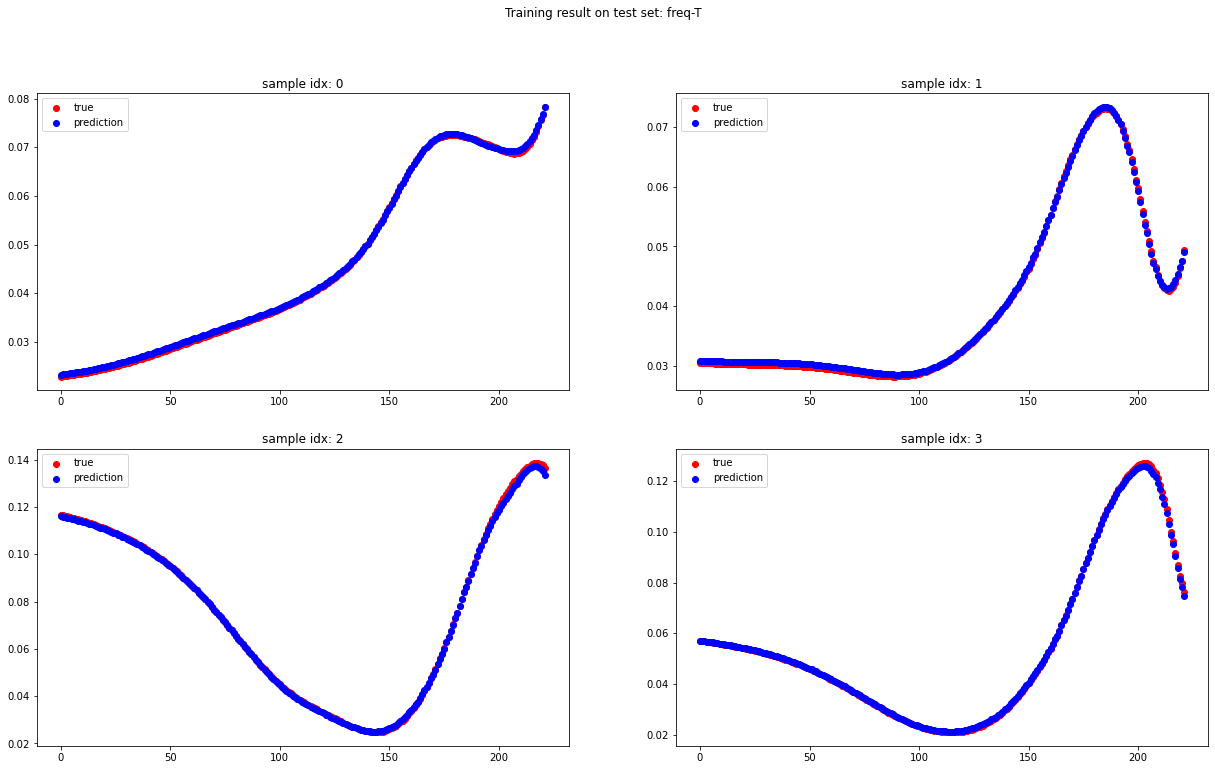

# search both R and T
#tg_idx_freq.shape: (444,)
#tg_idx_freq: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

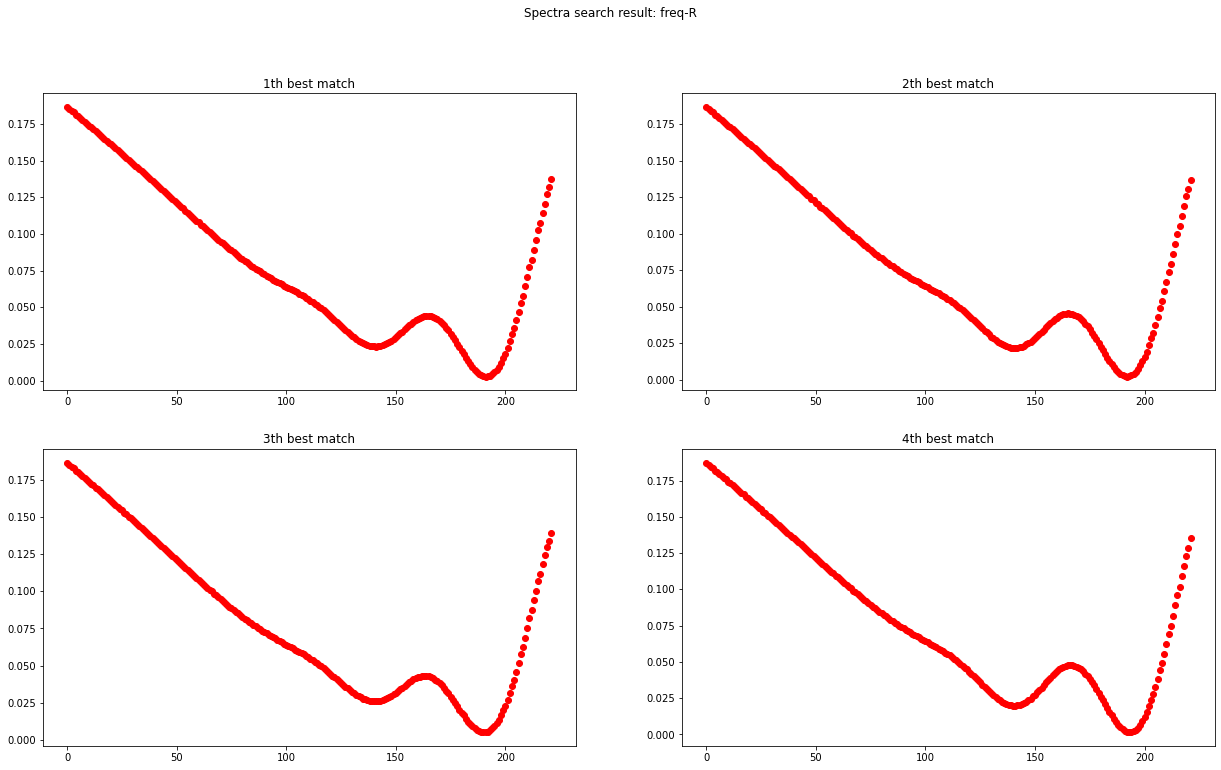

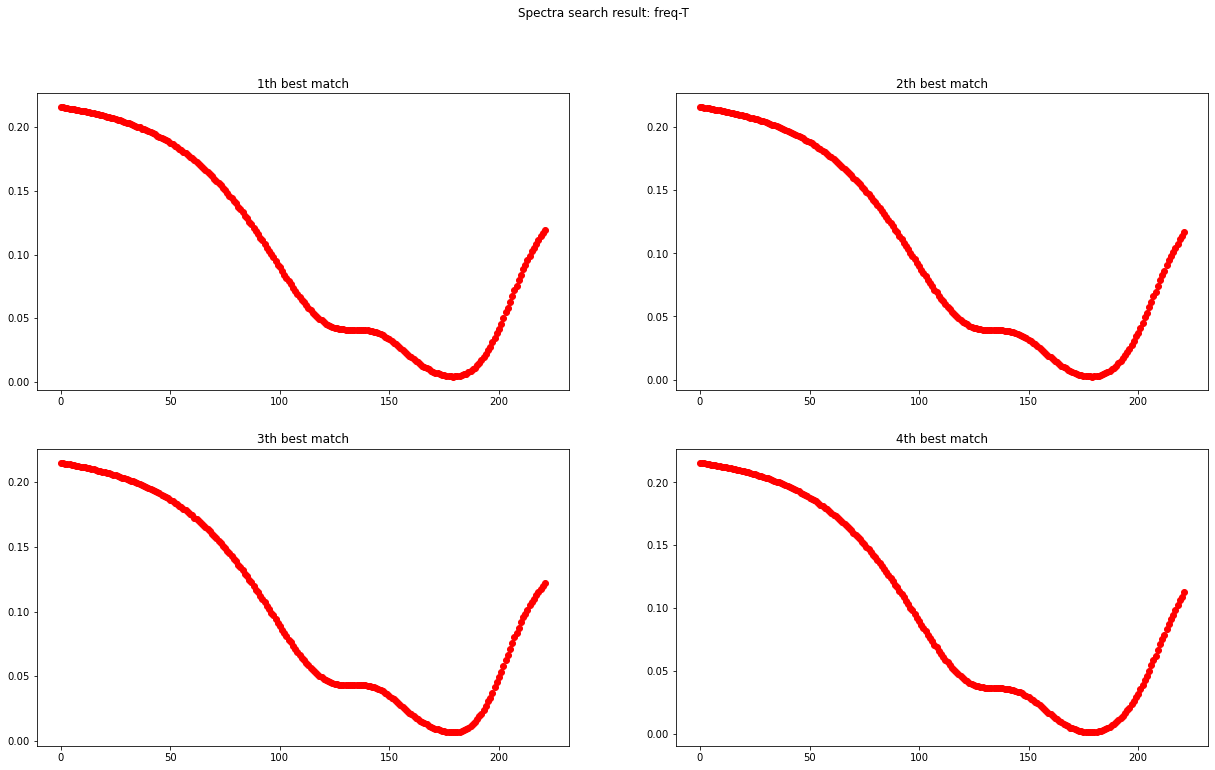

params_pick_visual.shape: (100, 4)
** Params_pick for visualization saved.
*** Reruning RCWA on picked params
params_dict.shape: (2017, 4)
R_dict.shape: (2017, 222)
T_dict.shape: (2017, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [150. 130. 160.  75.] params_pick: [150. 130. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [150. 131. 160.  75.] params_pick: [150. 131. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [150. 129. 160.  75.] params_pick: [150. 129. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [150. 132. 160.  75.] params_pick: [150. 132. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [150. 128. 160.  75.] params_pick: [150. 128. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [150. 133. 160.  75.] params_pick: [150. 133. 160.  75.]
--------------------
7 th match
Already in the dict.
# para

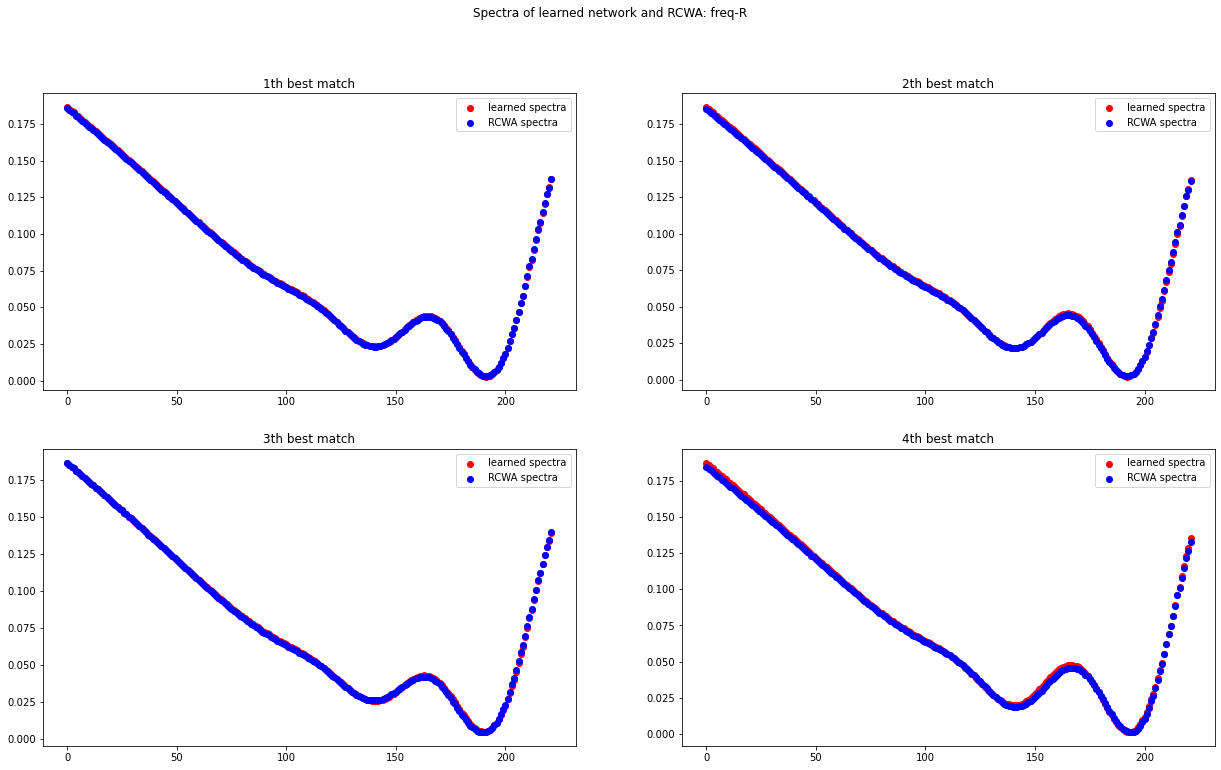

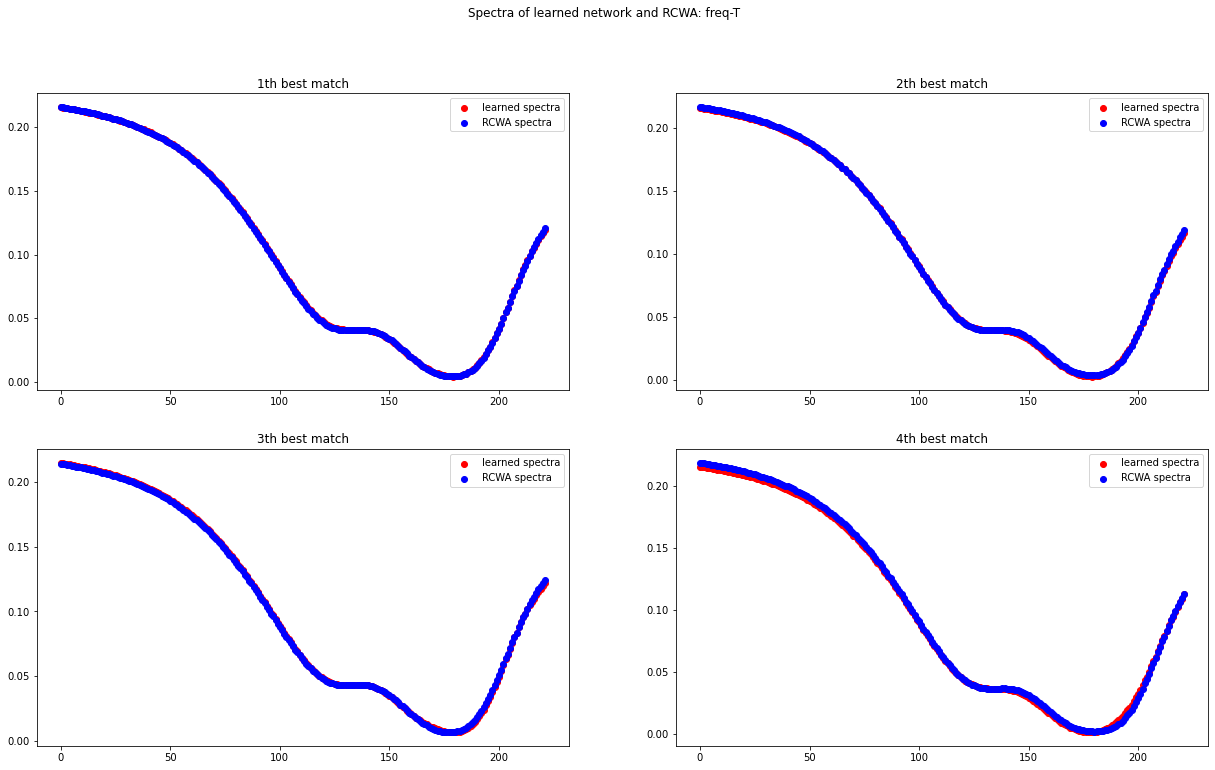

** Model saved.


In [7]:
loss_tolerance = 1e-3
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA Simulation Prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# make data dir if necessary
if not os.path.exists('./data/' + path_material_name + '/'):
    os.makedirs('./data/' + path_material_name + '/')

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 7  # RCWA accuracy, higher to be more accurate, use 7 for speed
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]

# ====== Generate Pseudo Params, [D1, D2] ======
range_D1 = [50,151,1]  # [range_start, range_end, step_size]
range_D2 = [50,151,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)  # [D1,D2,a,t]

# ====== Define Target Spectra ======
# tg_idx_freq_R = np.array([129])
# tg_value_R = np.array([0.03])
# tg_idx_freq_T = np.array([0, 167])
# tg_value_T = np.array([0.228, 0.004])
tg_idx_freq_R = np.array(np.arange(222))
tg_value_R = R_target
tg_idx_freq_T = np.array(np.arange(222))
tg_value_T = T_target
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Simulation ======
    num_data = 200
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params, R, T = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True)
    print('params.shape:', params.shape)
    print('R.shape:', R.shape)
    print('T.shape:', T.shape)
    
    # save all data
    path_all_data_round = './data/' + path_material_name + '/all_data_' + path_material_name + '_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params, R=R, T=T)
    print('** Round data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_all = np.array([]).reshape((0,params.shape[-1]))
        R_all = np.array([]).reshape((0,R.shape[-1]))
        T_all = np.array([]).reshape((0,T.shape[-1]))
    params_all = np.concatenate((params_all, params), axis=0)
    R_all = np.concatenate((R_all, R), axis=0)
    T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)  # [N,p]
    print('R_all.shape:', R_all.shape)  # [N,N_freq]
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data_' + path_material_name + '.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('** All rounds data saved.')
    
    # save all data stacked for trajectory visualization (*optional)
    if ROUND==1:
        params_all_visual = np.array([]).reshape((0,params.shape[-1]))
        R_all_visual = np.array([]).reshape((0,R.shape[-1]))
        T_all_visual = np.array([]).reshape((0,R.shape[-1]))
    params_all_visual = np.concatenate((params_all_visual, params), axis=0)
    R_all_visual = np.concatenate((R_all_visual, R), axis=0)
    T_all_visual = np.concatenate((T_all_visual, T), axis=0)
    print('params_all_visual.shape:', params_all_visual.shape)
    print('R_all_visual.shape:', R_all_visual.shape)
    print('T_all_visual.shape:', T_all_visual.shape)
    path_all_data_visual = './data/' + path_material_name + '/all_data_visual_' + path_material_name + '.npz'
    np.savez(path_all_data_visual, params=params_all_visual, R=R_all_visual, T=T_all_visual)
    print('** All rounds data for visualization saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 20
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # import network
    if ROUND==1:
        dim_in = params_all.shape[-1]  # N_param
        dim_out = R_all.shape[-1]  # N_freq
        net_dense = DenseConvTranspose1D(dim_in,dim_out)
        net_dense = net_dense.to(device)
    
    # *** train network
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    scheduler = None
    N_epoch = 2000  # number of epochs trained
    loss_train, loss_test = training_utils.train_model(dataloader, dataloader_test, optimizer, criteon, net_dense, device, NUM_EPOCH=N_epoch, scheduler=scheduler)
    print('** loss_train', loss_train)
    print('** loss_test', loss_test)
    
    # visualize spectra on test set
    visualize_trained_net(dataloader_test)
    
    
    # ====== Spectra Search ======
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, net_dense, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    params_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('pseudo_params.shape:', pseudo_params.shape)
    print('params_pick.shape:', params_pick.shape)
    print('params_pick:', params_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
    visualize_spectra_search(params_pick, R_pick, T_pick)
    # save picked design params for visualization (*optional)
    if ROUND==1:
        params_pick_visual = params_pick
    else:
        params_pick_visual = np.concatenate((params_pick_visual, params_pick), axis=0)
    print('params_pick_visual.shape:', params_pick_visual.shape)
    path_params_pick_visual = './data/' + path_material_name + '/params_pick_visual_' + path_material_name + '.npz'
    np.savez(path_params_pick_visual, params=params_pick_visual)
    print('** Params_pick for visualization saved.')
    
    
    # ====== Run RCWA Search on Picked Params ======
    # add param dict check here to save more time
    print('*** Reruning RCWA on picked params')
    if ROUND==1:
        params_dict = params_all
        R_dict = R_all
        T_dict = T_all
    else:
        params_dict = np.concatenate((params_dict, params), axis=0)
        R_dict = np.concatenate((R_dict, R), axis=0)
        T_dict = np.concatenate((T_dict, T), axis=0)
    print('params_dict.shape:', params_dict.shape)
    print('R_dict.shape:', R_dict.shape)
    print('T_dict.shape:', T_dict.shape)
    
    rerun_params, R_simu, T_simu = np.zeros_like(params_pick), np.zeros_like(R_pick), np.zeros_like(T_pick)
    for idx_pick in range(R_pick.shape[0]):  # for each in N_top
        print('--------------------')
        print(idx_pick+1, 'th match')
        if np.any(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)):  # if picked params already in the dict
            print('Already in the dict.')
            idx_same = np.argwhere(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)==True)[0].squeeze()  # get the idx in the dict
            print('# params_dict:', params_dict[idx_same], 'params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = params_dict[idx_same][np.newaxis,...], R_dict[idx_same][np.newaxis,...], T_dict[idx_same][np.newaxis,...]
        else:  # picked params not in the dict, call rcwa solver
            print('Not in the dict, calling RCWA...')
            params_pick_rcwa = params_pick[idx_pick][np.newaxis,...]
            print('# params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=params_pick_rcwa)
            # add unseen simu data into dict
            params_dict = np.concatenate((params_dict, rerun_params_i), axis=0)
            R_dict = np.concatenate((R_dict, R_simu_i), axis=0)
            T_dict = np.concatenate((T_dict, T_simu_i), axis=0)
        rerun_params[idx_pick], R_simu[idx_pick], T_simu[idx_pick] = rerun_params_i, R_simu_i, T_simu_i
    # save the dict
    path_dict = './data/' + path_material_name + '/data_dict_' + path_material_name + '.npz'
    np.savez(path_dict, params=params_dict, R=R_dict, T=T_dict)
    print('** Dict data saved.')
    # save params_list and update all_params as params_dict (*optional)
#     path_params_list = './data/' + path_material_name + '/params_list_' + path_material_name + '.npz'
#     print('params_dict[..., 0:2].shape:', params_dict[..., 0:2].shape)
#     np.savez(path_params_list, params_list=params_dict[..., 0:2])
#     params_all, R_all, T_all = params_dict, R_dict, T_dict
#     print('params_dict.shape:', params_dict.shape)
    
    # MSE between learned spectra and simulated spectra
    mse_R = ((R_pick - R_simu)**2).mean(axis=-1)  # [N_top]
    mse_T = ((T_pick - T_simu)**2).mean(axis=-1)
    print('* MSE_R for each:', mse_R)
    print('* MSE_T for each:', mse_T)
    print('* MSE_R:', np.average(mse_R))
    print('* MSE_T:', np.average(mse_T))
    sqrt_mse_R = np.average(np.sqrt(mse_R))
    sqrt_mse_T = np.average(np.sqrt(mse_T))
    loss_mse = np.average([sqrt_mse_R, sqrt_mse_T])
    print('* sqrt MSE_R:', sqrt_mse_R)
    print('* sqrt MSE_T:', sqrt_mse_T)
    print('* LOSS_SQRT_MSE:', loss_mse)
    loss = loss_mse

    print('*** Average SQRT MSE Loss between Trained Spectra and RCWA Spectra:', loss_mse)
    # visualize learned spectra and RCWA true spectra
    visualize_learned_and_rcwa(params_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12))
    
    
    # ====== Save Trained Model ======
    # make data dir if necessary
    if not os.path.exists('./trained_models/' + path_material_name + '/'):
        os.makedirs('./trained_models/' + path_material_name + '/')
    PATH_MODEL = './trained_models/' + path_material_name + '/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net_dense.state_dict(), PATH_MODEL)
    print('** Model saved.')
    
    ROUND += 1
    
plt.ioff()

## Save Trained Model

In [ ]:
PATH_MODEL = './trained_models/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
torch.save(net_dense.state_dict(), PATH_MODEL)
print('Model saved.')